In [1]:
import sys; sys.path.insert(0, '../../')
from definitions import *
from src.data.dataset import TimeSeriesDataset
import torch
from src.data import dicts
from src.features.signatures.compute import RollingSignature
from src.features.rolling import RollingStatistic
from src.data.functions import torch_ffill
from src.features.derived_features import shock_index, partial_sofa, bun_cr

In [2]:
# Load the dataset
dataset = TimeSeriesDataset().load(DATA_DIR + '/raw/data.tsd')

In [3]:

# First get counts of the laboratory values
count_variables = dicts.feature_types['laboratory'] + ['Temp']
counts = RollingStatistic(statistic='count', window_length=8).transform(dataset[count_variables])
dataset.add_features(counts)

<function RollingStatistic.transform at 0x000001CE0101B950> 
  1226.03 ms


In [4]:
# Apply a forward fill
dataset.data = torch_ffill(dataset.data)

In [5]:
# Add on some additional features
dataset['ShockIndex'] = shock_index(dataset)
dataset['PartialSOFA'] = partial_sofa(dataset)
dataset['BUN/CR'] = bun_cr(dataset)

In [6]:
# Now moments
changing_vars = dicts.feature_types['vitals']
dataset.add_features(RollingStatistic(statistic='moments', window_length=7).transform(dataset[changing_vars]))

<function RollingStatistic.transform at 0x000001CE0101B950> 
  3076.06 ms


In [7]:
# Now generate some rolling window features
max_vals = RollingStatistic(statistic='max', window_length=6).transform(dataset[dicts.feature_types['vitals']])
min_vals = RollingStatistic(statistic='min', window_length=6).transform(dataset[dicts.feature_types['vitals']])
dataset.add_features(torch.cat((max_vals, min_vals), 2))

<function RollingStatistic.transform at 0x000001CE0101B950> 
  352.01 ms
<function RollingStatistic.transform at 0x000001CE0101B950> 
  364.01 ms


In [8]:
# Now some rolling signatures
roller = RollingSignature(window=7, depth=3, aug_list=['leadlag'], logsig=True)
for vbl in ['BUN/CR', 'PartialSOFA', 'MAP', 'HR', 'SBP']:
    signatures = roller.transform(dataset[vbl])
    dataset.add_features(signatures)

<function RollingSignature.transform at 0x000001CE0101B2F0> 
  1155.02 ms
<function RollingSignature.transform at 0x000001CE0101B2F0> 
  1085.02 ms
<function RollingSignature.transform at 0x000001CE0101B2F0> 
  1183.03 ms
<function RollingSignature.transform at 0x000001CE0101B2F0> 
  1257.02 ms
<function RollingSignature.transform at 0x000001CE0101B2F0> 
  1179.03 ms


In [9]:
# Extract machine learning data
data = dataset.to_ml()

In [10]:
labels = load_pickle(DATA_DIR + '/processed/labels/utility_scores.pickle')

In [11]:
data[torch.isnan(data)] = 0

In [12]:
X = data[120492:]
y = labels[120492:]

In [13]:
'''
cv = []
for i, fold in enumerate(list(id_cv)):
    train_idxs = [id_idxs[i] for i in fold[0]]
    test_idxs = [id_idxs[i] for i in fold[1]]

    if not return_as_list:
        train_idxs = np.concatenate([id_idxs[i] for i in fold[0]])
        test_idxs = np.concatenate([id_idxs[i] for i in fold[1]])

    cv.append([train_idxs, test_idxs])
'''

'\ncv = []\nfor i, fold in enumerate(list(id_cv)):\n    train_idxs = [id_idxs[i] for i in fold[0]]\n    test_idxs = [id_idxs[i] for i in fold[1]]\n\n    if not return_as_list:\n        train_idxs = np.concatenate([id_idxs[i] for i in fold[0]])\n        test_idxs = np.concatenate([id_idxs[i] for i in fold[1]])\n\n    cv.append([train_idxs, test_idxs])\n'

In [14]:
# Regressor
from lightgbm import LGBMRegressor
print('Training model...')

clf = LGBMRegressor().set_params(**{'bagging_fraction': 0.8,
 'feature_fraction': 0.9,
 'max_depth': 23,
 'min_child_weight': 10,
 'min_split_gain': 0.001,
 'num_leaves': 70})

#clf = LGBMRegressor()

Training model...


In [15]:
print("Training...")
clf.fit(X,y)

Training...
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


LGBMRegressor(bagging_fraction=0.8, boosting_type='gbdt', class_weight=None,
              colsample_bytree=1.0, feature_fraction=0.9,
              importance_type='split', learning_rate=0.1, max_depth=23,
              min_child_samples=20, min_child_weight=10, min_split_gain=0.001,
              n_estimators=100, n_jobs=-1, num_leaves=70, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [16]:
from sklearn.metrics import r2_score
def bayesion_opt_lgbm(X=X, y=labels, init_iter=3, n_iters=7, random_state=11, seed = 101, num_iterations = 200):
  dtrain = lgb.Dataset(data=X, label=y)
  def lgb_r2_score(preds, dtrain):
      labels = dtrain.get_label()
      return 'r2', r2_score(labels, preds), True
  # Objective Function
  def hyp_lgbm(num_leaves, feature_fraction, bagging_fraction, max_depth, min_split_gain, min_child_weight):
        
          params = {'application':'regression','num_iterations': num_iterations,
                    'learning_rate':0.01, 'early_stopping_round':50,
                    'metric':'lgb_r2_score'} # Default parameters
          params["num_leaves"] = int(round(num_leaves))
          params['feature_fraction'] = max(min(feature_fraction, 1), 0)
          params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
          params['max_depth'] = int(round(max_depth))
          params['min_split_gain'] = min_split_gain
          params['min_child_weight'] = min_child_weight
          cv_results = lgb.cv(params, dtrain, nfold=5, seed=seed,categorical_feature=[], stratified=False,
                              verbose_eval =None, feval=lgb_r2_score)
          # print(cv_results)
          return np.max(cv_results['r2-mean'])
  # Domain space-- Range of hyperparameters 
  pds = {'num_leaves': (50, 200),
            'feature_fraction': (0.1, 0.9),
            'bagging_fraction': (0.8, 1),
            'max_depth': (13, 23),
            'min_split_gain': (0.001, 0.1),
            'min_child_weight': (10, 25)
            }

  # Surrogate model
  optimizer = BayesianOptimization(hyp_lgbm, pds, random_state=random_state)
                                    
  # Optimize
  optimizer.maximize(init_points=init_iter, n_iter=n_iters)
  return optimizer


In [17]:
clf.feature_importances_

array([ 89,  30, 141,  46,  34,  24,  38,  76, 121,  13,  68,  98,  98,
       105, 109, 150, 141, 112,  27, 130,  33, 129,  76, 110, 112, 149,
       113,  94, 168, 100, 106, 227,  59, 137, 231,   3,  12,  18, 272,
       460,   0,  38,  43,  32,  10,  19,  32,  20,  32,  14,   4,   1,
         8,  12,   1,   5,  47,  29,   2,   5,  10,   0,   8,  16,   2,
         9,   8,   4,   2,  63,  17, 118,  40,  41,  44,  38,  32,  27,
        41,  25,  35,  25,  36,  36,  51,  24, 122,  60, 151,  50,  55,
        70,  47,  99,  51,  83,  92,  71,  64,  65,  54,   4,  23,  27,
        15,  16,   1,  48,  33,  21,   6,   1,  35,   5,   7,  33,   4,
        36,  17,   8,   5,   2,  33,  11,  10])

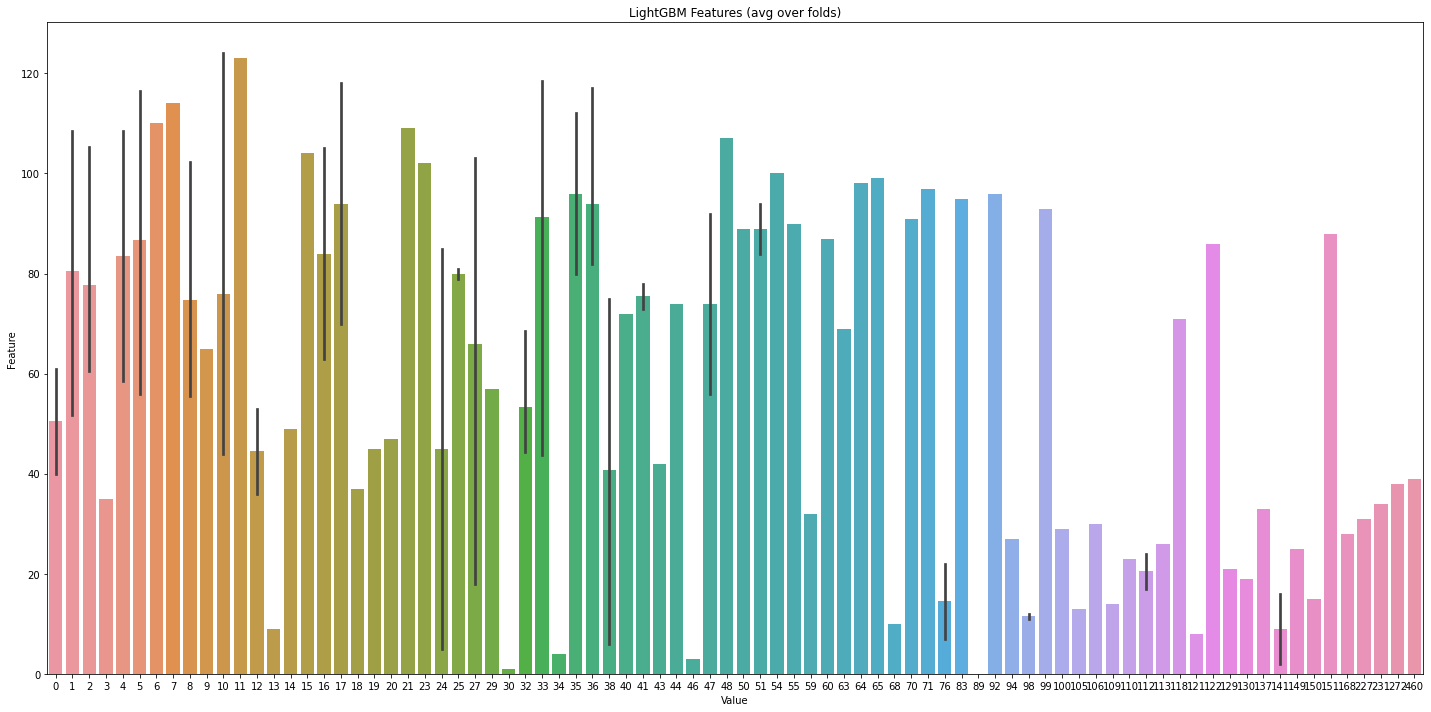

<Figure size 432x288 with 0 Axes>

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,range(125))), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

In [23]:
import lightgbm as lgb
import BayesianOptimization

ModuleNotFoundError: No module named 'BayesianOptimization'

In [22]:
optimizer = bayesion_opt_lgbm(X=X, y=y.numpy(), init_iter=5, n_iters=15, random_state=717, seed = 1011, num_iterations = 300)

NameError: name 'BayesianOptimization' is not defined

In [93]:

#list((optimizer.max).items())[1][1]

In [94]:
import numpy as np

def calculate_psi(expected, actual, buckettype='bins', buckets=10, axis=0):
    '''Calculate the PSI (population stability index) across all variables
    Args:
       expected: numpy matrix of original values
       actual: numpy matrix of new values, same size as expected
       buckettype: type of strategy for creating buckets, bins splits into even splits, quantiles splits into quantile buckets
       buckets: number of quantiles to use in bucketing variables
       axis: axis by which variables are defined, 0 for vertical, 1 for horizontal
    Returns:
       psi_values: ndarray of psi values for each variable
    Author:
       Matthew Burke
       github.com/mwburke
       worksofchart.com
    '''

    def psi(expected_array, actual_array, buckets):
        '''Calculate the PSI for a single variable
        Args:
           expected_array: numpy array of original values
           actual_array: numpy array of new values, same size as expected
           buckets: number of percentile ranges to bucket the values into
        Returns:
           psi_value: calculated PSI value
        '''

        def scale_range (input, min, max):
            input += -(np.min(input))
            input /= np.max(input) / (max - min)
            input += min
            return input


        breakpoints = np.arange(0, buckets + 1) / (buckets) * 100

        if buckettype == 'bins':
            breakpoints = scale_range(breakpoints, np.min(expected_array), np.max(expected_array))
        elif buckettype == 'quantiles':
            breakpoints = np.stack([np.percentile(expected_array, b) for b in breakpoints])



        expected_percents = np.histogram(expected_array, breakpoints)[0] / len(expected_array)
        actual_percents = np.histogram(actual_array, breakpoints)[0] / len(actual_array)

        def sub_psi(e_perc, a_perc):
            '''Calculate the actual PSI value from comparing the values.
               Update the actual value to a very small number if equal to zero
            '''
            if a_perc == 0:
                a_perc = 0.0001
            if e_perc == 0:
                e_perc = 0.0001

            value = (e_perc - a_perc) * np.log(e_perc / a_perc)
            return(value)

        psi_value = np.sum(sub_psi(expected_percents[i], actual_percents[i]) for i in range(0, len(expected_percents)))

        return(psi_value)

    if len(expected.shape) == 1:
        psi_values = np.empty(len(expected.shape))
    else:
        psi_values = np.empty(expected.shape[axis])

    for i in range(0, len(psi_values)):
        if len(psi_values) == 1:
            psi_values = psi(expected, actual, buckets)
        elif axis == 0:
            psi_values[i] = psi(expected[:,i], actual[:,i], buckets)
        elif axis == 1:
            psi_values[i] = psi(expected[i,:], actual[i,:], buckets)

    return(psi_values)

In [95]:
## Calculate psi for features
def psi():
    psi_list = []
    for i in range(125):
        # Assuming you have a validation and training set
        psi_t = calculate_psi(data[120492:][:, i].numpy(), data[:120492][:, i].numpy())
        psi_list.append(psi_t)      
        print('Stability index for column ',i,'is',psi_t)

In [96]:
## K-S Test for features
from scipy.stats import ks_2samp
def KSTest():
    for i in range(125):

        test = ks_2samp(data[120492:][:, i].numpy(), data[:120492][:, i].numpy())
        print(" Kolmogorov-Smirnov (K-S) test for column ", i," is: ", test)

In [97]:
import skmultiflow

In [98]:
from skmultiflow.drift_detection import ADWIN

def adwin():
    adwin = ADWIN()
    for col in range(125):
      data_stream=[]
      a = np.array(data[120492:][:, col])
      b = np.array(data[:120492][:, col])
      data_stream = np.concatenate((a,b))
    # Adding stream elements to ADWIN and verifying if drift occurred
      for i in range(len(data_stream)):
        adwin.add_element(data_stream[i])
        if adwin.detected_change():
            print('Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i) +'for column:' + str(col))

In [99]:
# Page Hinkley Test
import numpy as np
from skmultiflow.drift_detection import PageHinkley

def pageHinkley():
    ph = PageHinkley()
    for col in range(125):
        data_stream=[]
        a = np.array(data[120492:][:, col])
        b = np.array(data[:120492][:, col])
        data_stream = np.concatenate((a,b))
        for i in range(len(data_stream)):
            ph.add_element(data_stream[i])
            if ph.detected_change():
                print('Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i) +'for column:' + str(col))

In [100]:
# Imports
    
    
import numpy as np
from skmultiflow.data import TemporalDataStream
from skmultiflow.drift_detection import KSWIN
import numpy as np
# Initialize KSWIN and a data stream
def KSWINTest():
    kswin = KSWIN(alpha=0.01)
    print(type(kswin))
    for col in range(125):
        data_stream=[]
        a = np.array(data[120492:][:, col])
        b = np.array(data[:120492][:, col])
        data_stream = np.concatenate((a,b))
        batch_size = 10
        data_stream = TemporalDataStream(data_stream)
        #len(data_stream)/batch_size = 24216,1
        for i in range(24216):
            datas = data_stream.next_sample(batch_size)
            #testarray = np.array([datas[1],[]])
            print(datas)
            kswin.add_element(datas)
            if kswin.detected_change():
                print("\rIteration {}".format(i))
                print("\r KSWINReject Null Hyptheses")
                print('Change detected in batch: ' + str(len(data_stream)/batch_size) +' for column:' + str(col))

In [101]:
# Imports
import numpy as np
from skmultiflow.data.sea_generator import SEAGenerator
from skmultiflow.drift_detection import KSWIN
import numpy as np
# Initialize KSWIN and a data stream
def KSWINTestDemo():
    kswin = KSWIN(alpha=0.01)
    stream = SEAGenerator(classification_function = 2,
        random_state = 112, balance_classes = False,noise_percentage = 0.28)
    # Store detections
    detections = []
    # Process stream via KSWIN and print detections
    print(stream)
    for i in range(1000):
            data = stream.next_sample(10)
            batch = data[0][0][0]
            print(data)
            kswin.add_element(batch)
            if kswin.detected_change():
                print("\rIteration {}".format(i))
                print("\r KSWINReject Null Hyptheses")
                detections.append(i)
    print("Number of detections: "+str(len(detections)))

In [102]:
scores = load_pickle(DATA_DIR + '/processed/labels/full_scores.pickle').values

In [103]:
from src.model.optimizer import CVThresholdOptimizer
from sklearn.model_selection import cross_val_predict, KFold
import numpy as np
# Choose cross val method
cv = list(KFold(5).split(X))
predictions = cross_val_predict(clf, X, y, cv=cv, n_jobs=-1)
# Evaluation
print('Thresholding...')
score = CVThresholdOptimizer(y, predictions, scores= scores[120492:]).optimize(cv, parallel=True)

print('Average: {:.3f}'.format(np.mean(score)))

Thresholding...
Average: 0.273


In [104]:
from sklearn.metrics import mean_squared_error

MSE = mean_squared_error (y, predictions, squared=False)
print('Train Root Mean Square Error: {:.3f}'.format(MSE))

Train Root Mean Square Error: 0.208


In [105]:
from src.model.optimizer import optimize_utility_threshold, compute_utility_from_indexes
predictions = torch.from_numpy(predictions)
tfm_np = lambda x: x.cpu().numpy()
predictions = tfm_np(predictions)
len(predictions)

thresh = optimize_utility_threshold(predictions, scores= scores[120492:])


In [106]:
train_utility = compute_utility_from_indexes(predictions, thresh, scores = scores[120492:])
print('Train utility score: {:.3f}'.format(train_utility))

Train utility score: 0.279


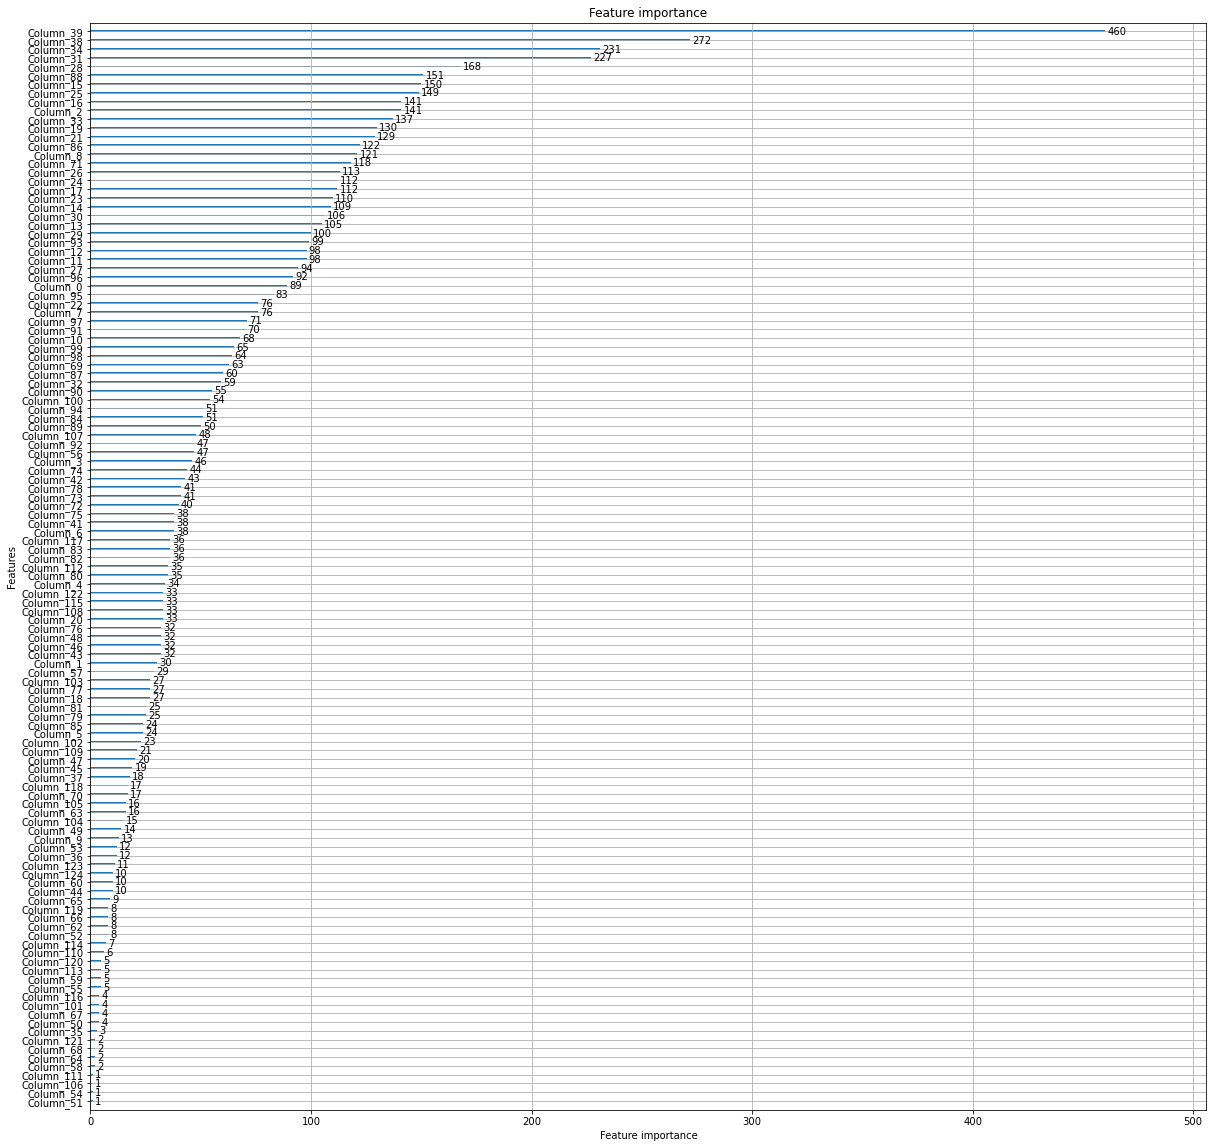

In [107]:
import lightgbm as lgb
lgb.plot_importance(clf, figsize=(20,20))

In [108]:
clf.score(X,y)

0.8377804793232428

In [109]:
expected_y  = labels[:120492]
predicted_y = clf.predict(data[:120492])



In [110]:
clf.score(data[:120492], labels[:120492])

-1.1836106441577394

In [111]:
from sklearn.metrics import accuracy_score

RMSE = mean_squared_error (expected_y, predicted_y, squared=False) #squared to False will calculate RMSE
print('Test Root Mean Squared Error: {:.3f}'.format(RMSE))

r2_regular = clf.score(data[:120492], labels[:120492])

print(r2_regular)

Test Root Mean Squared Error: 0.333
-1.1836106441577394


In [112]:
predictions1 = torch.from_numpy(predicted_y)
tfm_np = lambda x: x.cpu().numpy()
predictions1 = tfm_np(predictions1)
thresh = optimize_utility_threshold(predictions1, scores= scores[:120492])

In [113]:
test_utility = compute_utility_from_indexes(predictions1, thresh, scores = scores[:120492])
print('Test utility score: {:.3f}'.format(test_utility))

Test utility score: 0.224


In [114]:
pd.DataFrame(data[120492:].numpy())

0     1          2      3      4     5     6     7    8    9    ...  \
0        0.0   0.0   0.000000    0.0    0.0   0.0   0.0   0.0  0.0  0.0  ...   
1       93.0  92.5   0.000000  110.0   76.0  56.0  22.0   0.0  0.0  0.0  ...   
2       91.0  96.0   0.000000  108.0   84.5  72.0  23.5   0.0  0.0  0.0  ...   
3       93.0  98.0   0.000000  123.0   87.0  61.0  21.0   0.0  0.0  0.0  ...   
4       93.0  95.0   0.000000  110.0   81.0  70.0  20.0   0.0  0.0  0.0  ...   
...      ...   ...        ...    ...    ...   ...   ...   ...  ...  ...  ...   
121664  46.0  97.0  37.299999  156.0  110.0  89.0  20.0  45.0  0.0  0.0  ...   
121665  46.0  98.0  37.299999  145.0  104.0  87.0  20.0  45.0  0.0  0.0  ...   
121666  52.0  98.0  37.299999  123.0   93.0  78.0  20.0  45.0  0.0  0.0  ...   
121667  64.0  97.0  37.299999  103.0   78.0  68.0  20.0  45.0  0.0  0.0  ...   
121668  64.0  99.0  37.299999  111.0   97.0  68.0  20.0  45.0  0.0  0.0  ...   

         115   116      117         118         119   120   121      122  \
0        0.0   0.0    0.000    0.000000    0.000000   0.0   0.0    0.000   
1        0.0   0.0    0.000    0.000000    0.000000   0.0   0.0    0.000   
2        0.0   0.0    0.000    0.000000    0.000000   0.0   0.0    0.000   
3        0.0   0.0    0.000    0.000000    0.000000   0.0   0.0    0.000   
4        0.0   0.0    0.000    0.000000    0.000000   0.0   0.0    0.000   
...      ...   ...      ...         ...         ...   ...   ...      ...   
121664 -15.0 -15.0  126.250 -183.187500 -326.187500  36.5  36.5  277.875   
121665 -11.0 -11.0  118.250   14.645813 -513.354187  28.0  28.0  335.250   
121666  -9.0  -9.0  128.250 -718.937500  245.562500  -6.5  -6.5  499.125   
121667  17.5  17.5   95.125  195.114624  127.614624 -39.5 -39.5  614.625   
121668  20.0  20.0   92.000  342.666992  -17.333008 -37.0 -37.0  631.500   

                123          124  
0          0.000000     0.000000  
1          0.000000     0.000000  
2          0.000000     0.000000  
3          0.000000     0.000000  
4          0.000000     0.000000  
...             ...          ...  
121664   392.635742   669.510742  
121665  3378.271484 -2535.353516  
121666  6030.489746 -7287.760254  
121667  3858.050781 -6814.824219  
121668 -1220.083984 -1679.083984  

[121669 rows x 125 columns]

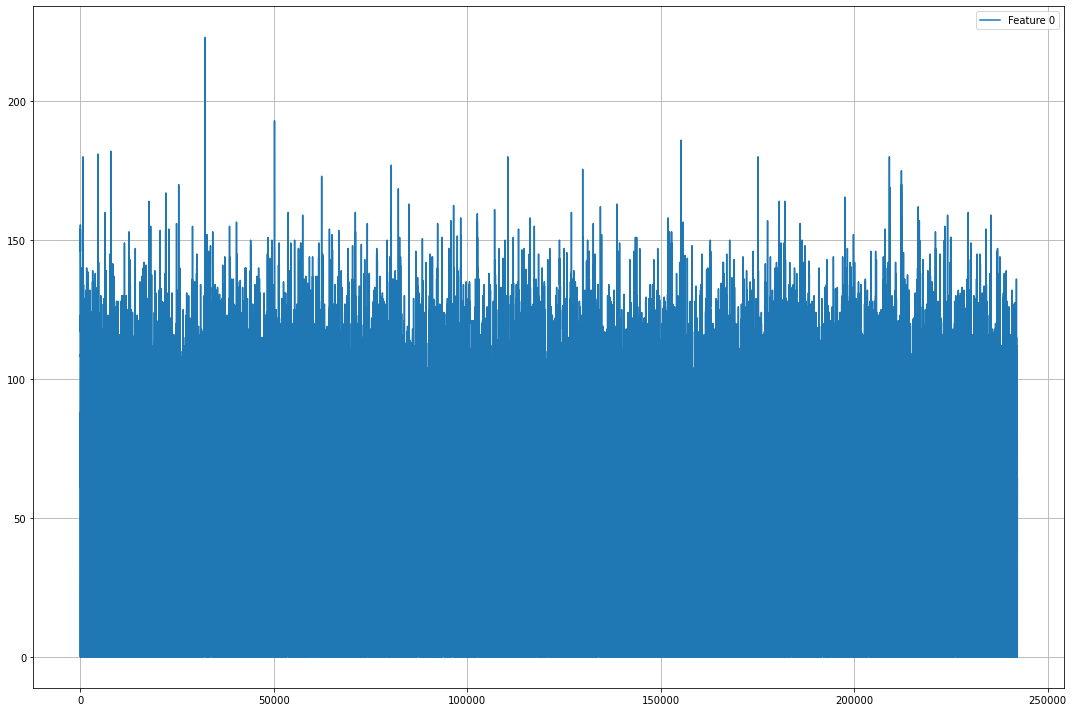

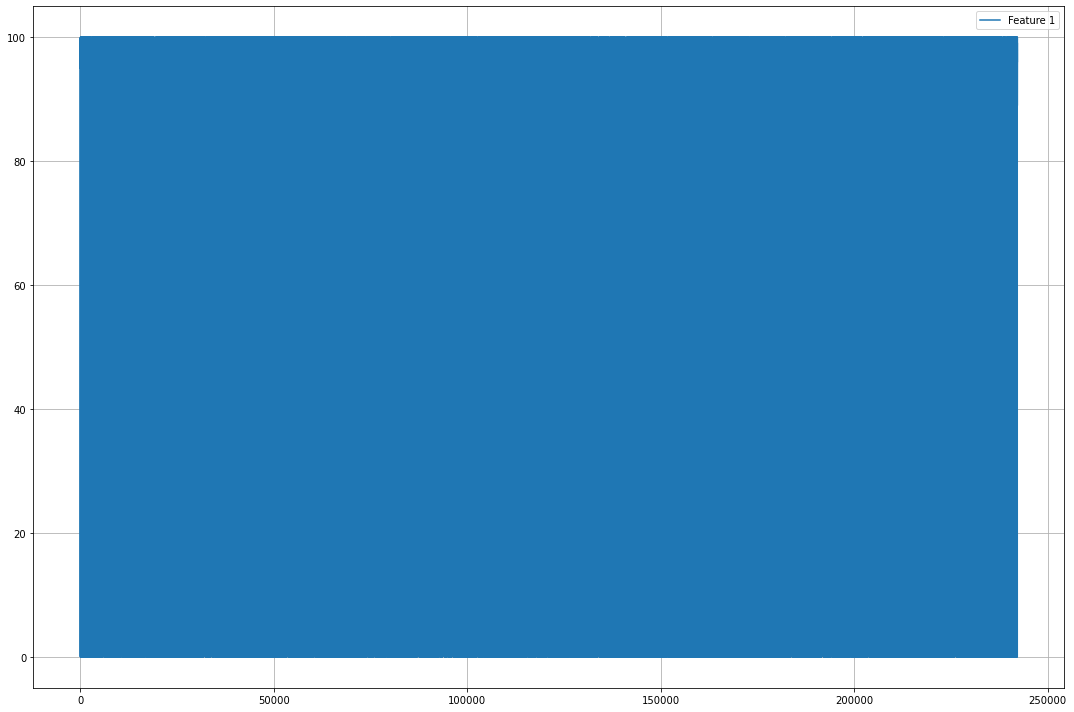

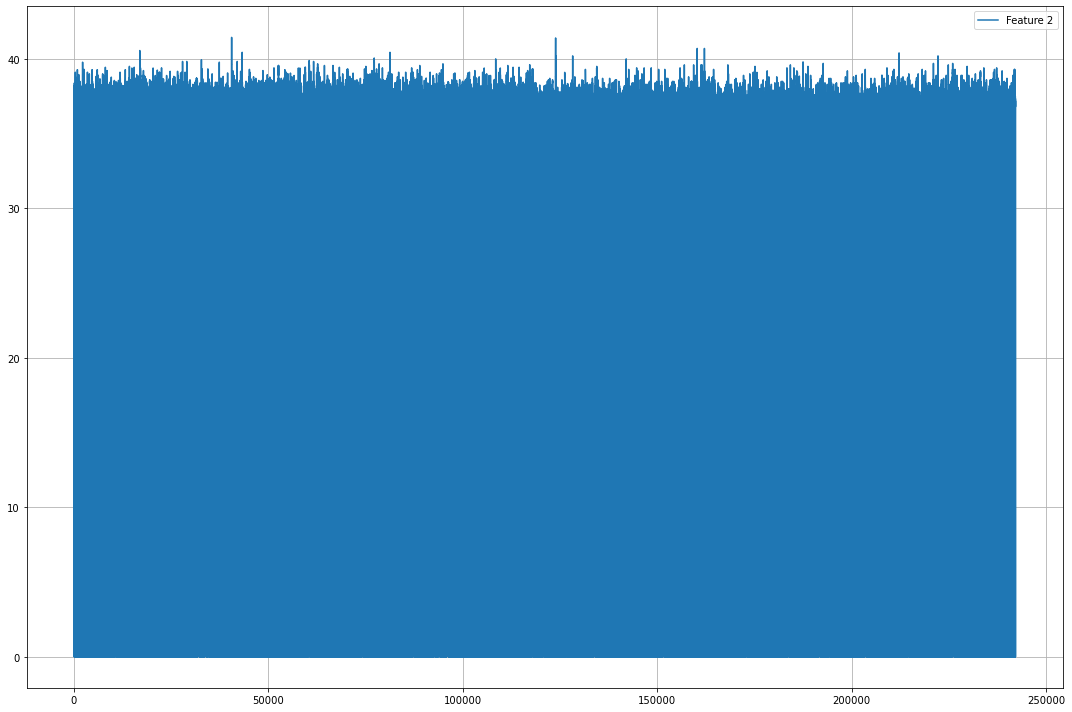

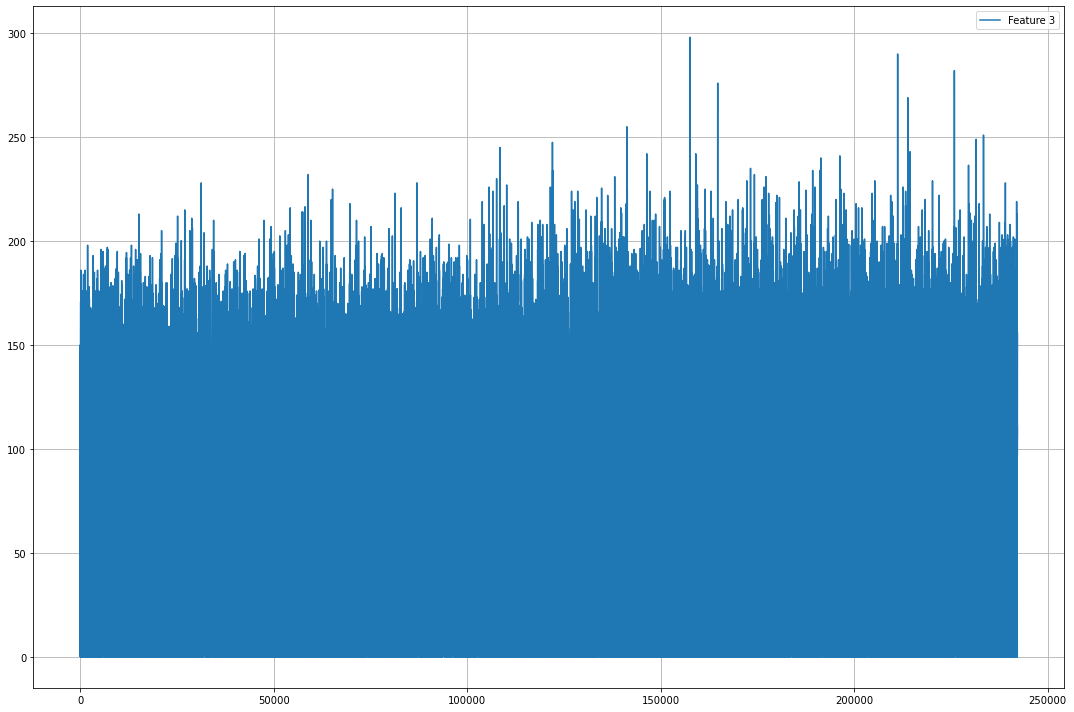

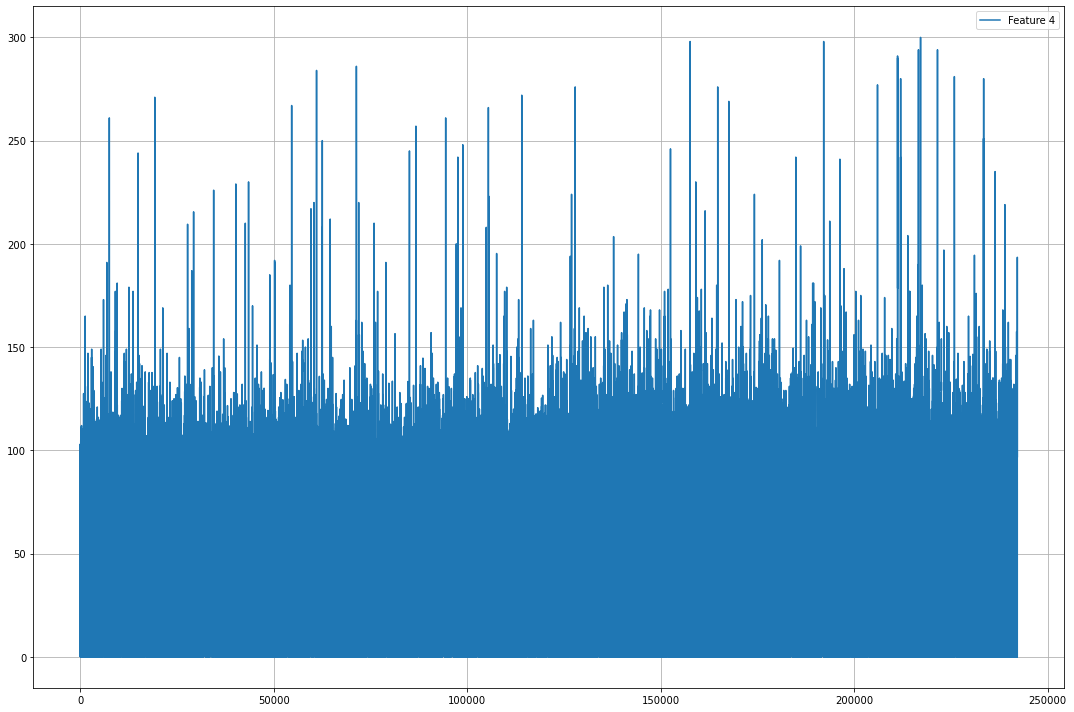

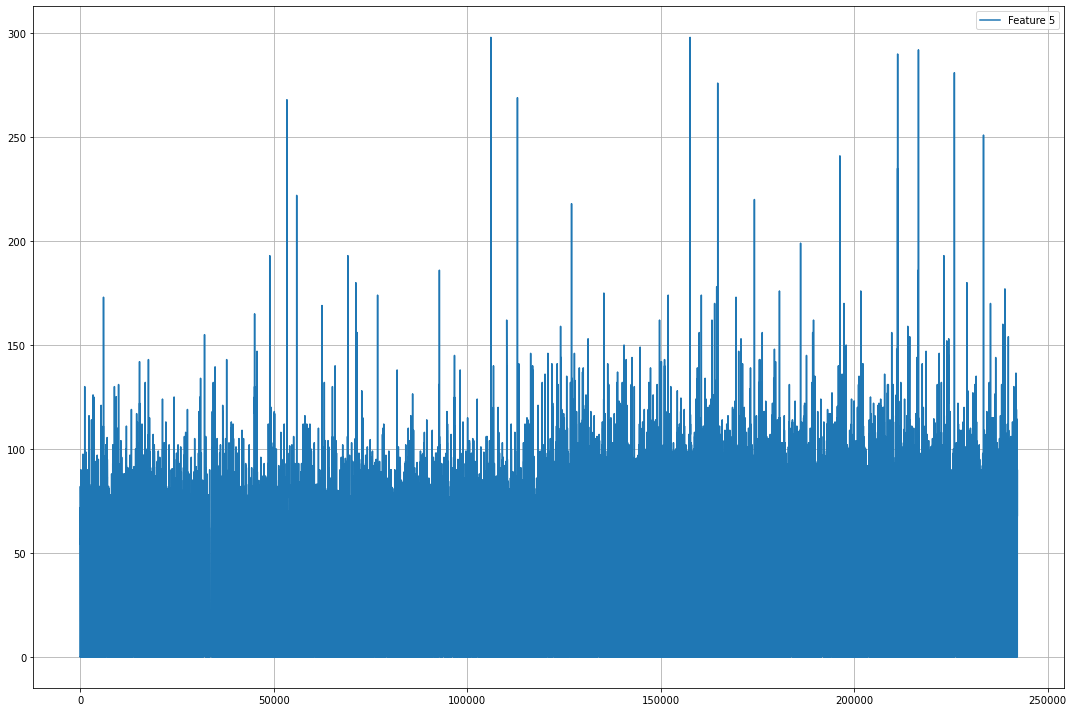

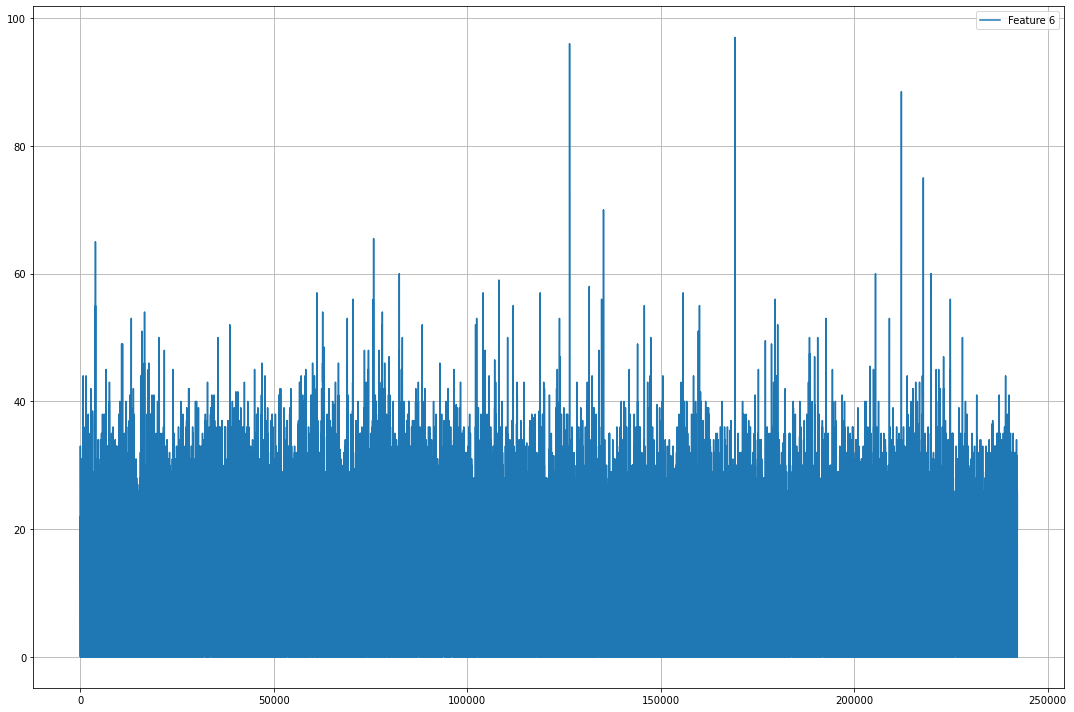

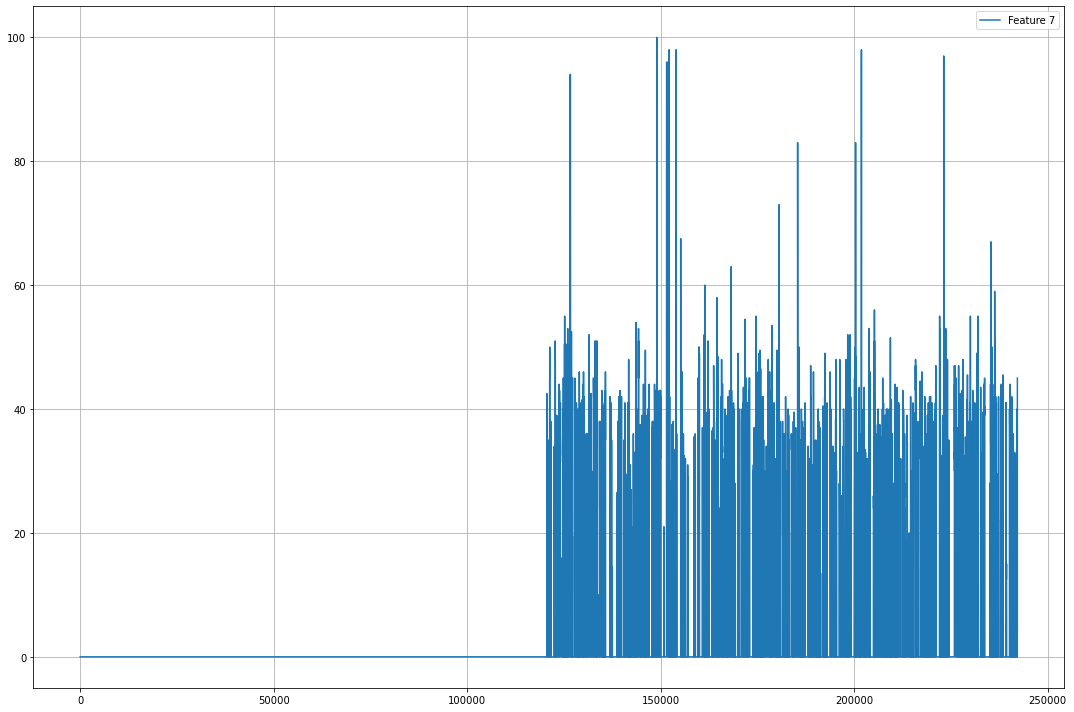

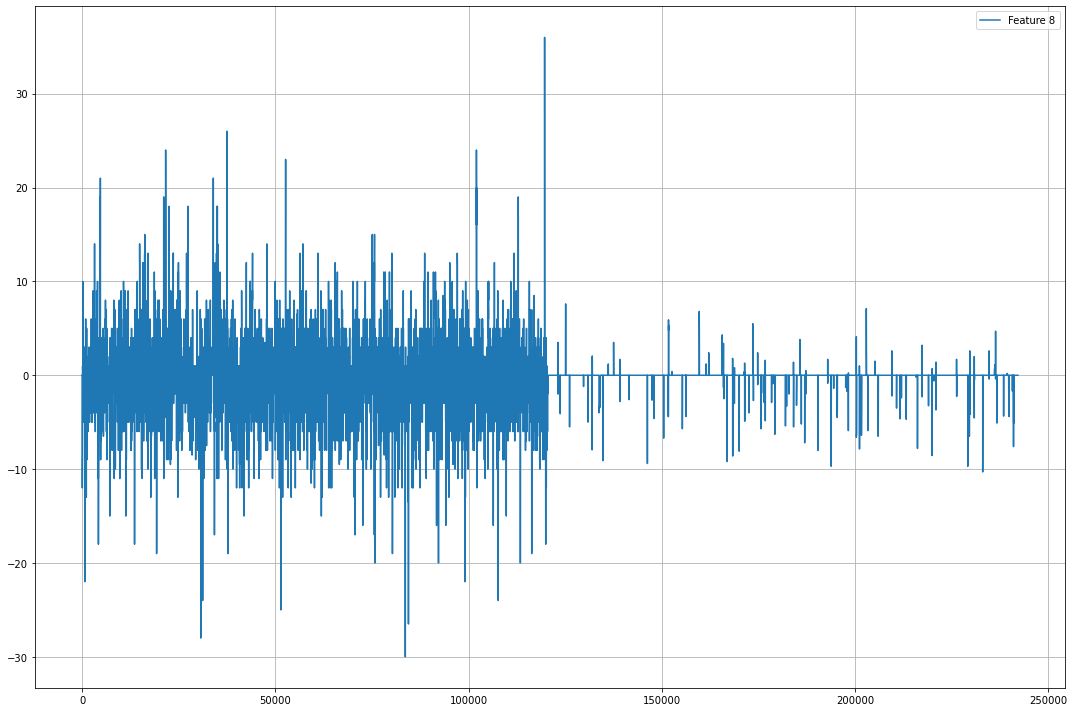

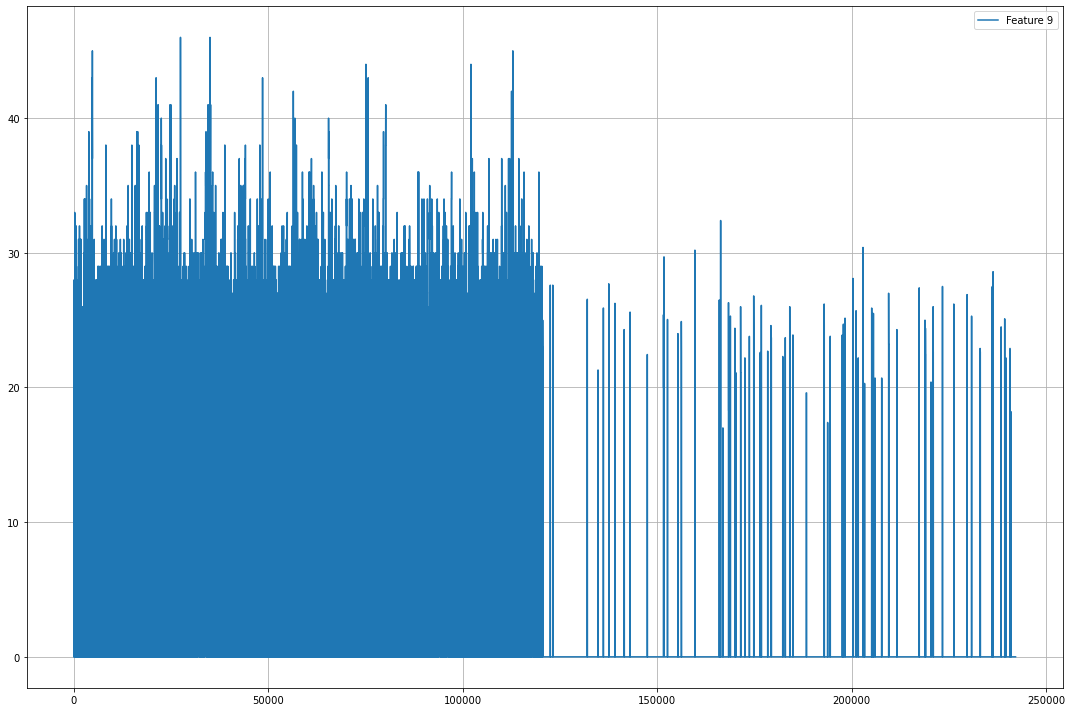

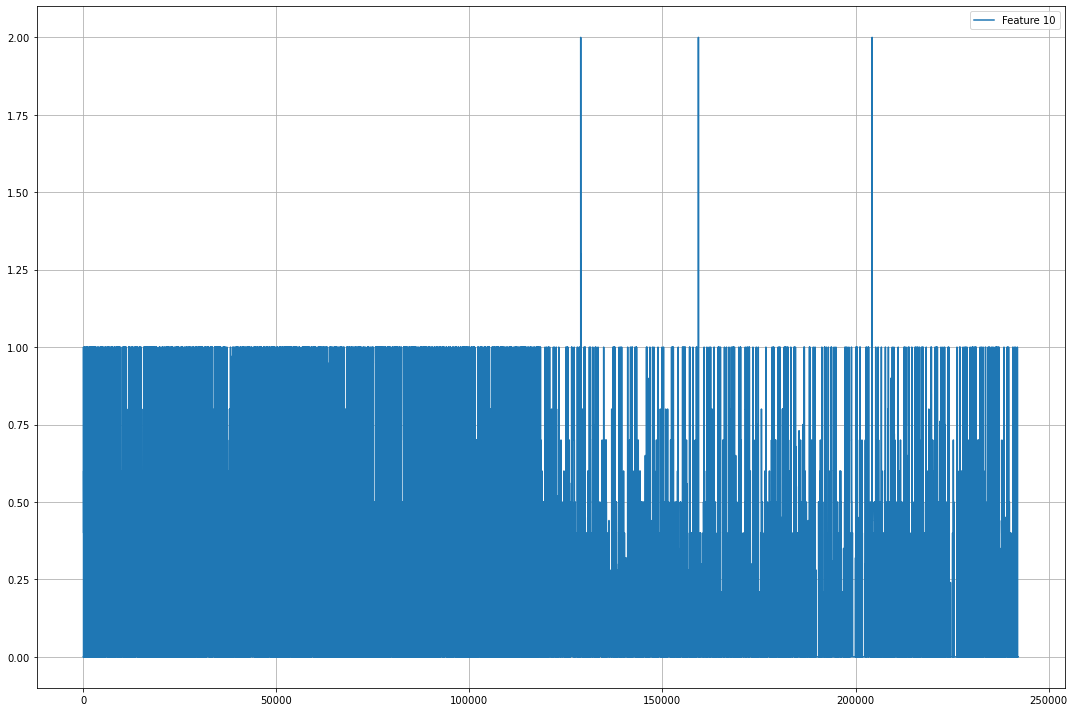

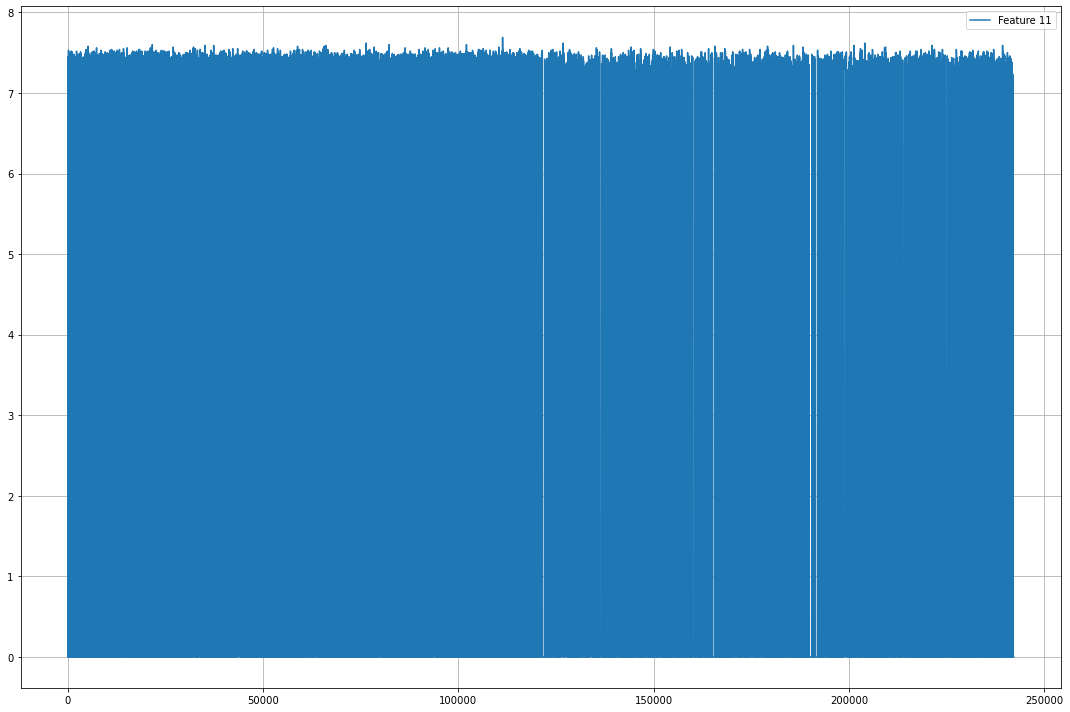

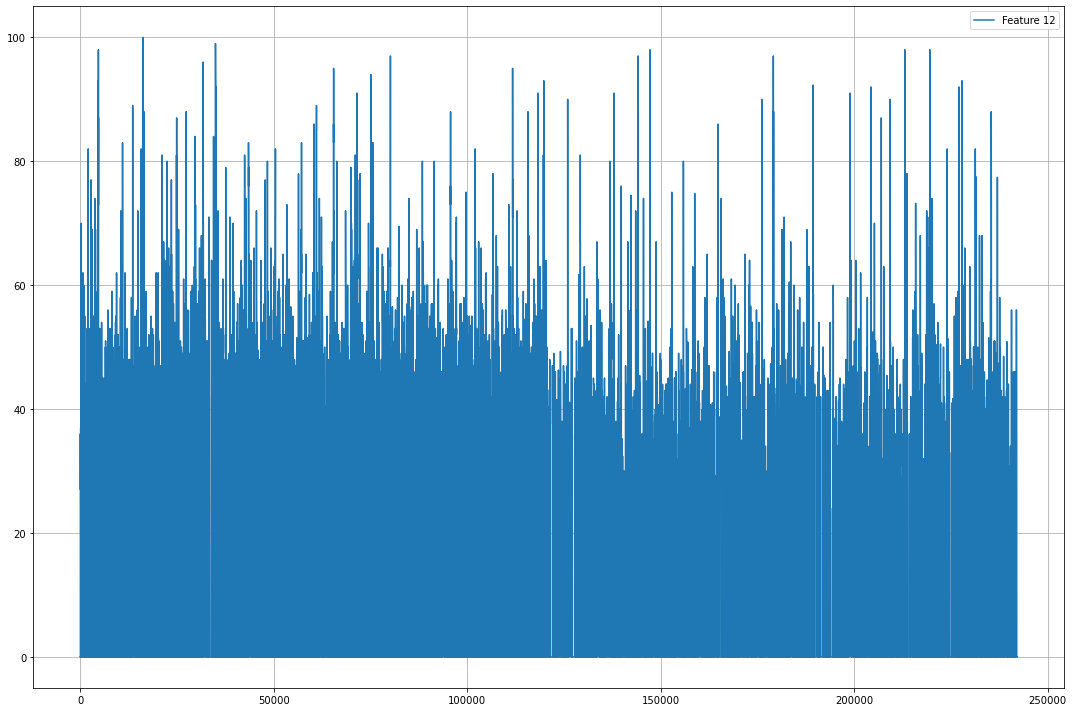

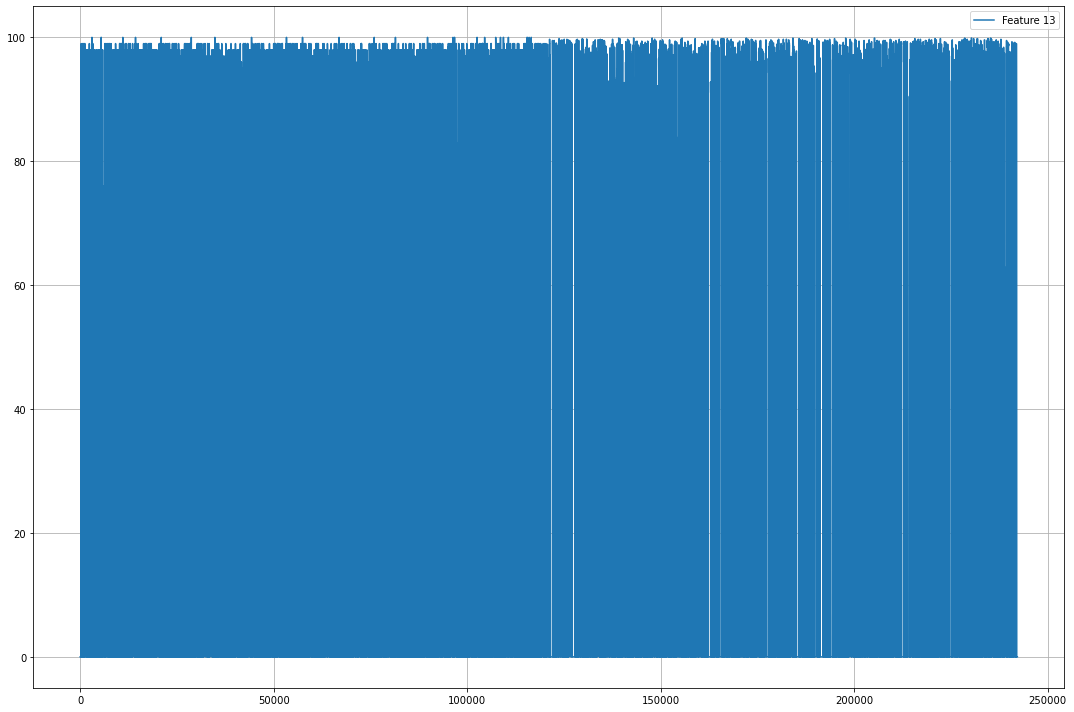

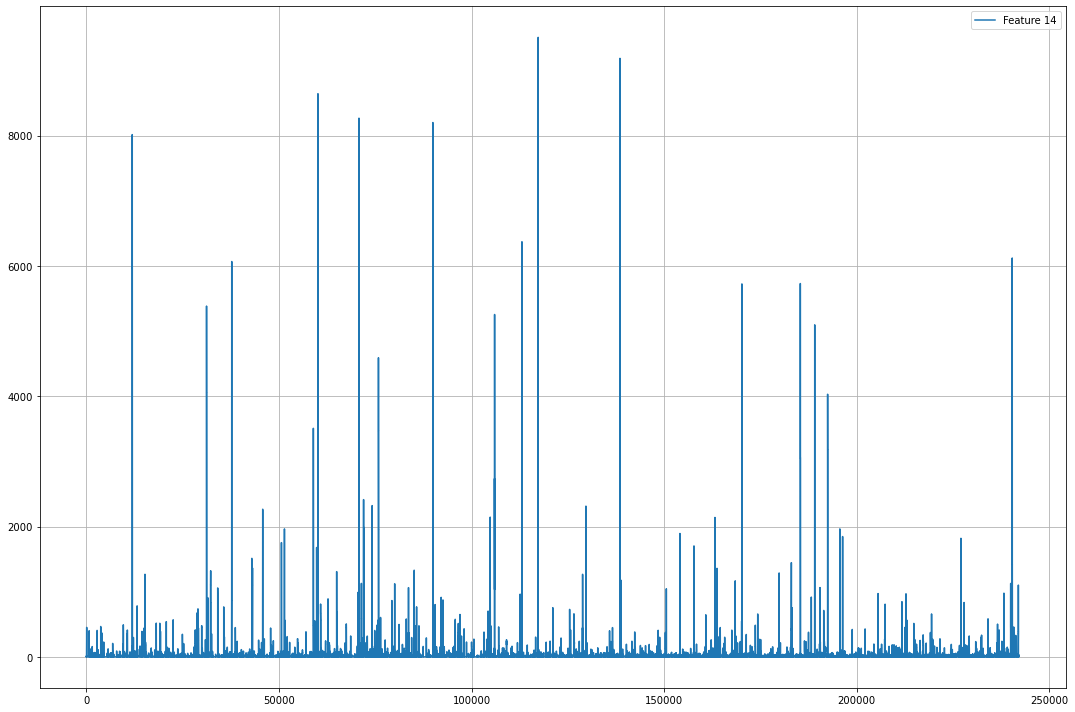

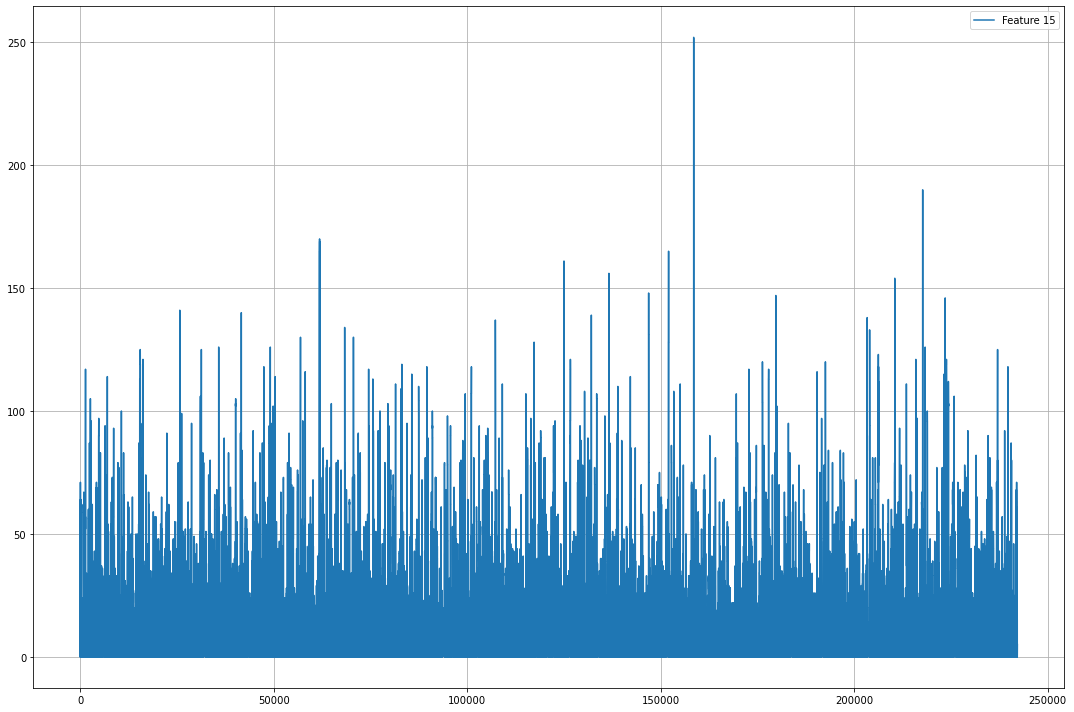

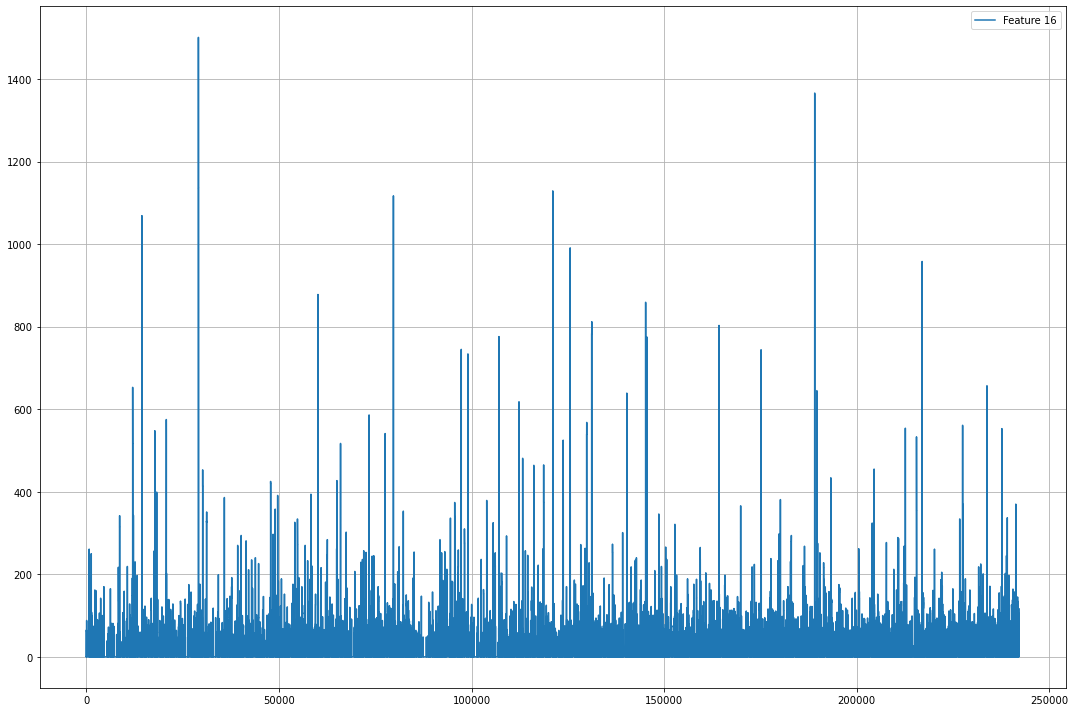

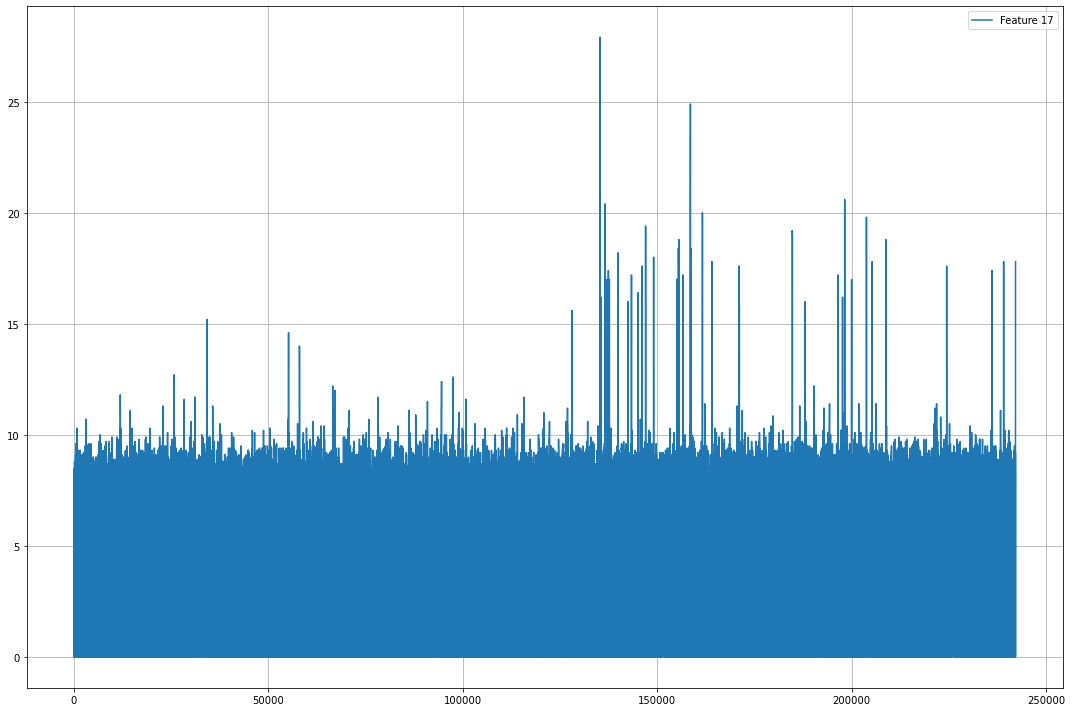

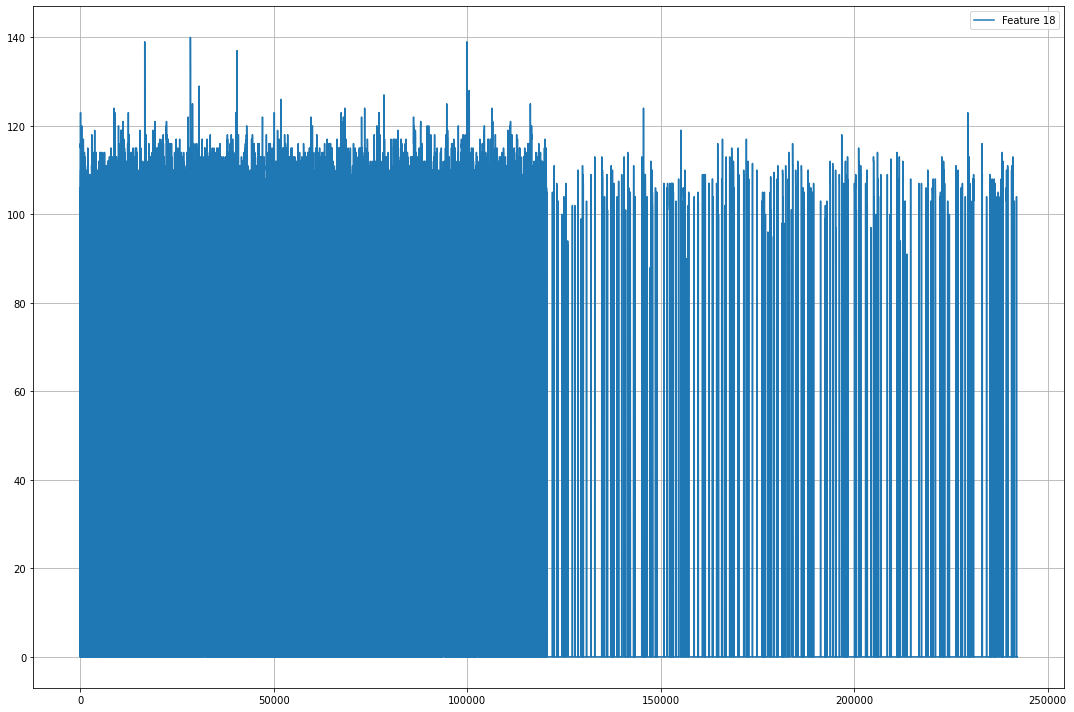

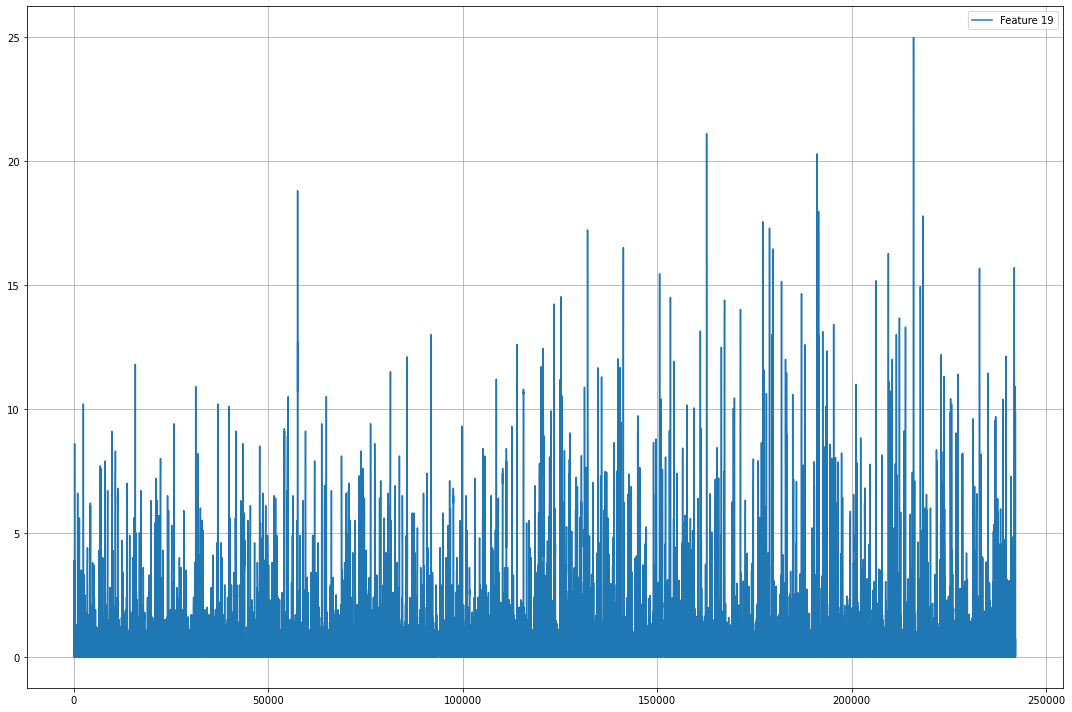

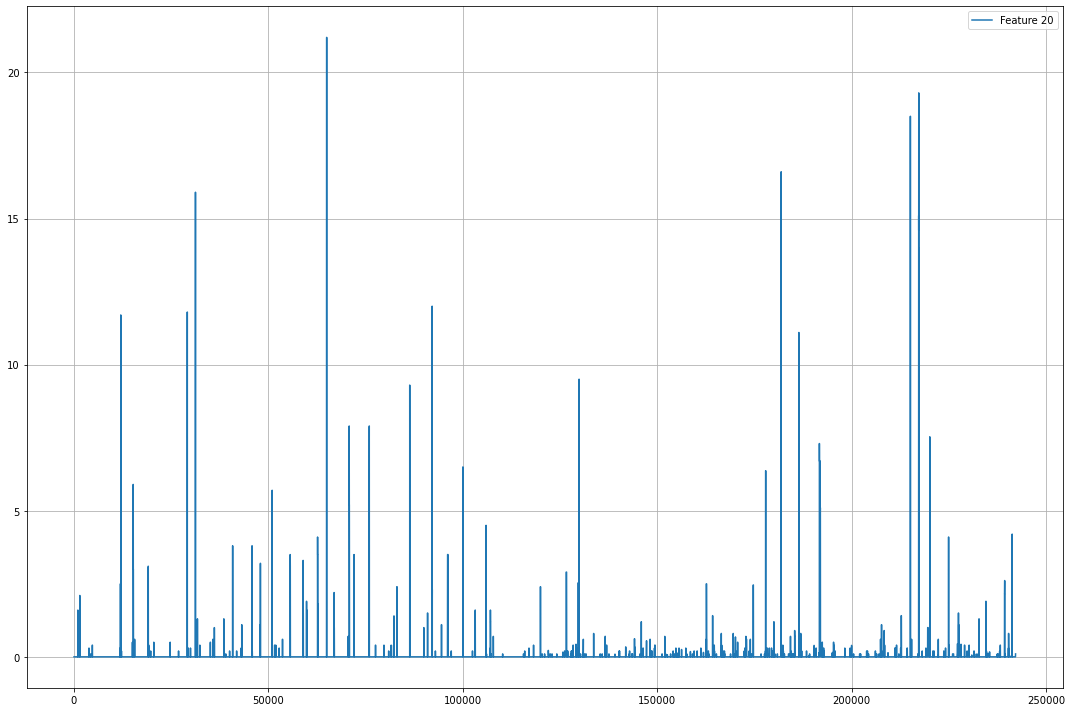

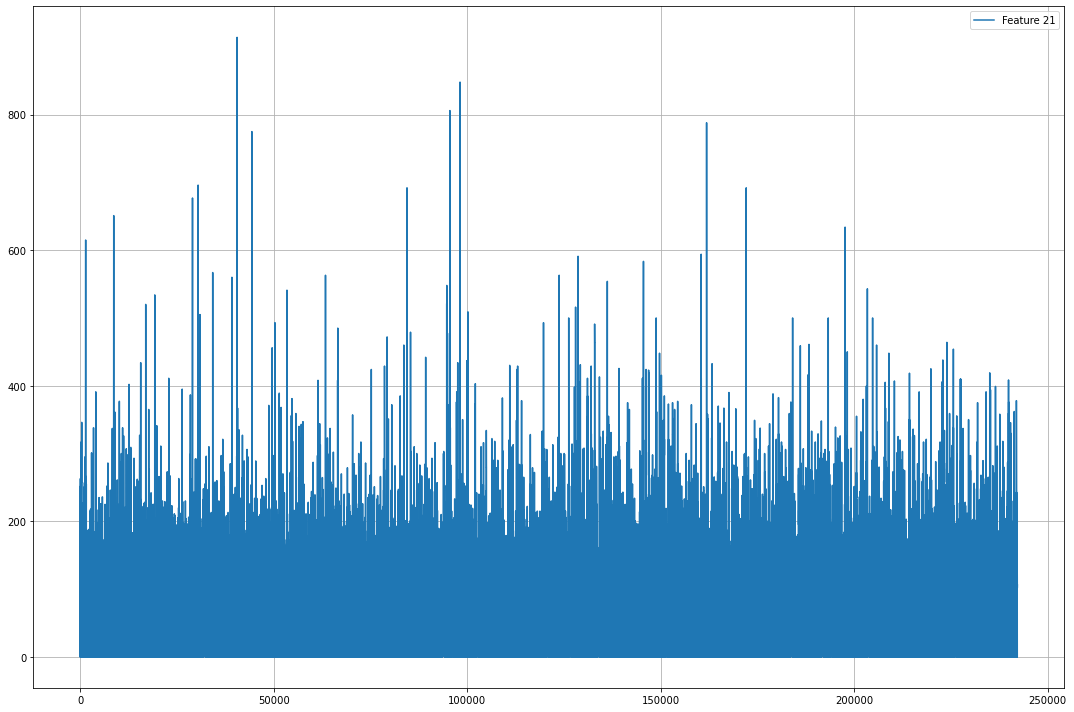

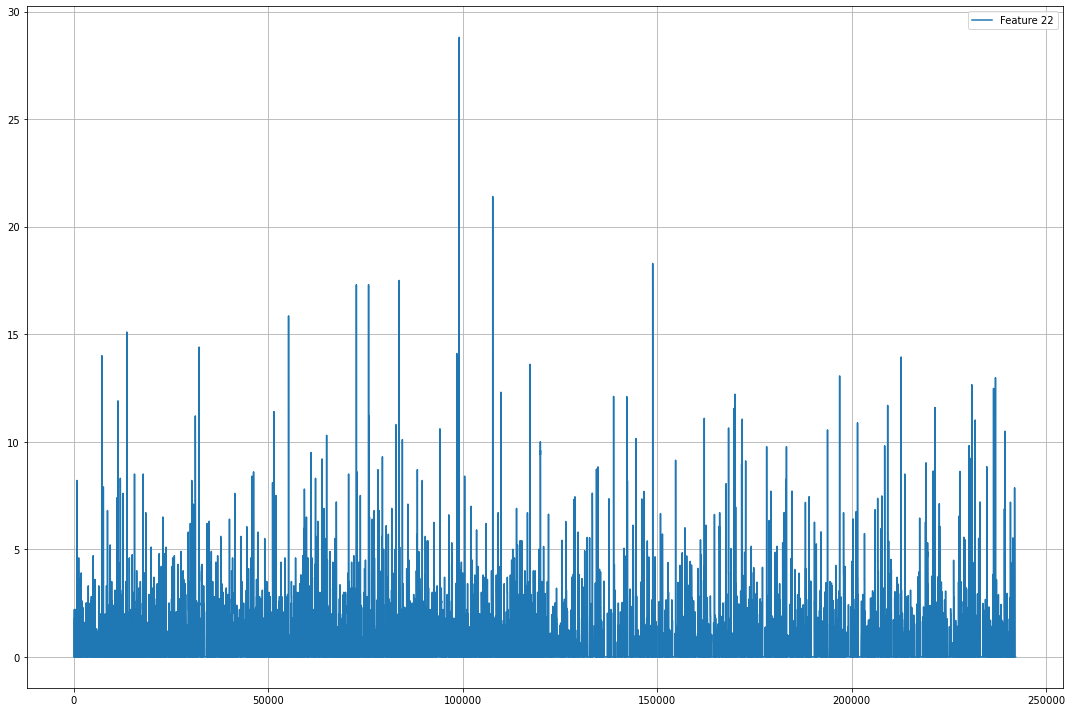

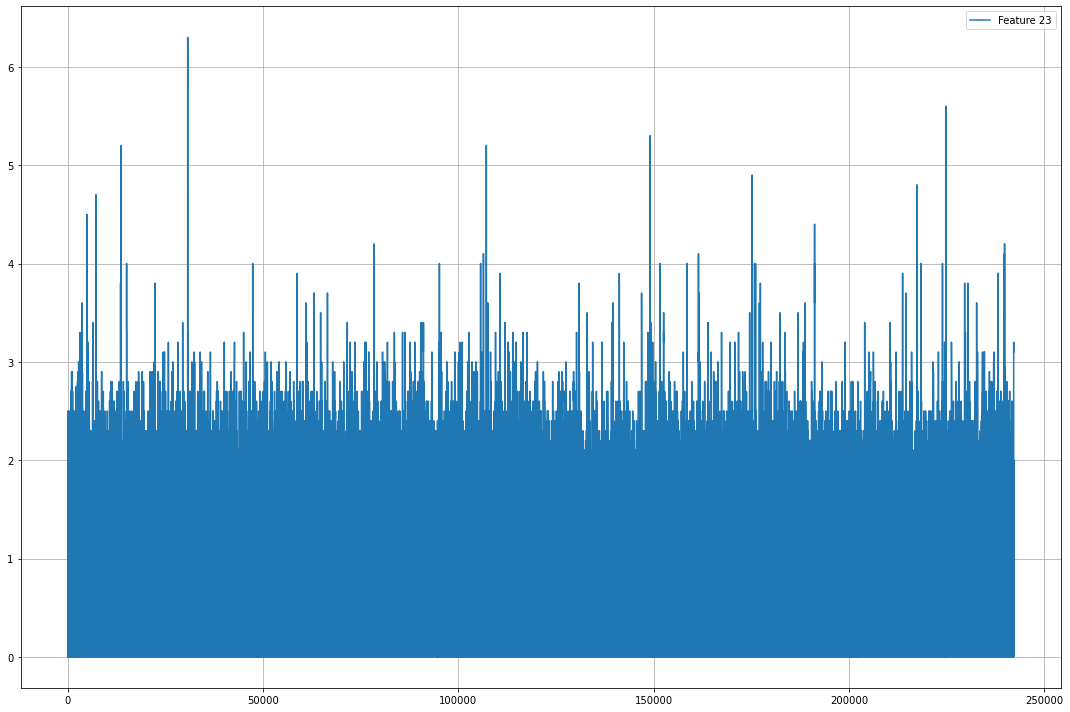

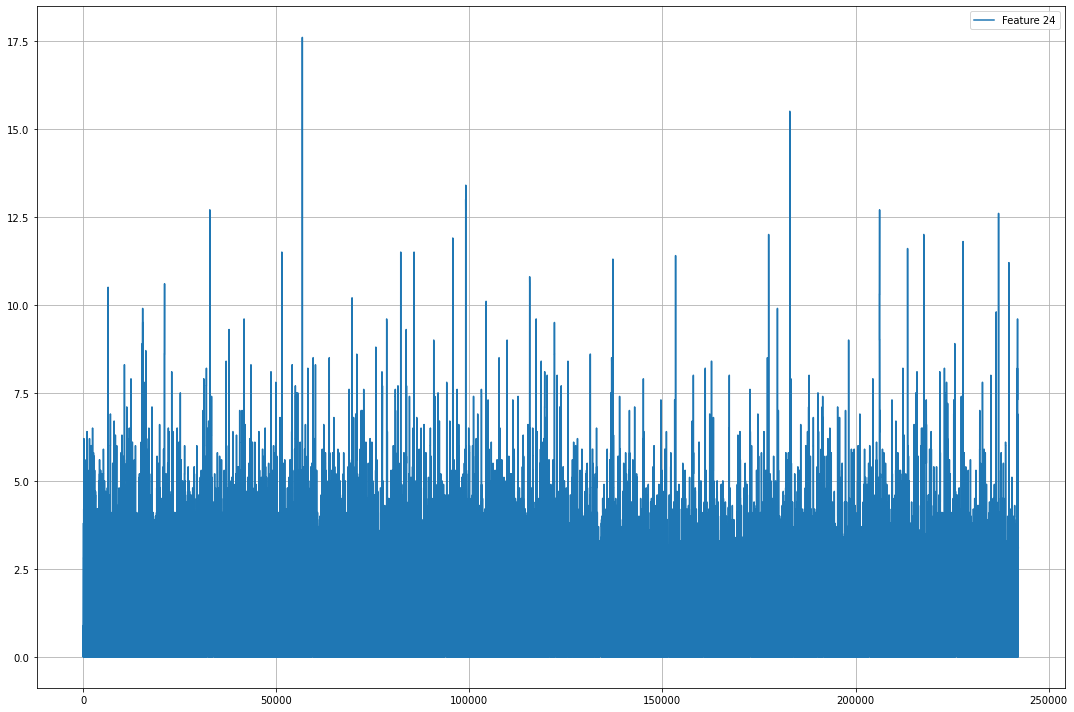

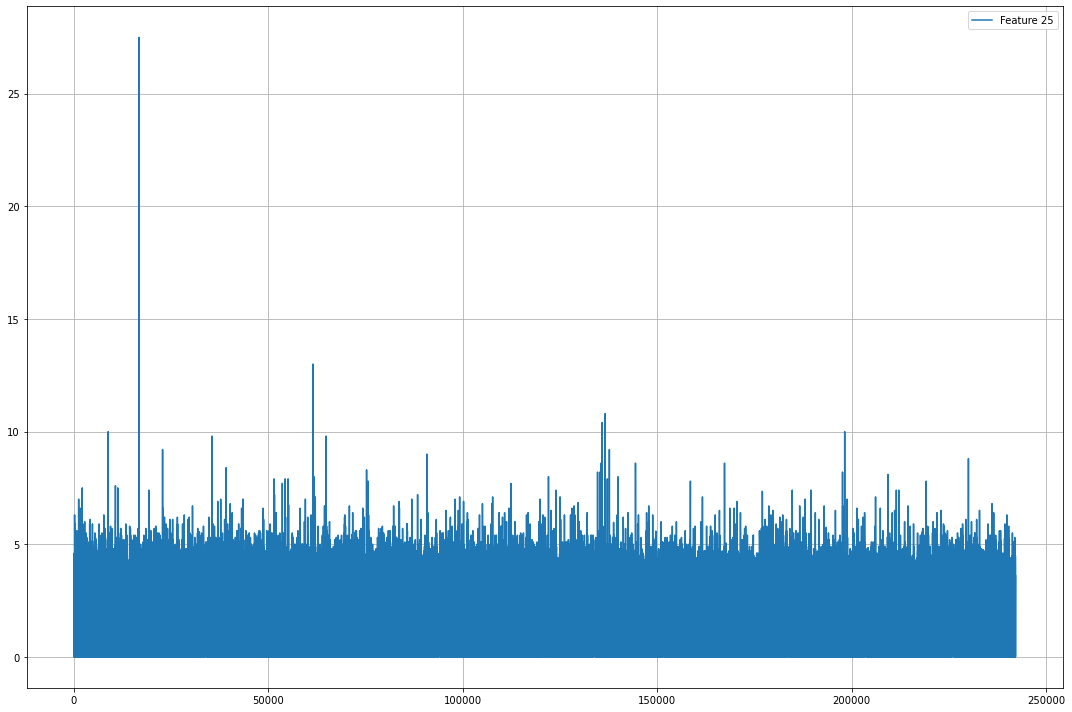

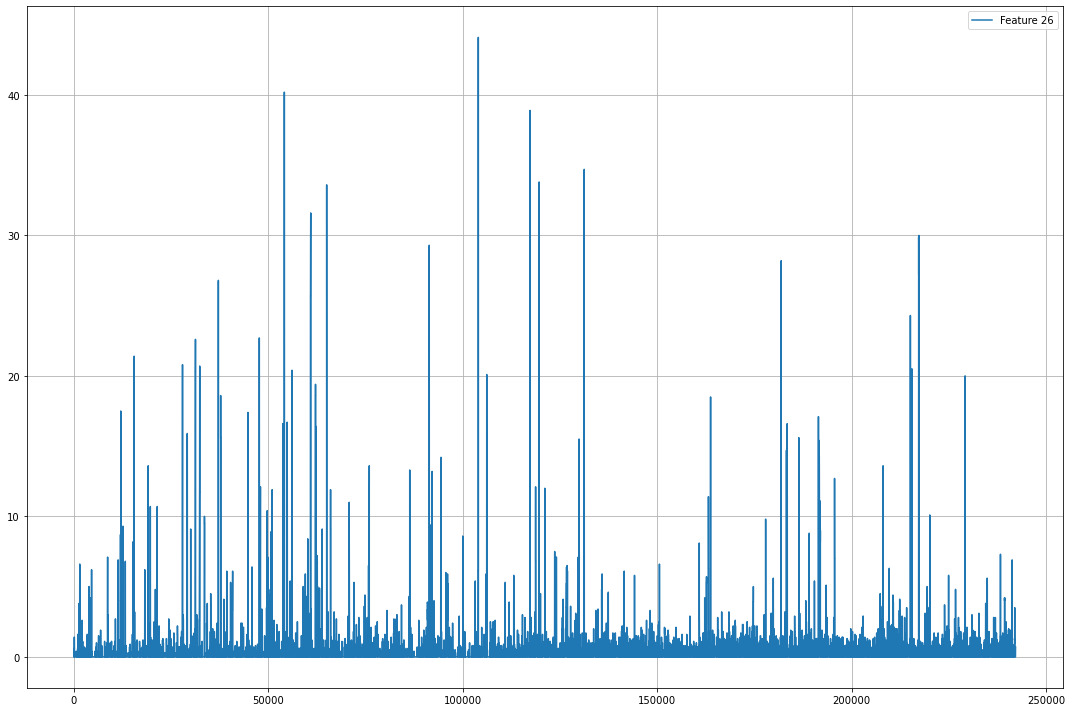

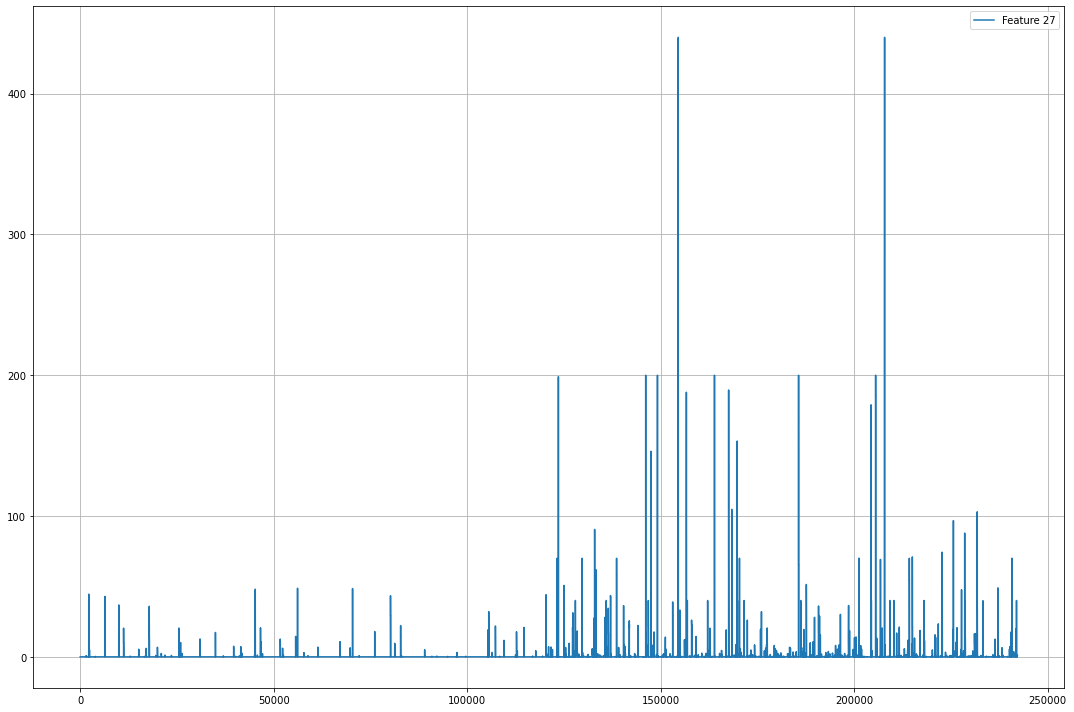

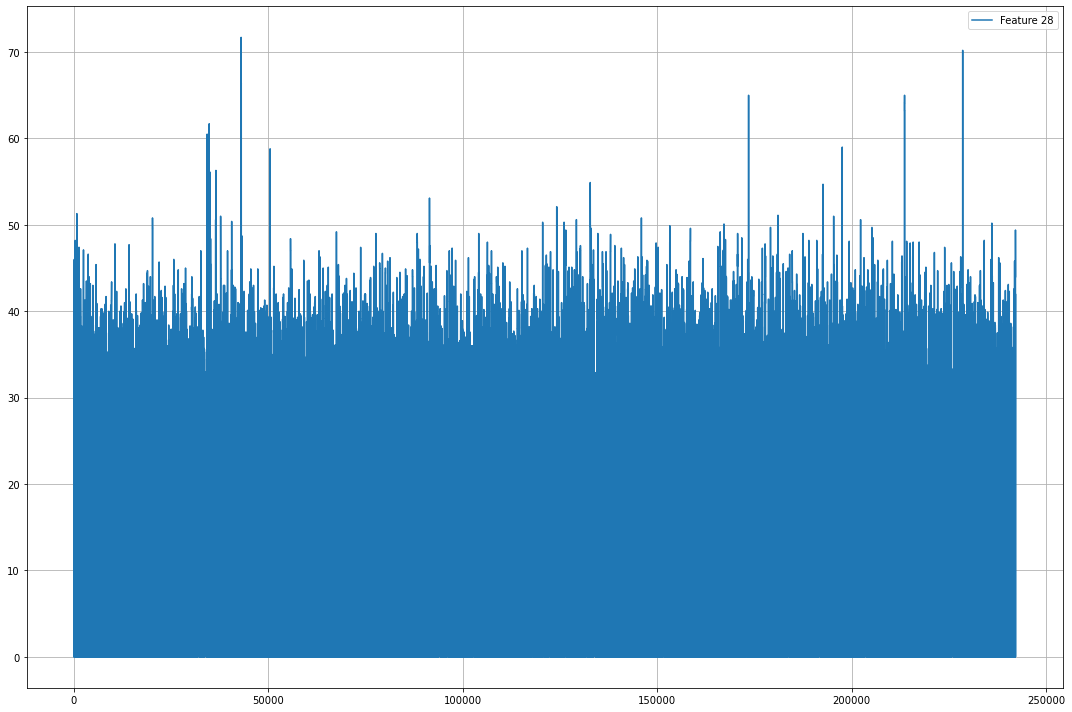

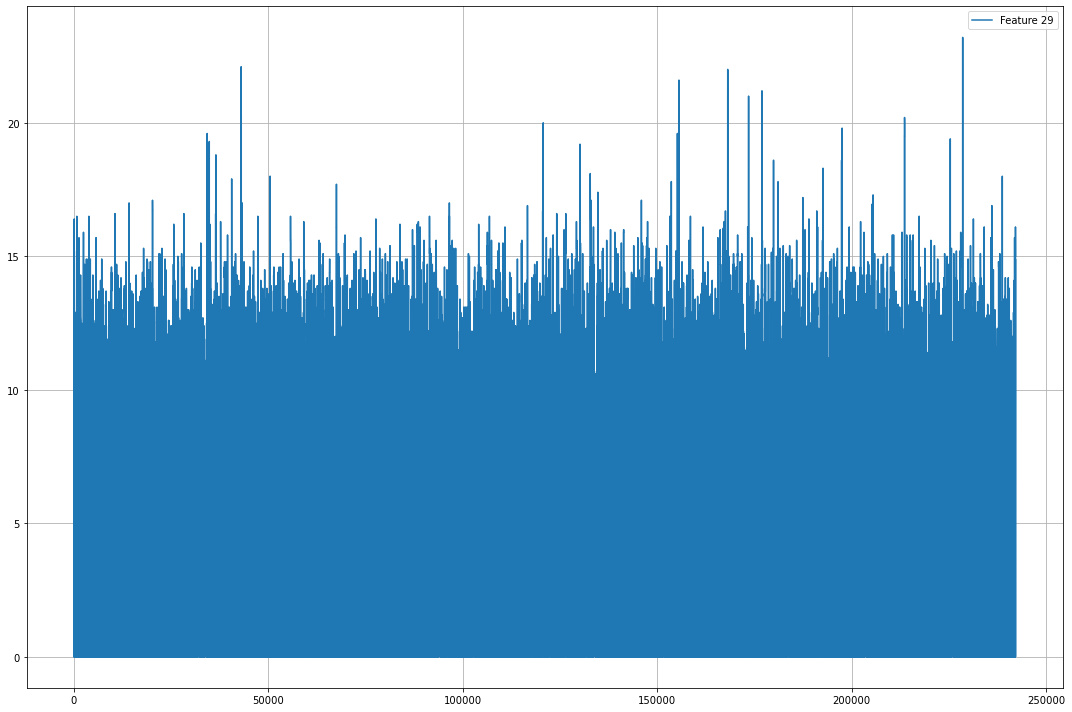

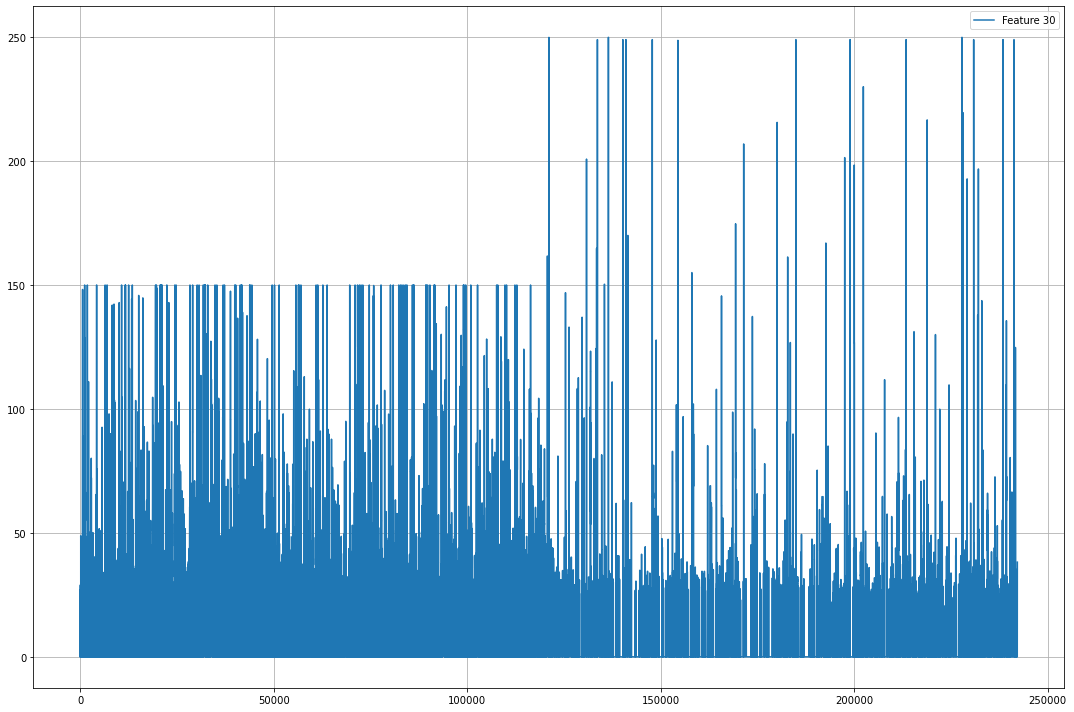

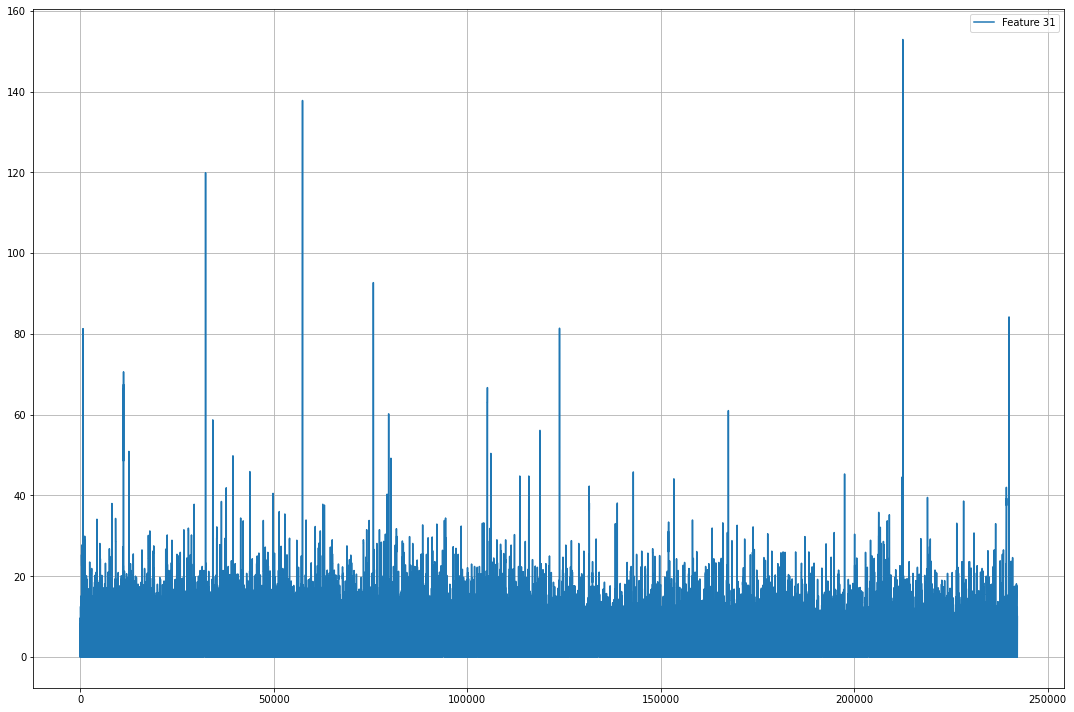

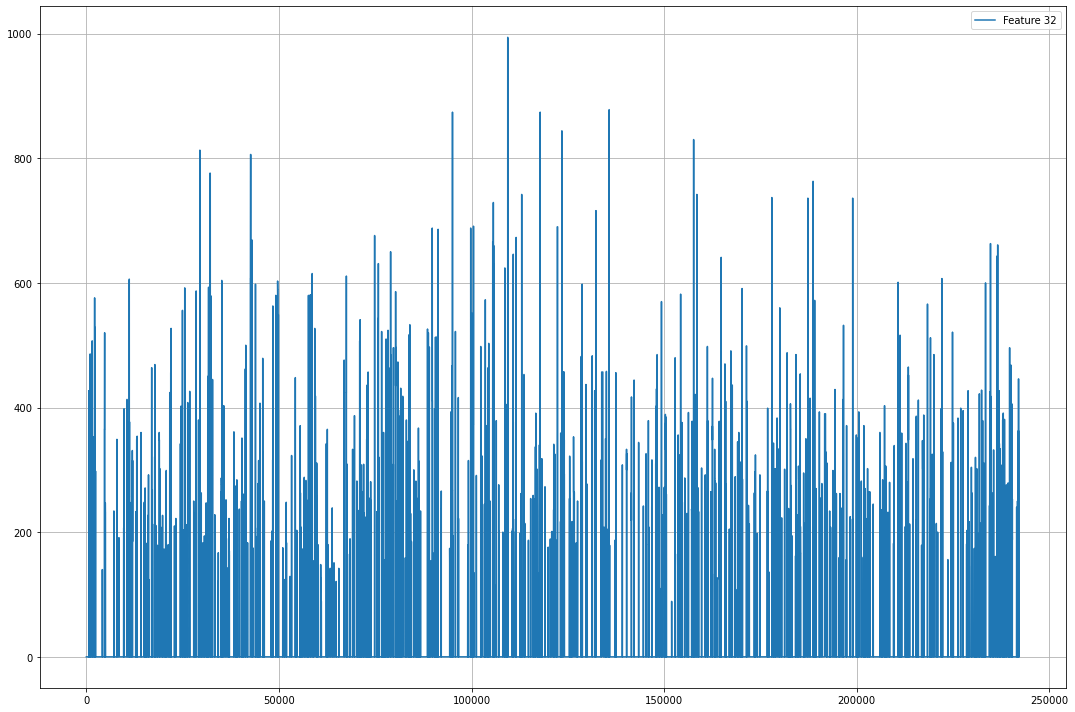

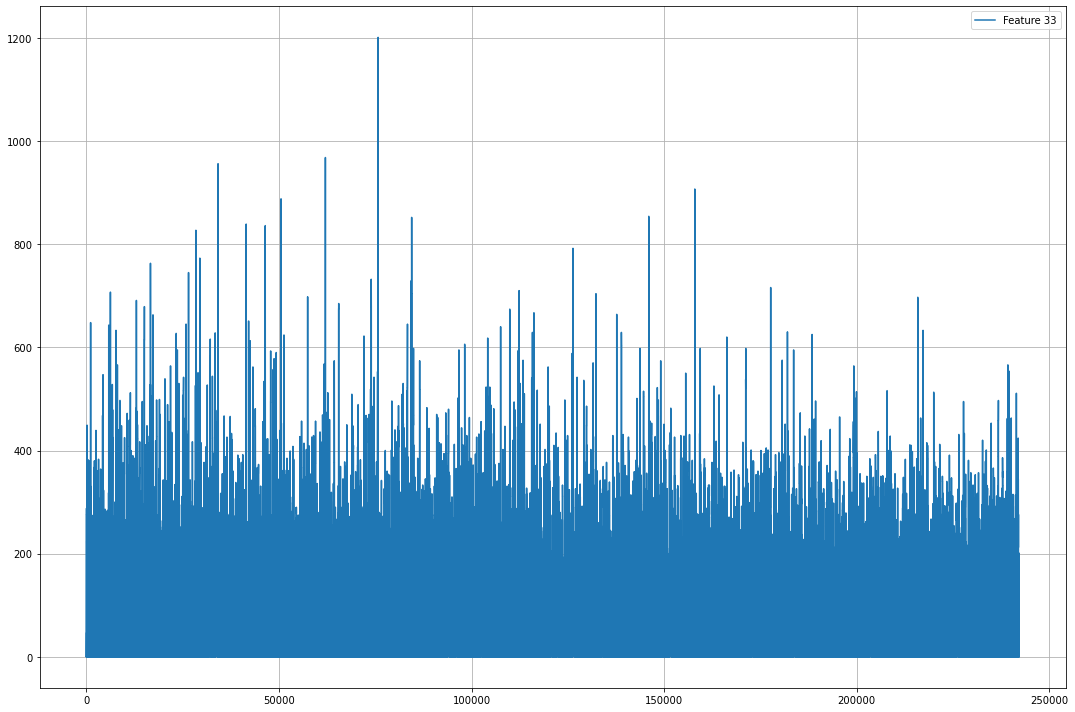

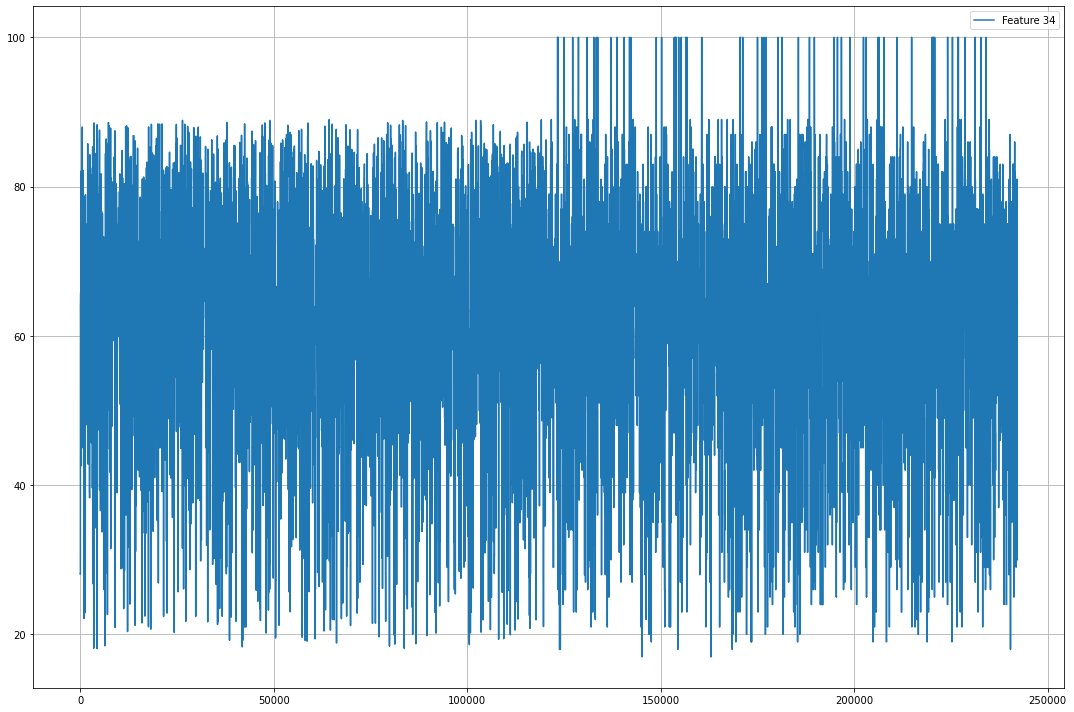

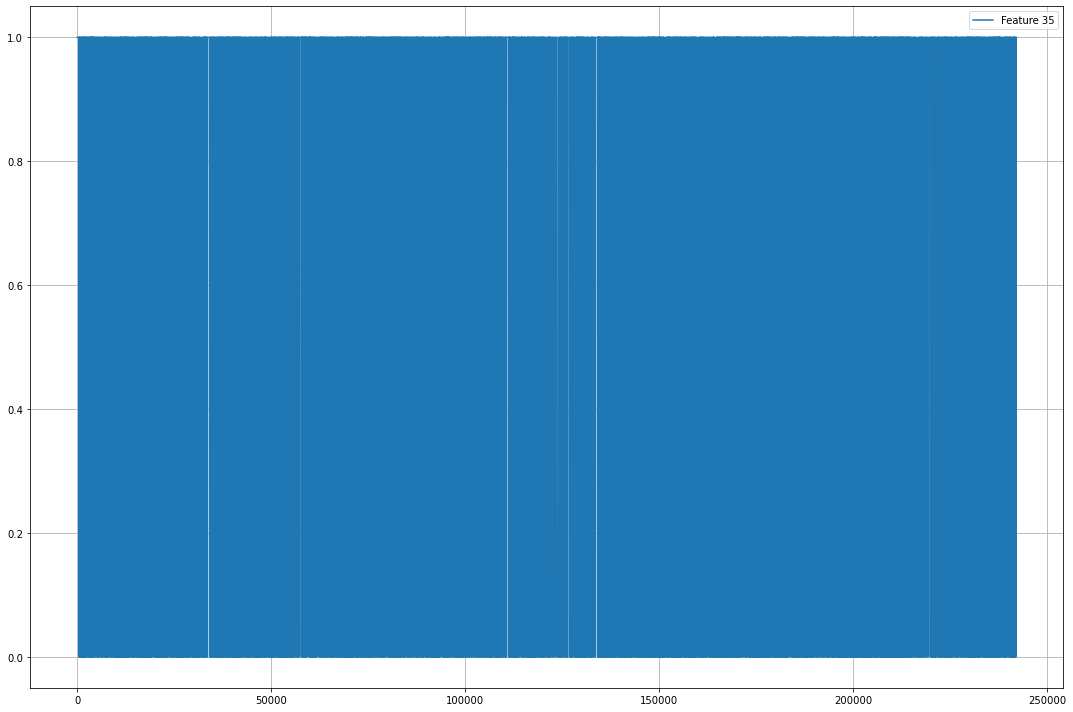

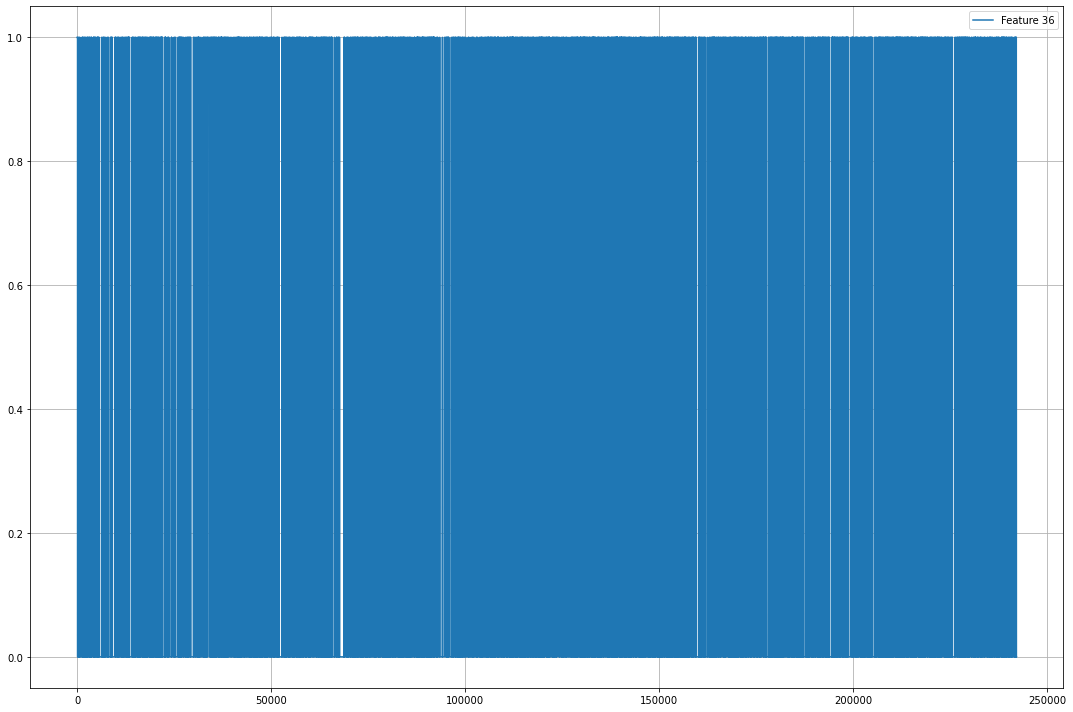

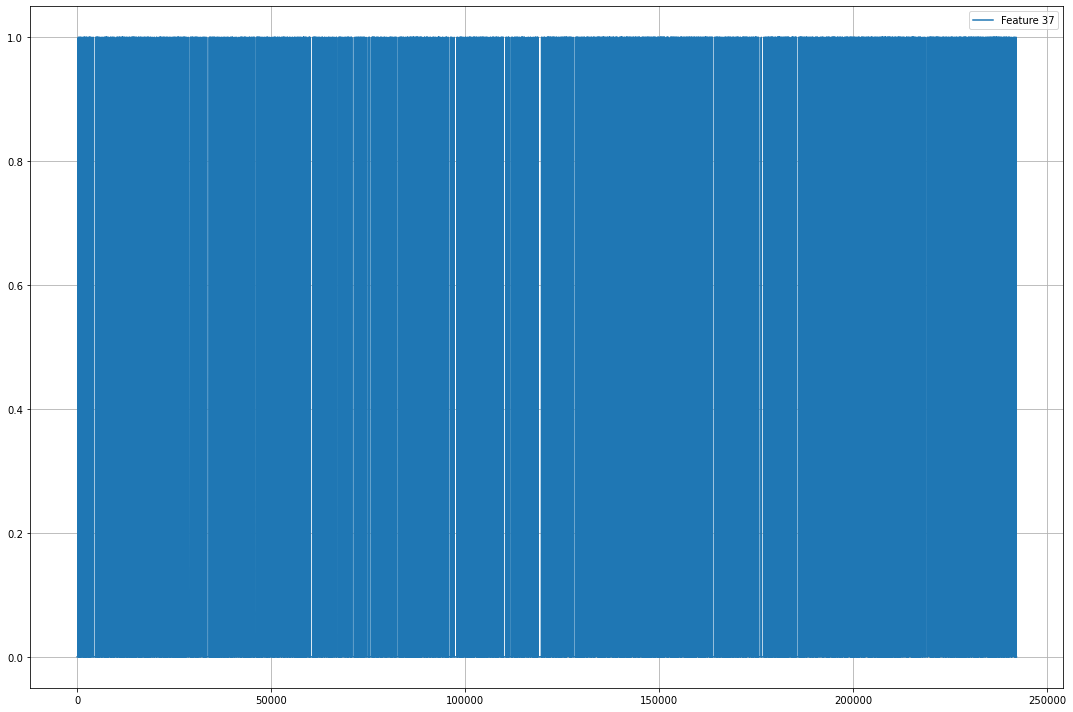

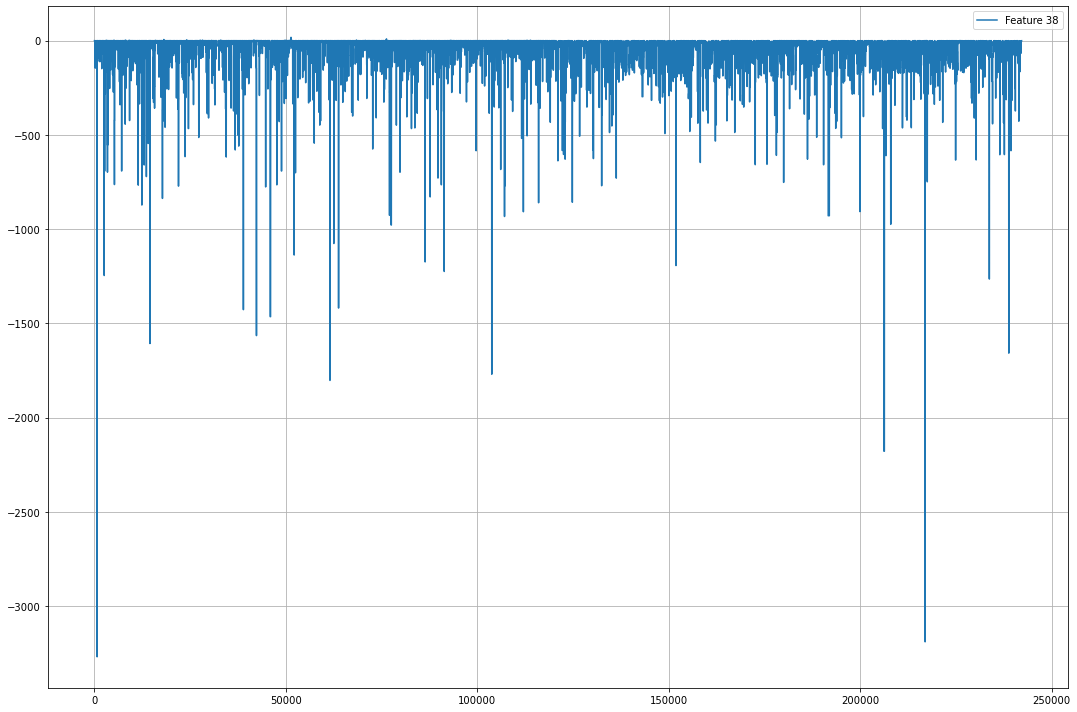

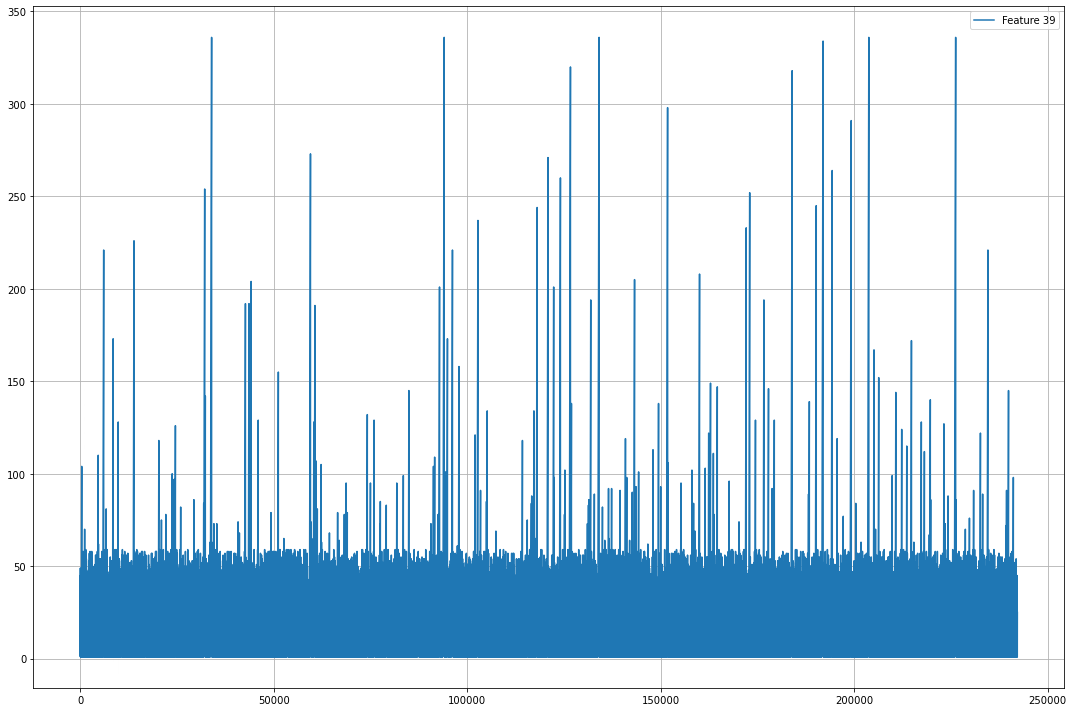

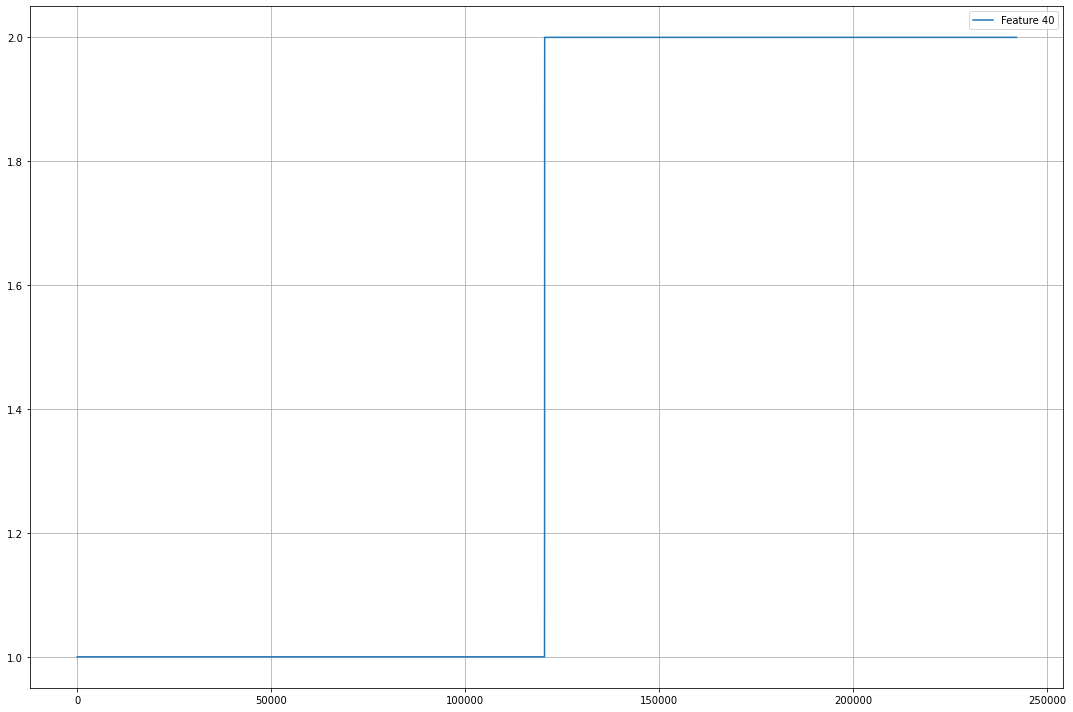

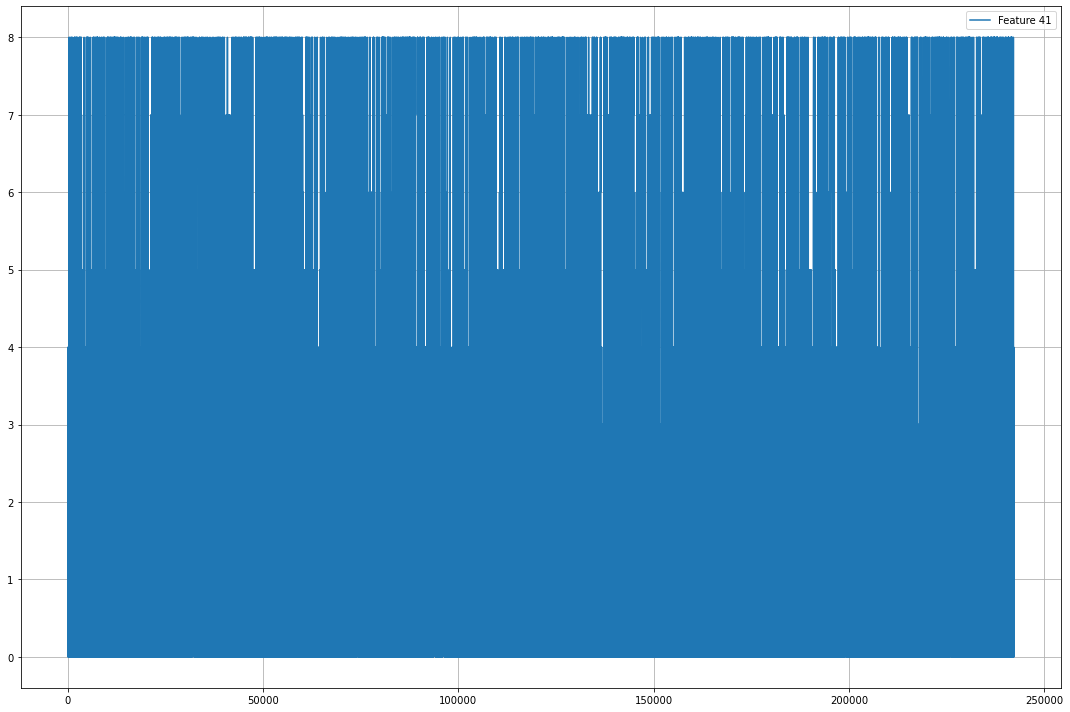

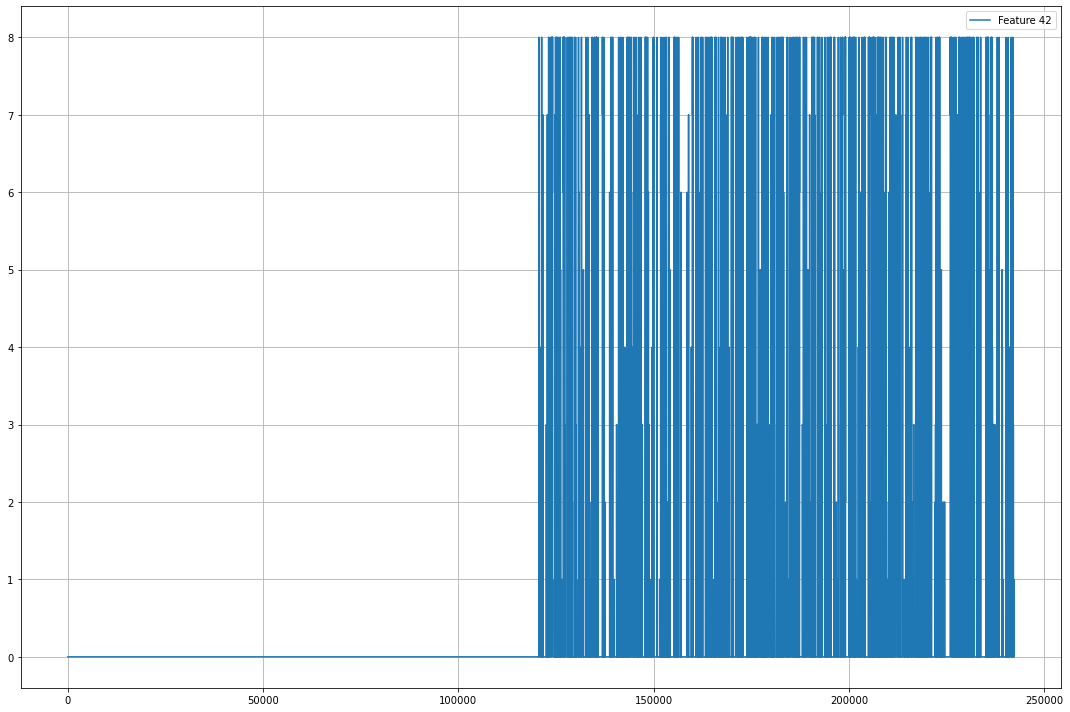

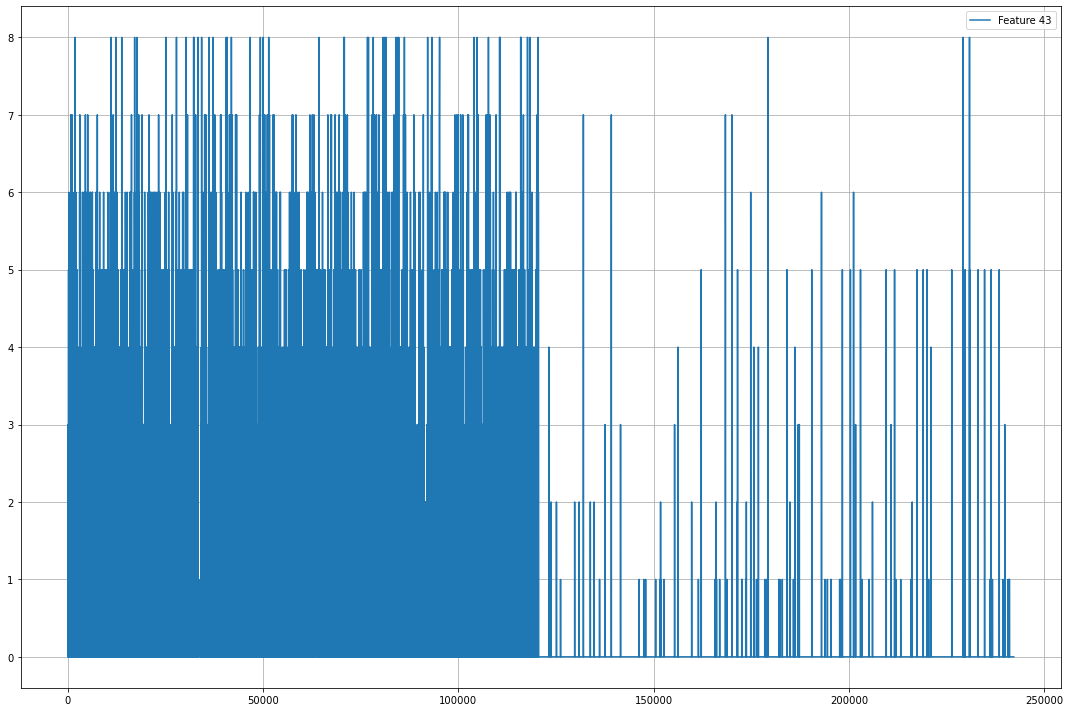

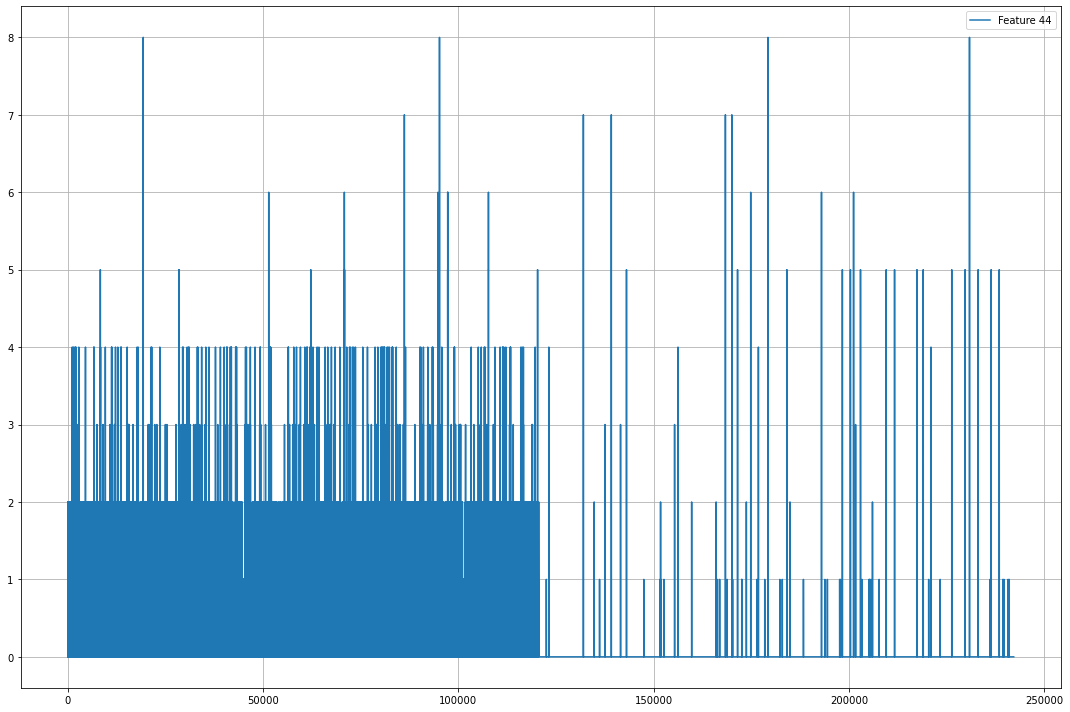

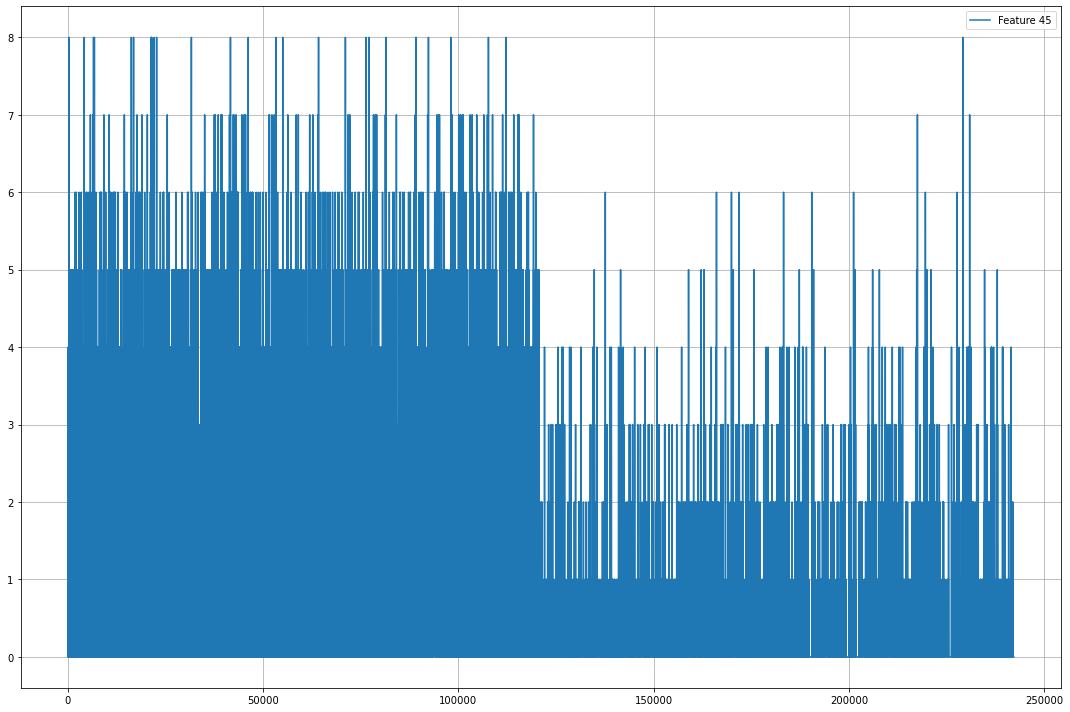

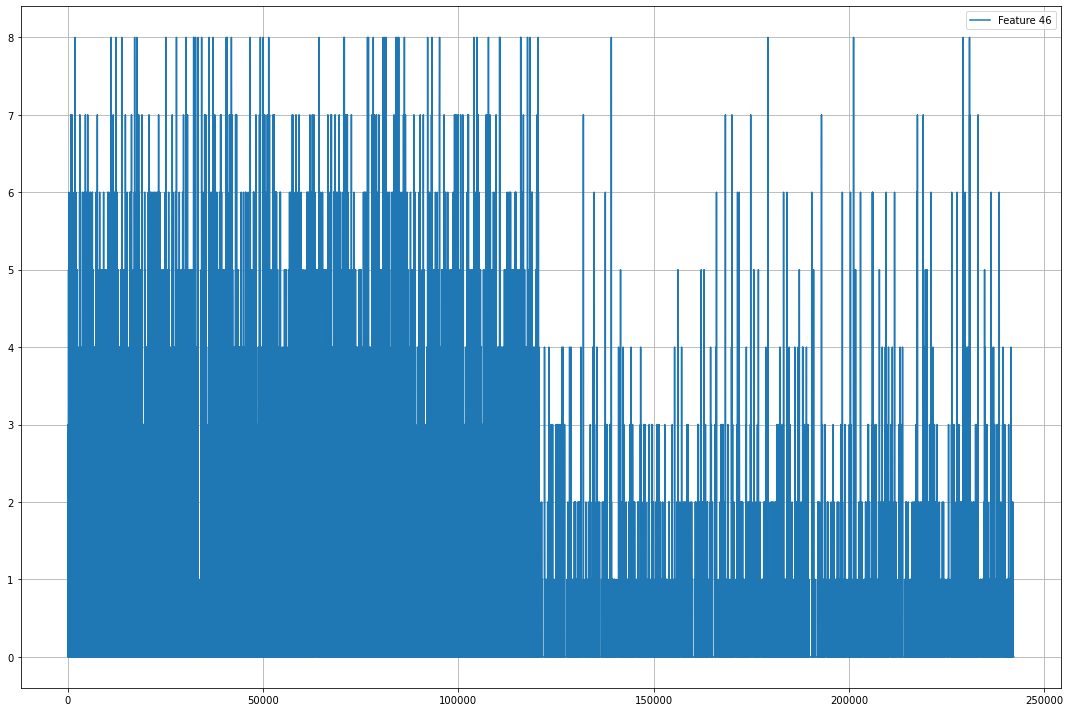

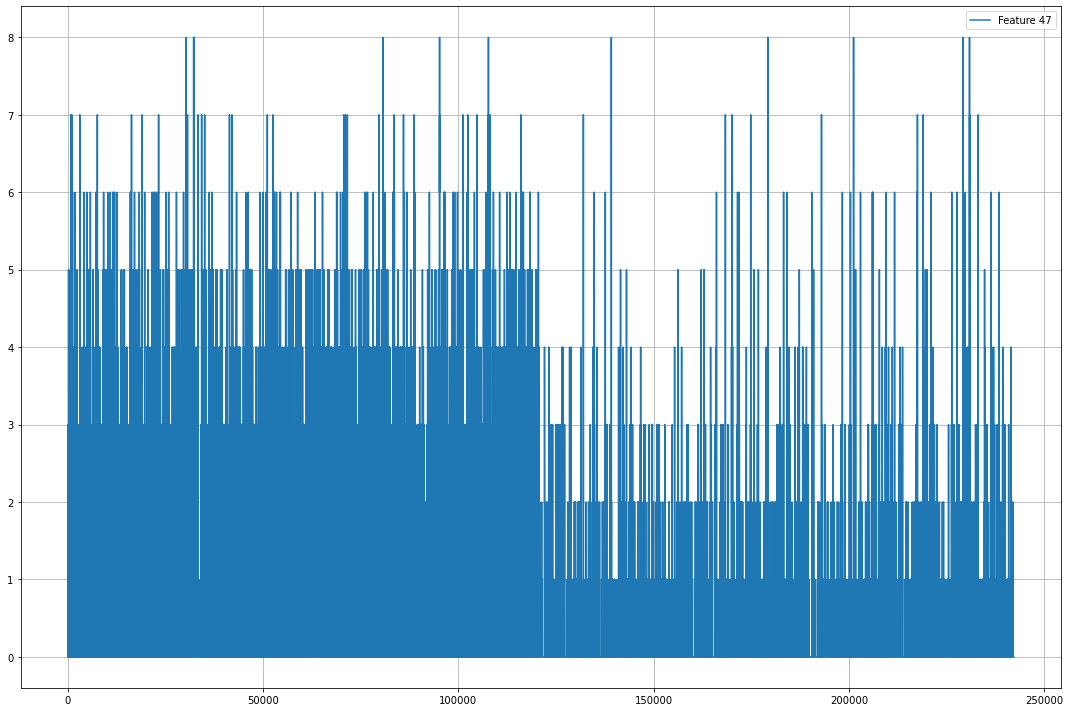

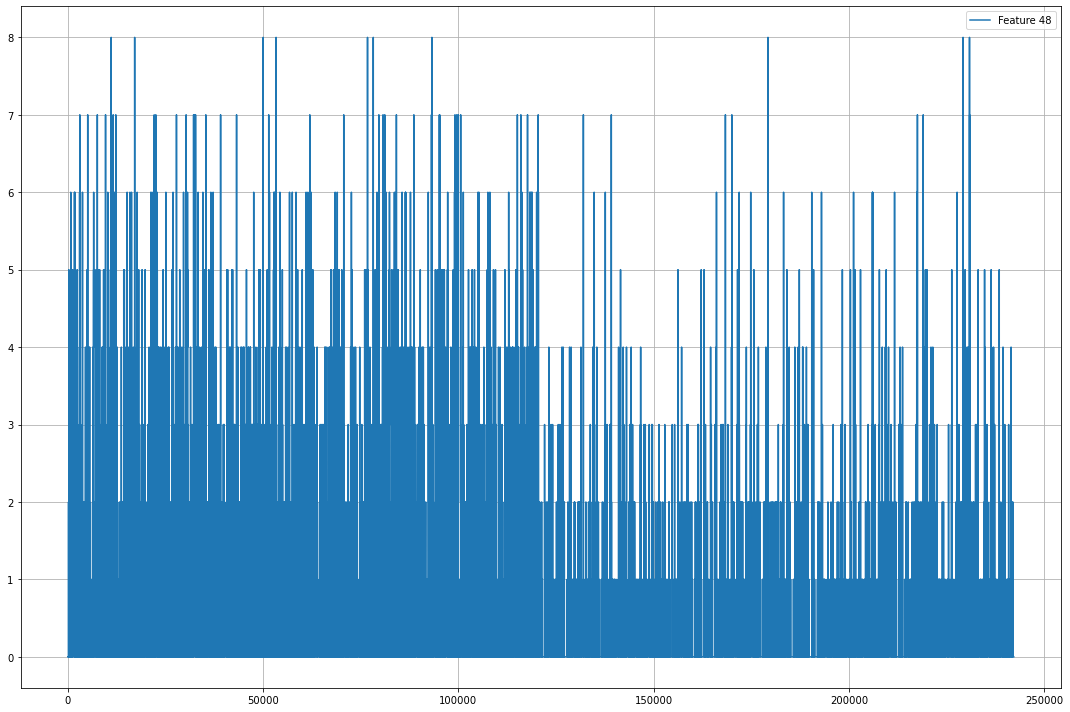

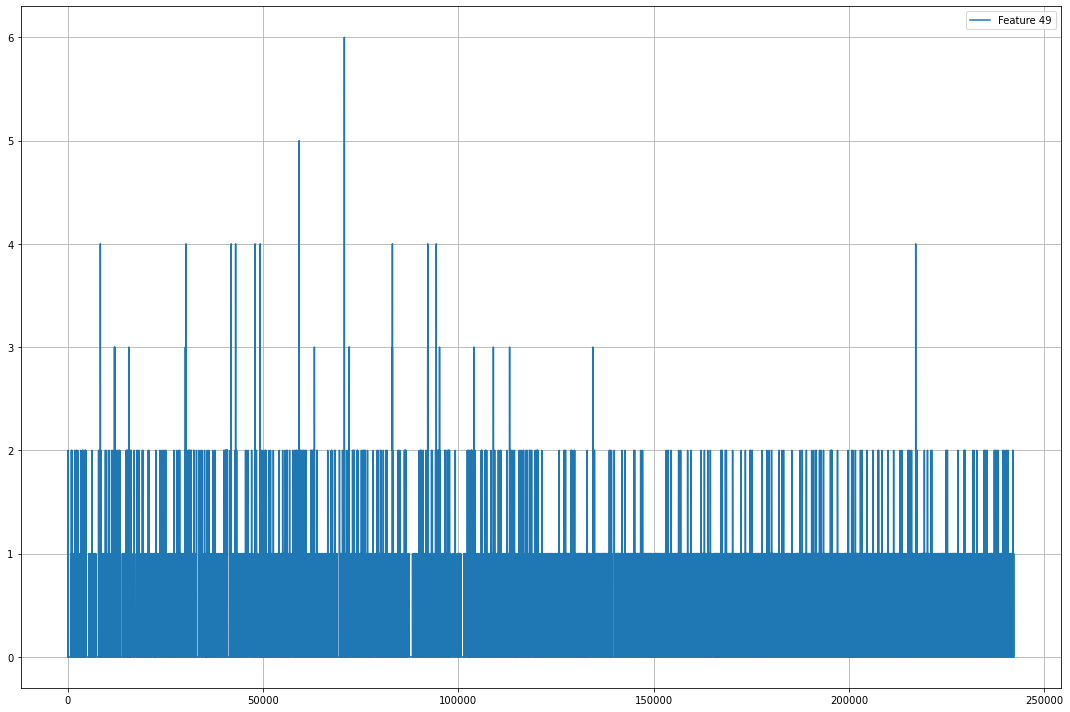

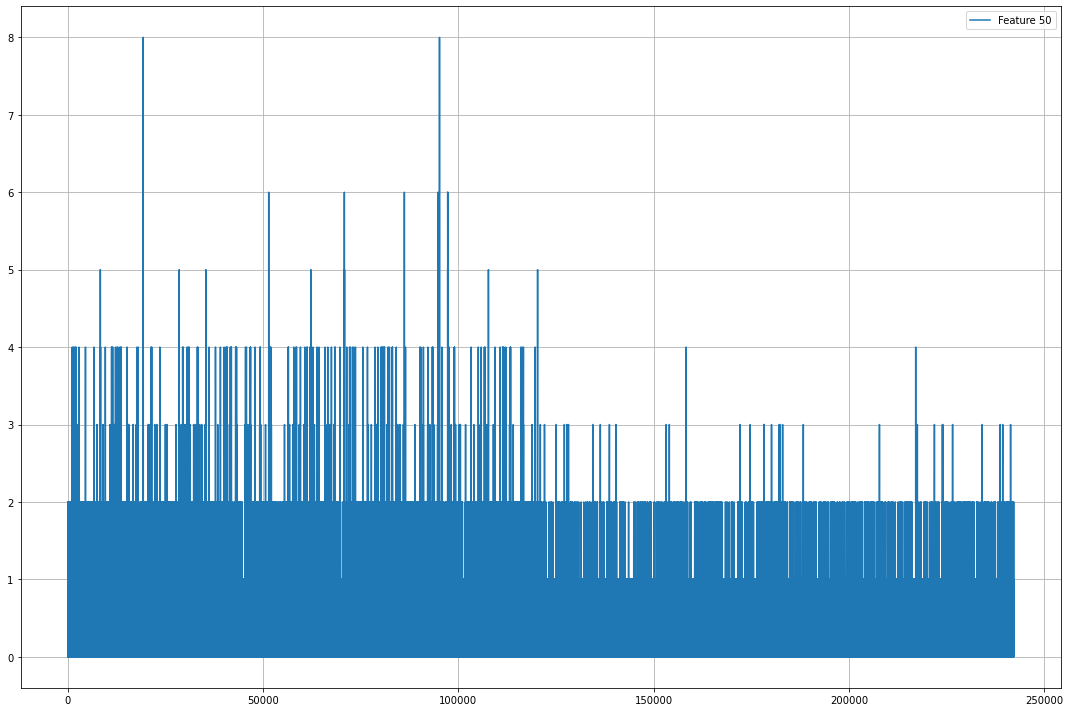

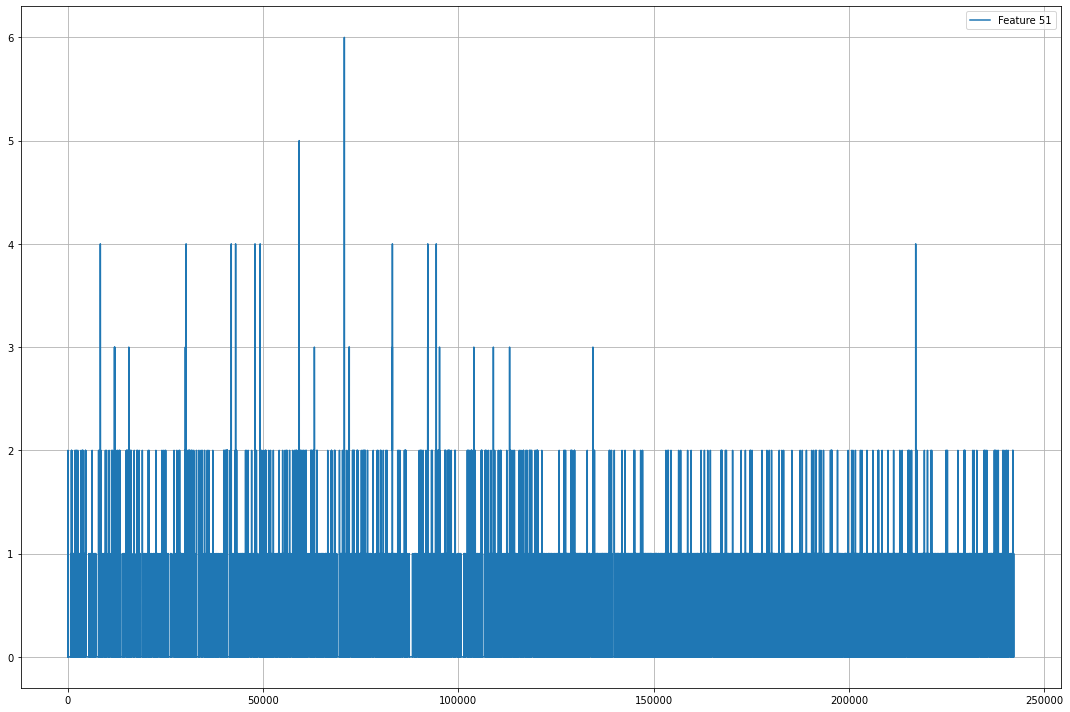

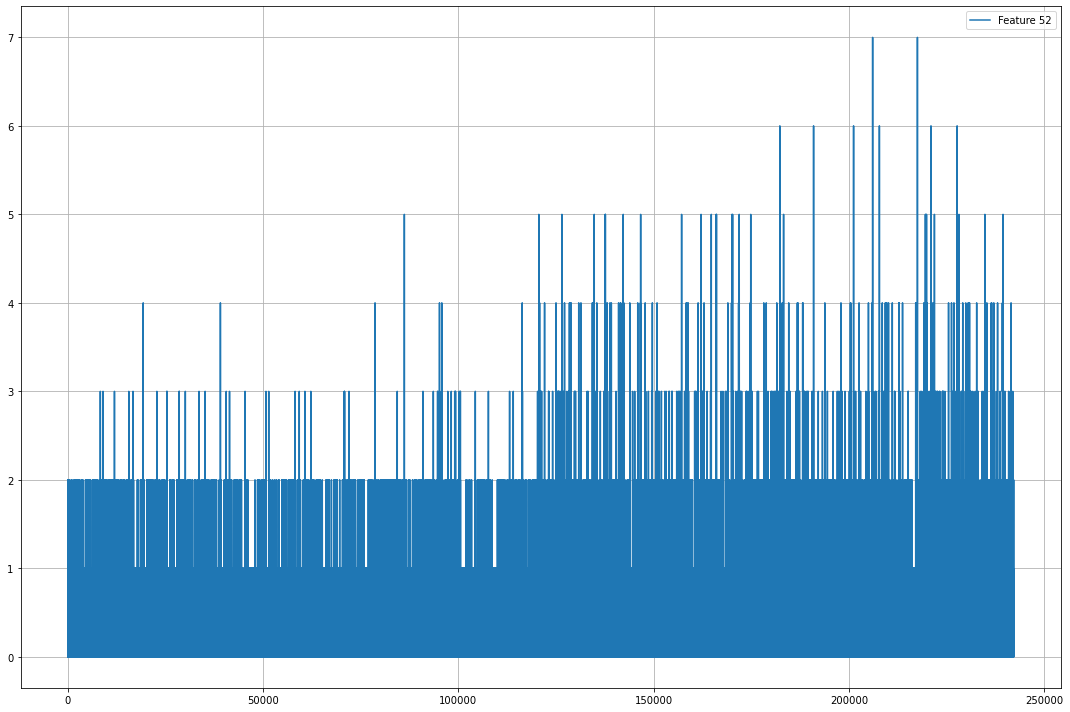

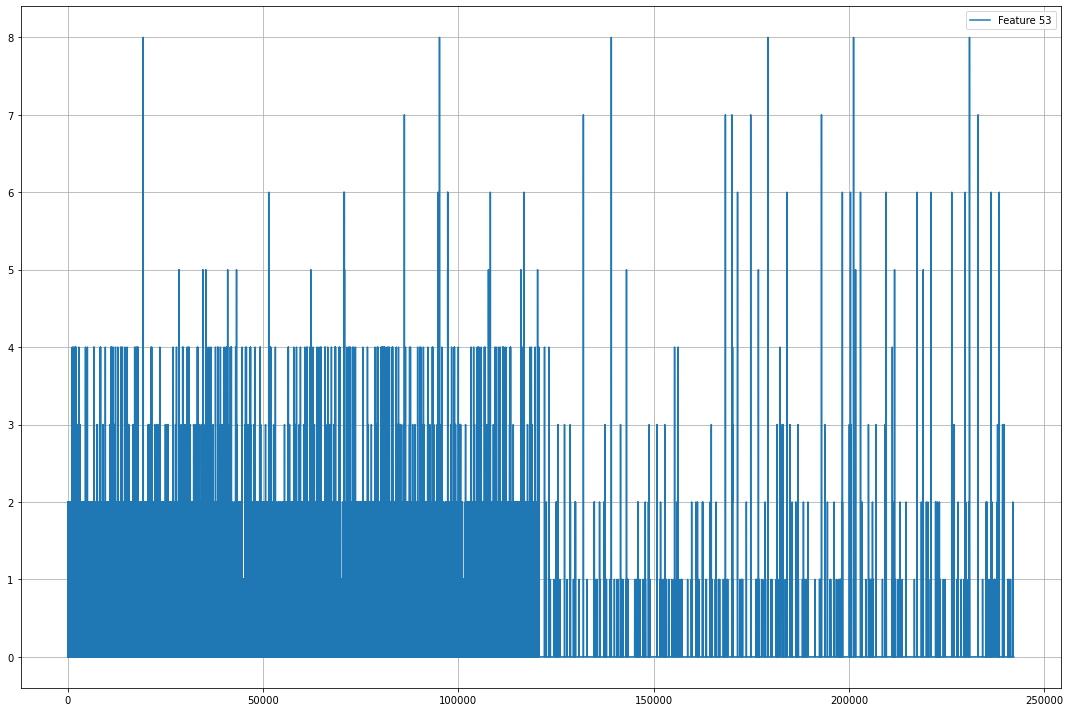

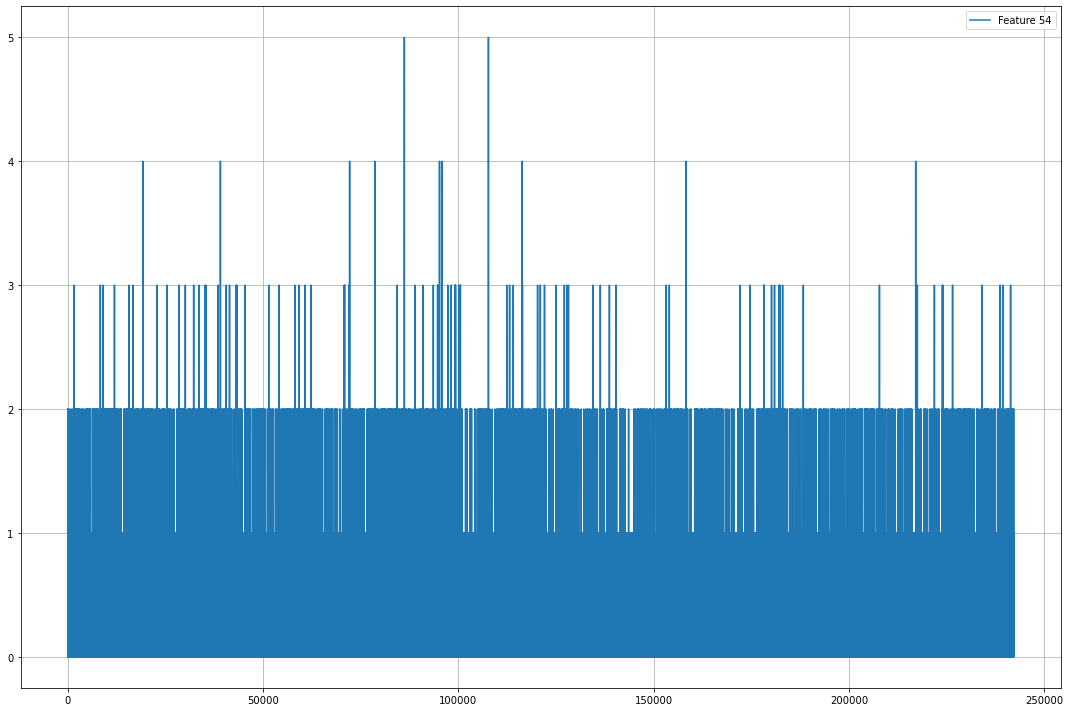

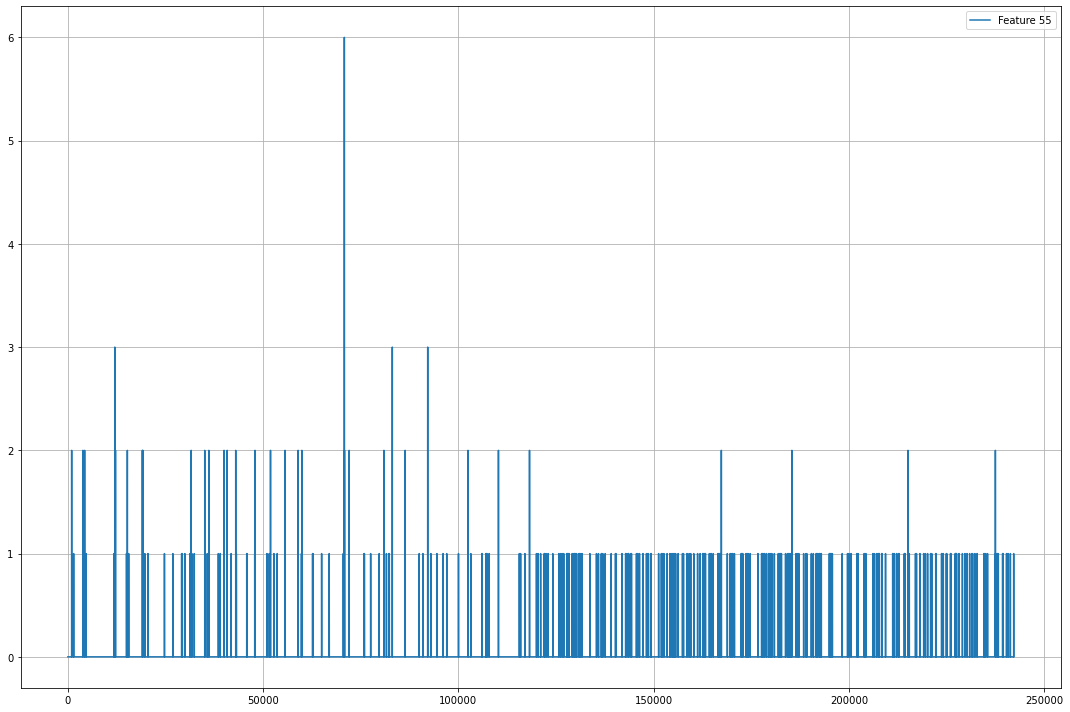

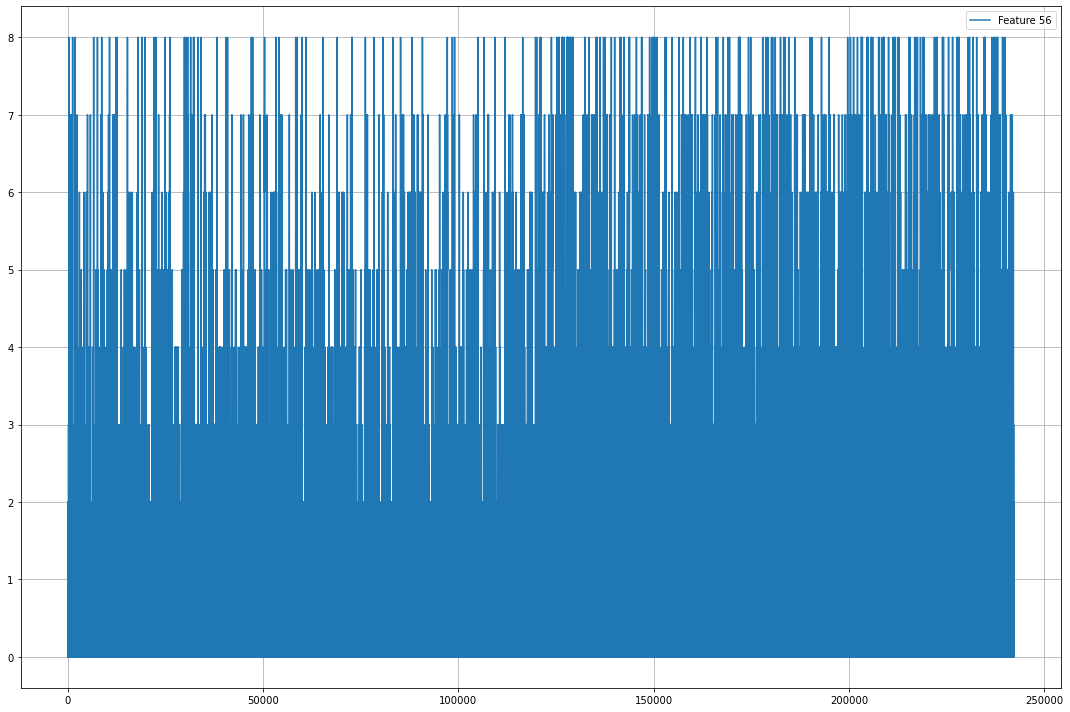

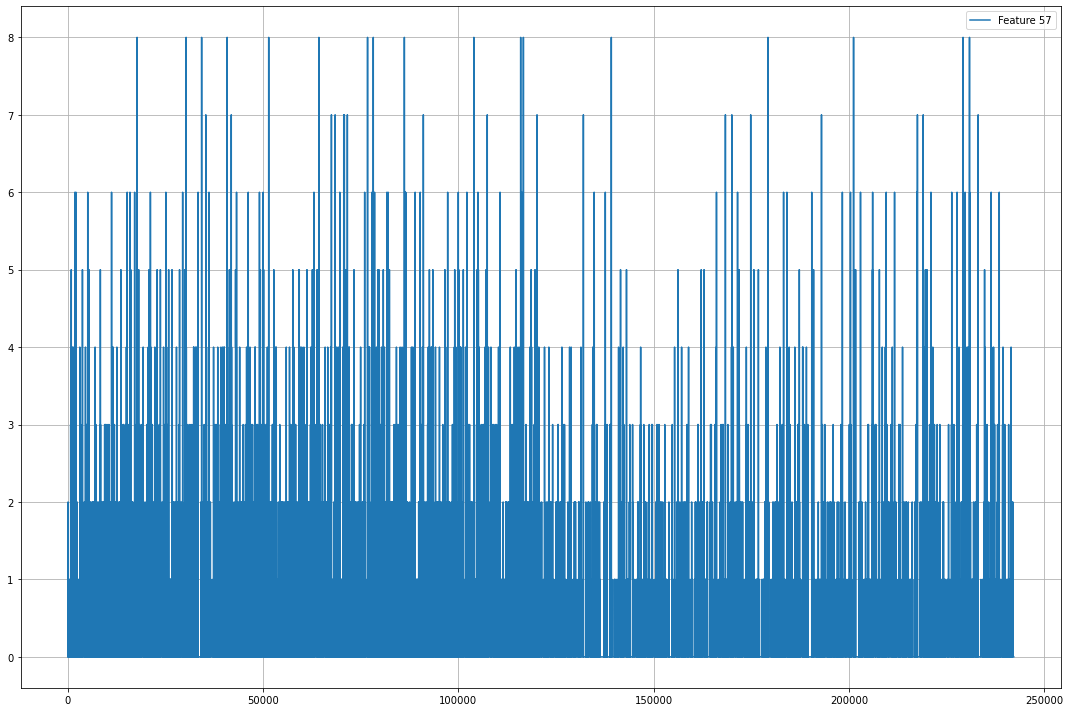

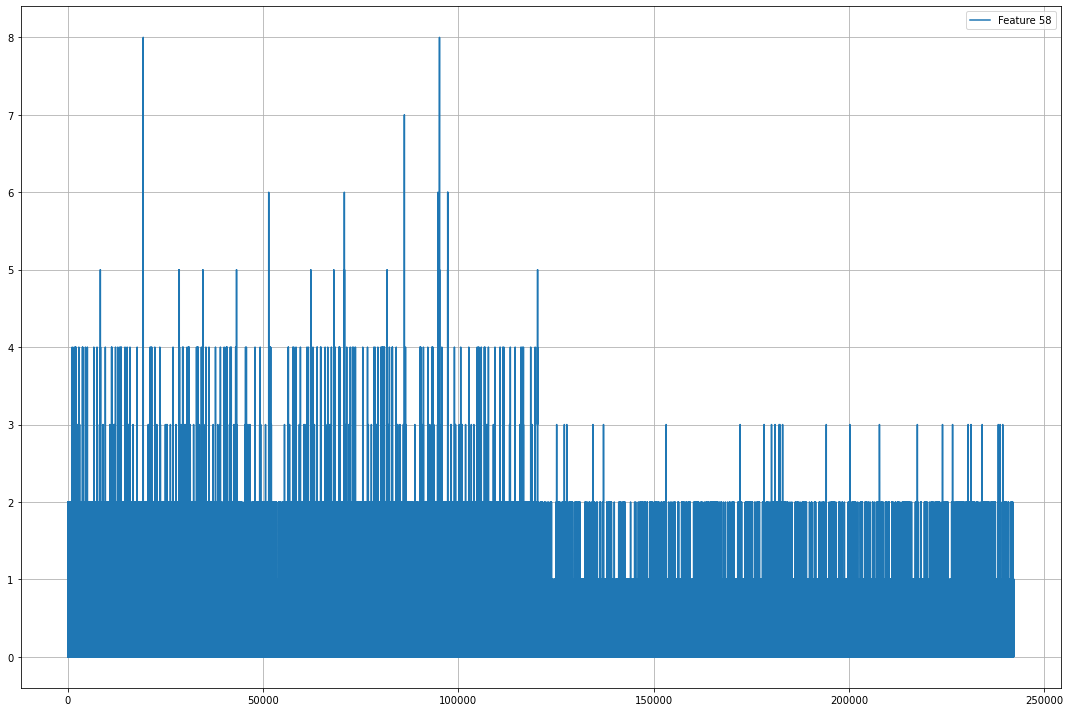

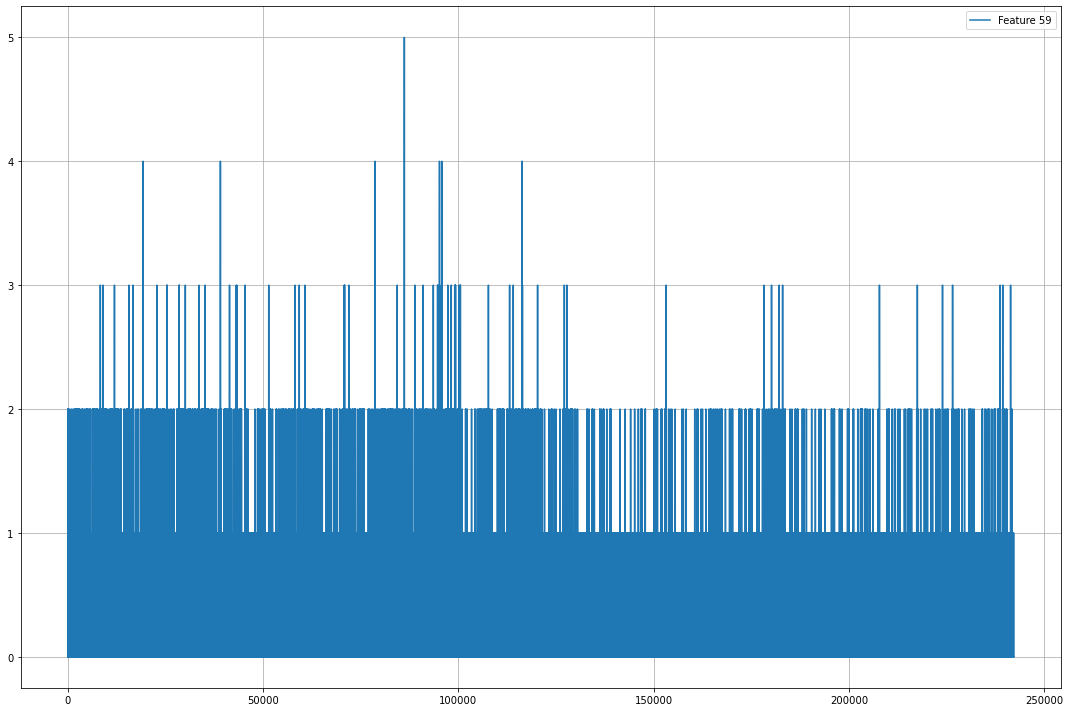

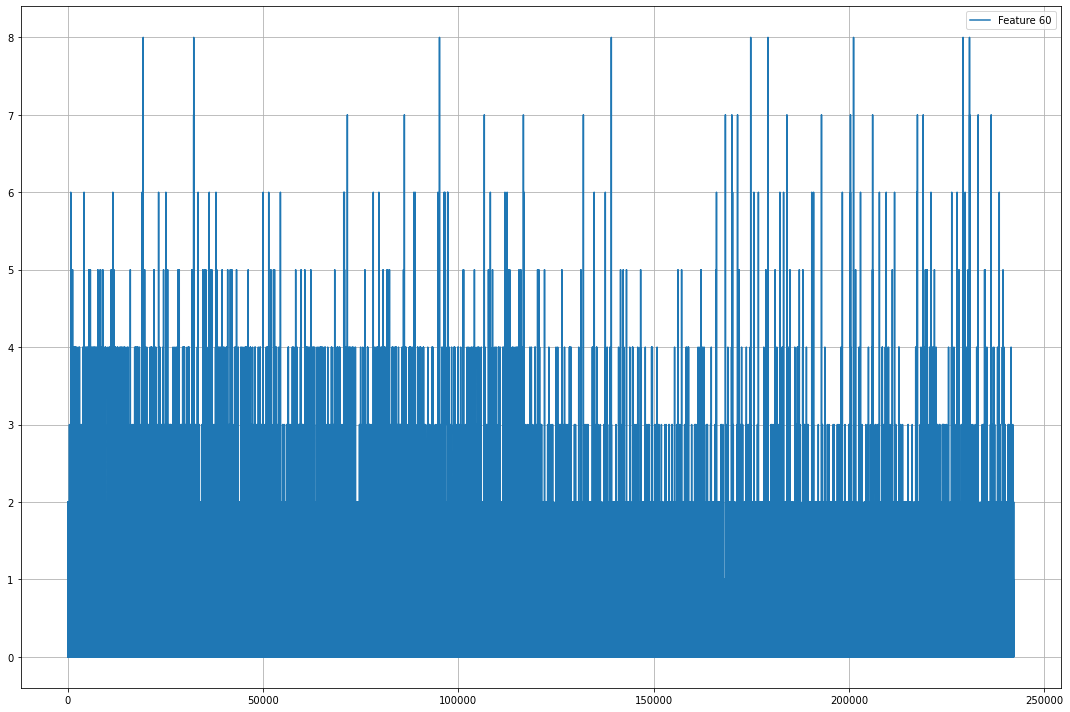

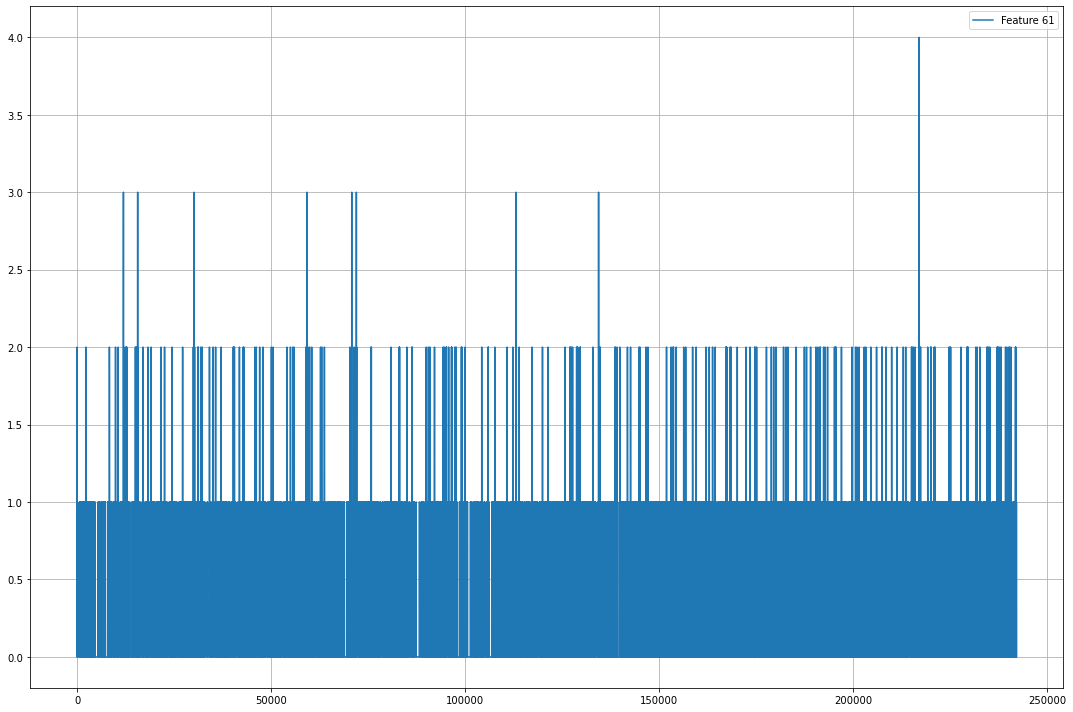

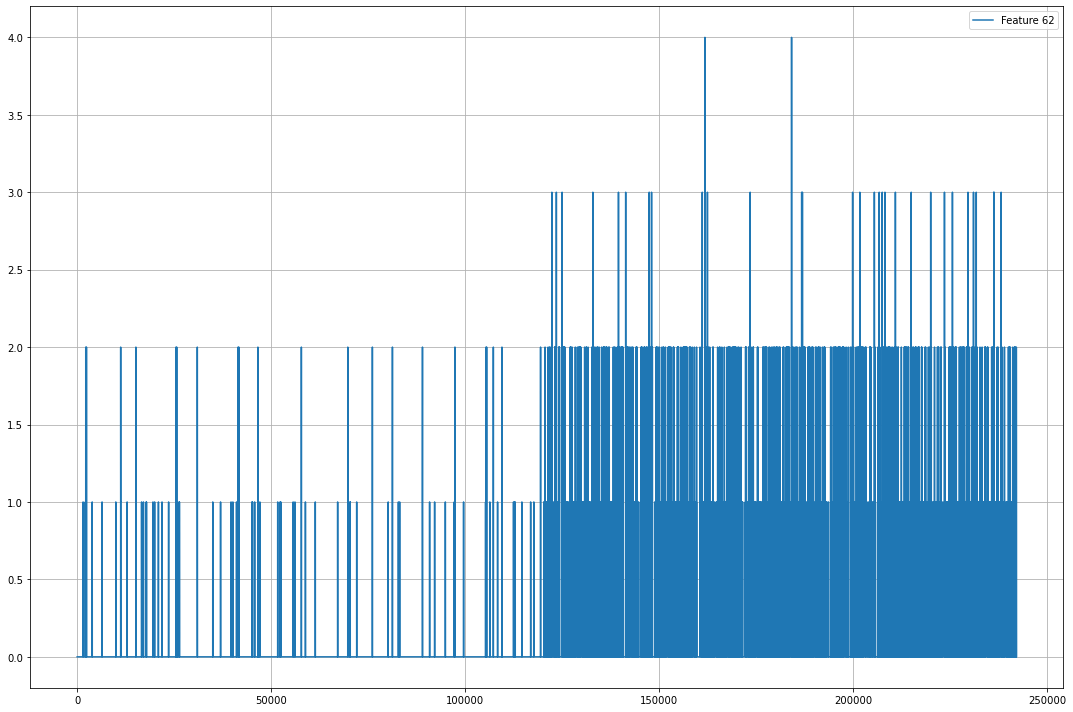

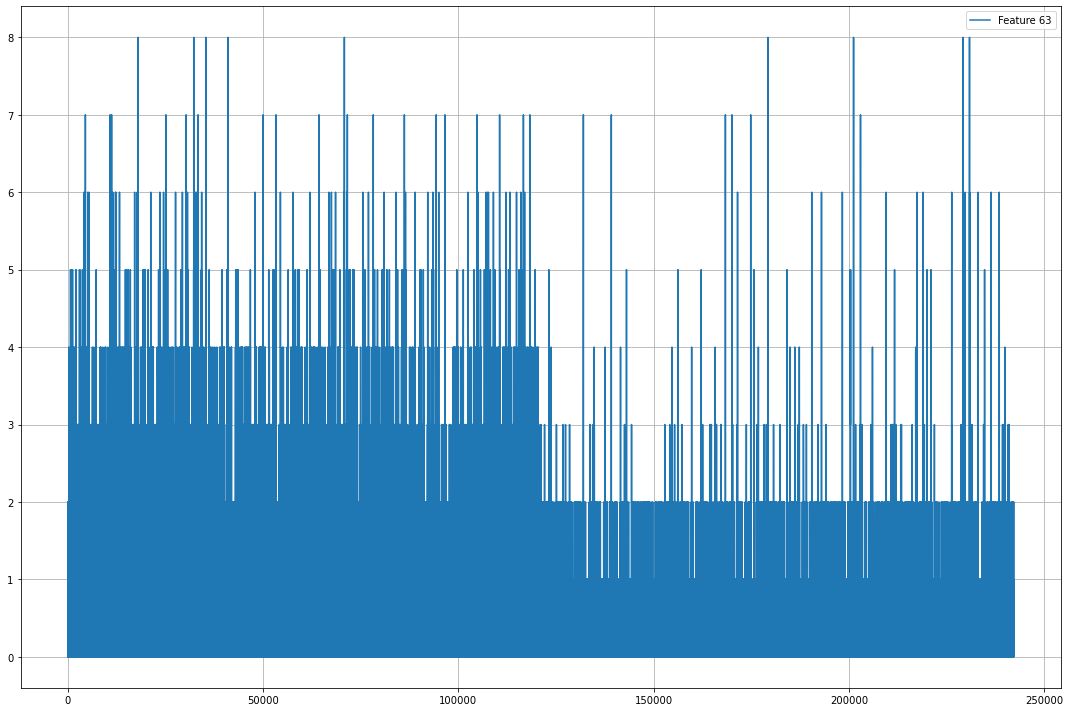

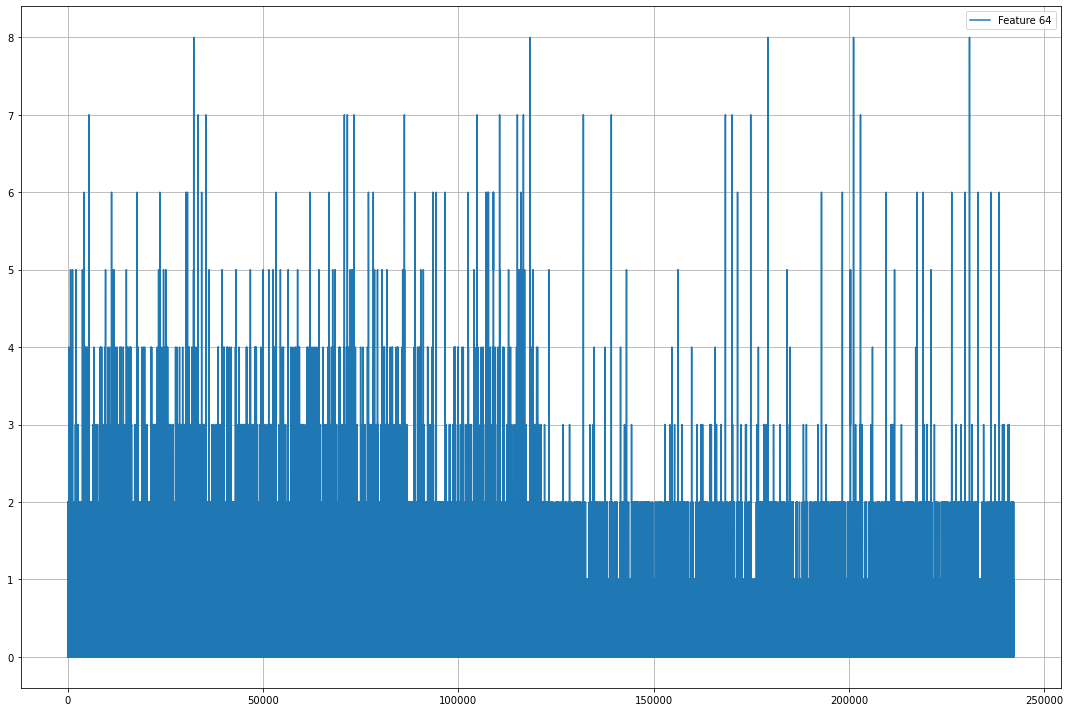

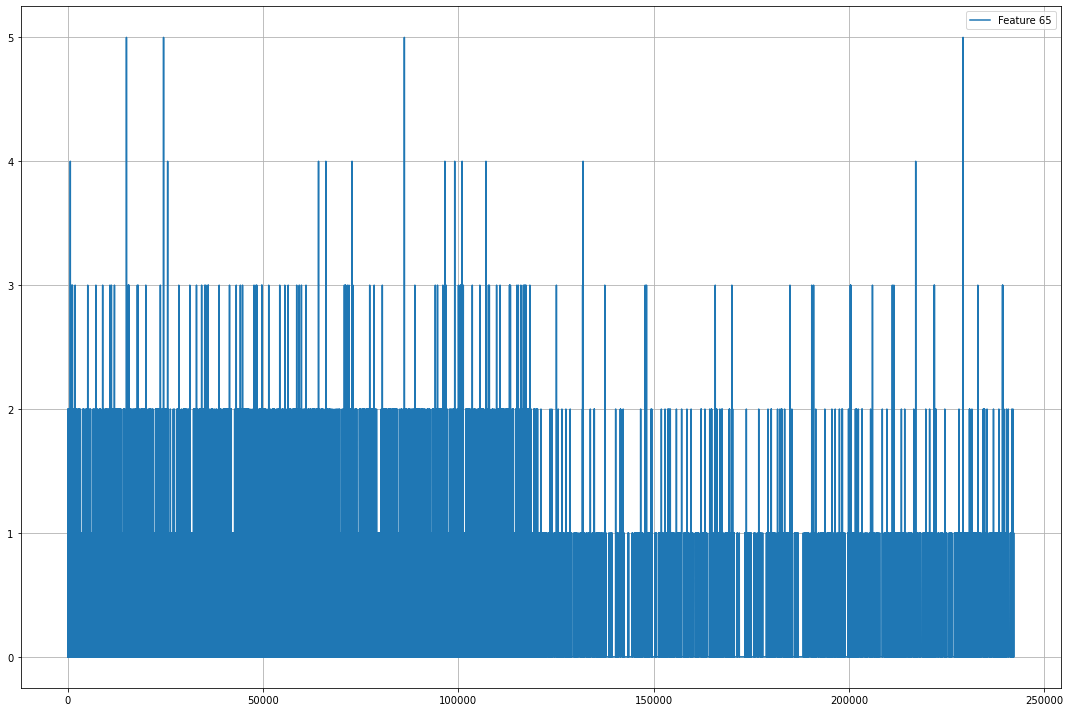

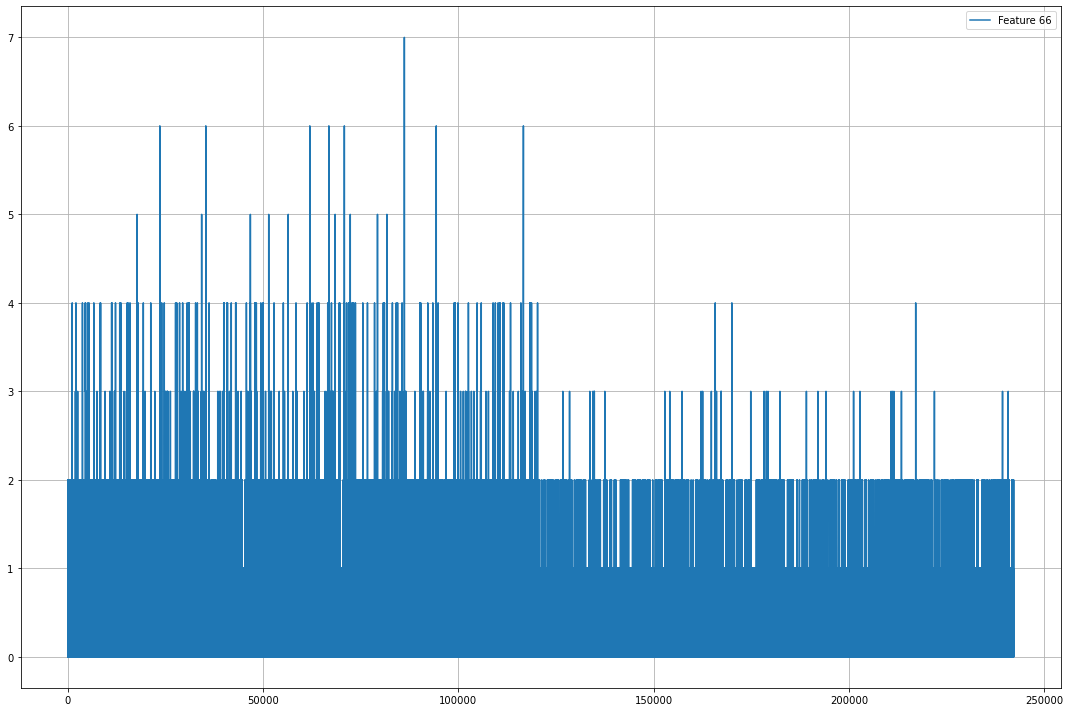

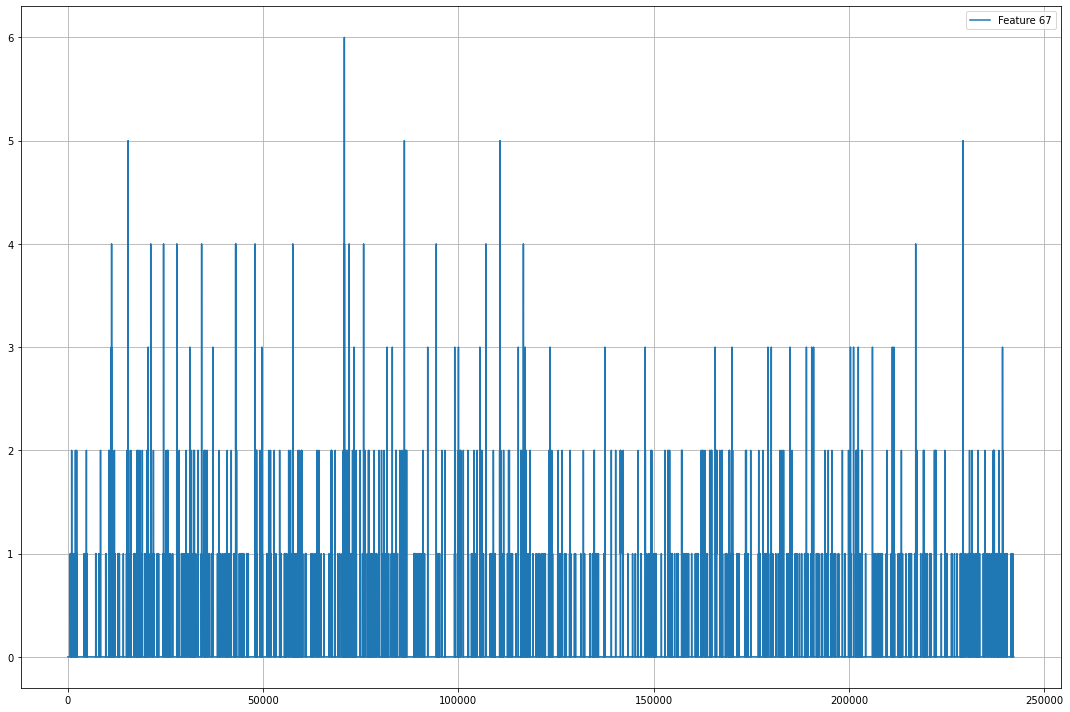

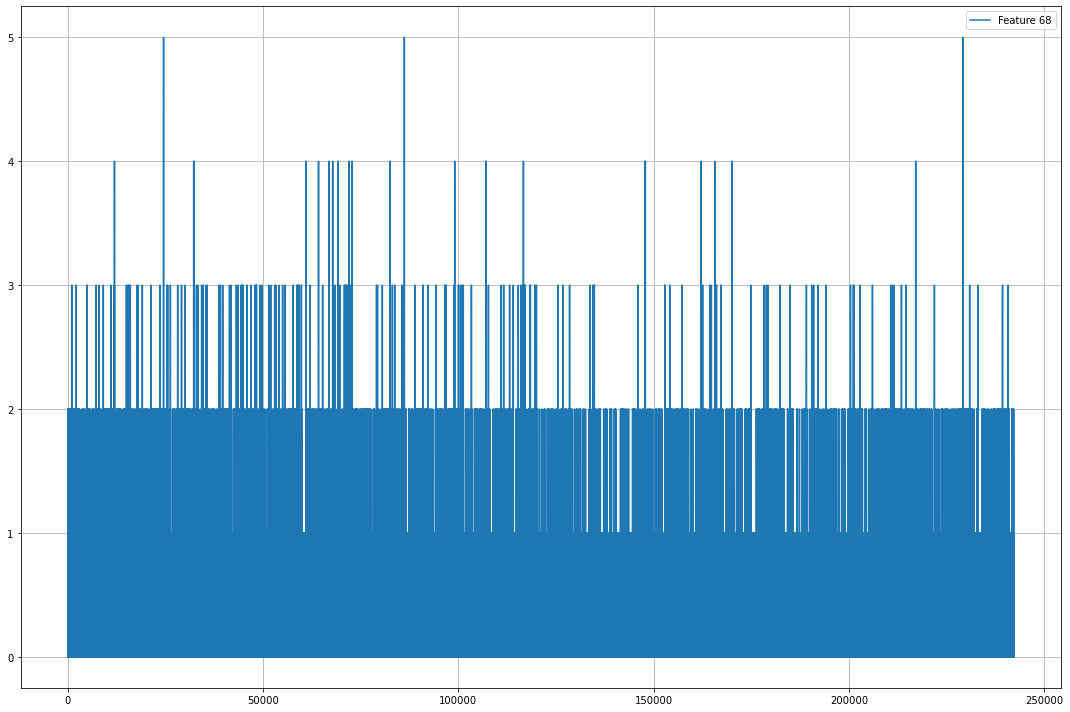

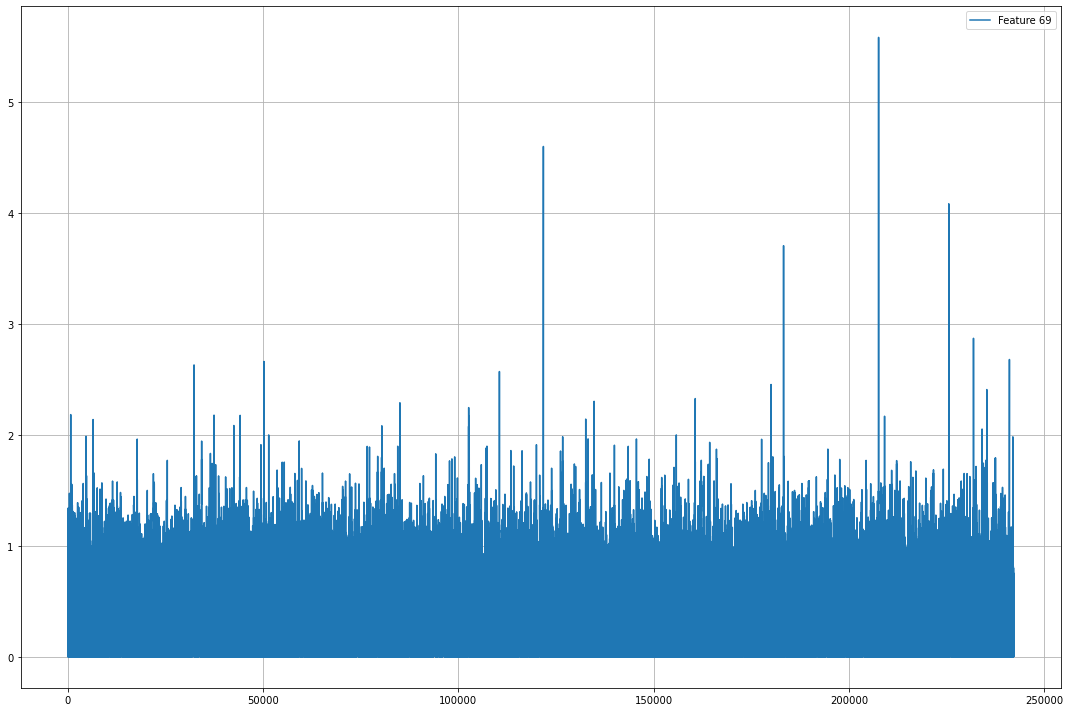

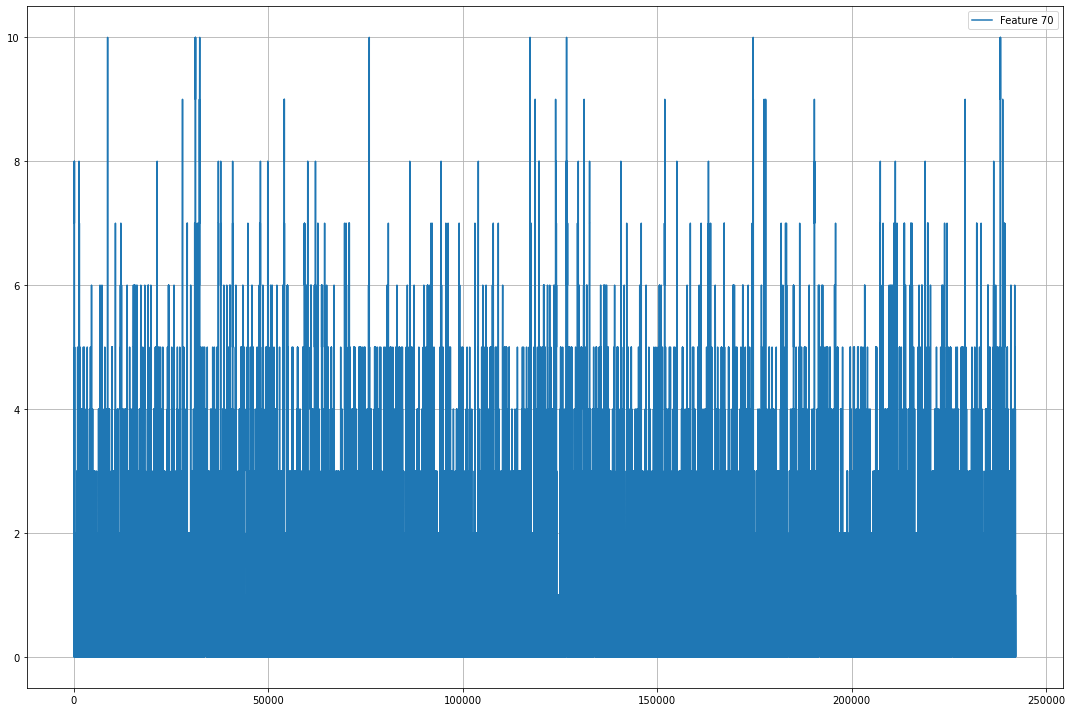

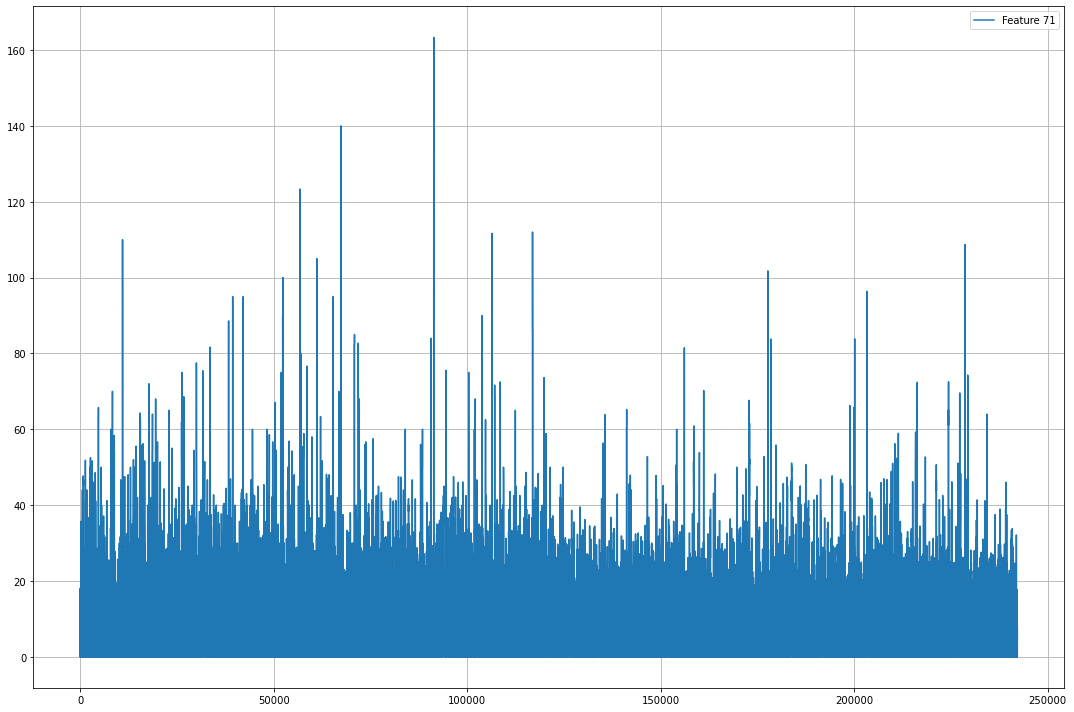

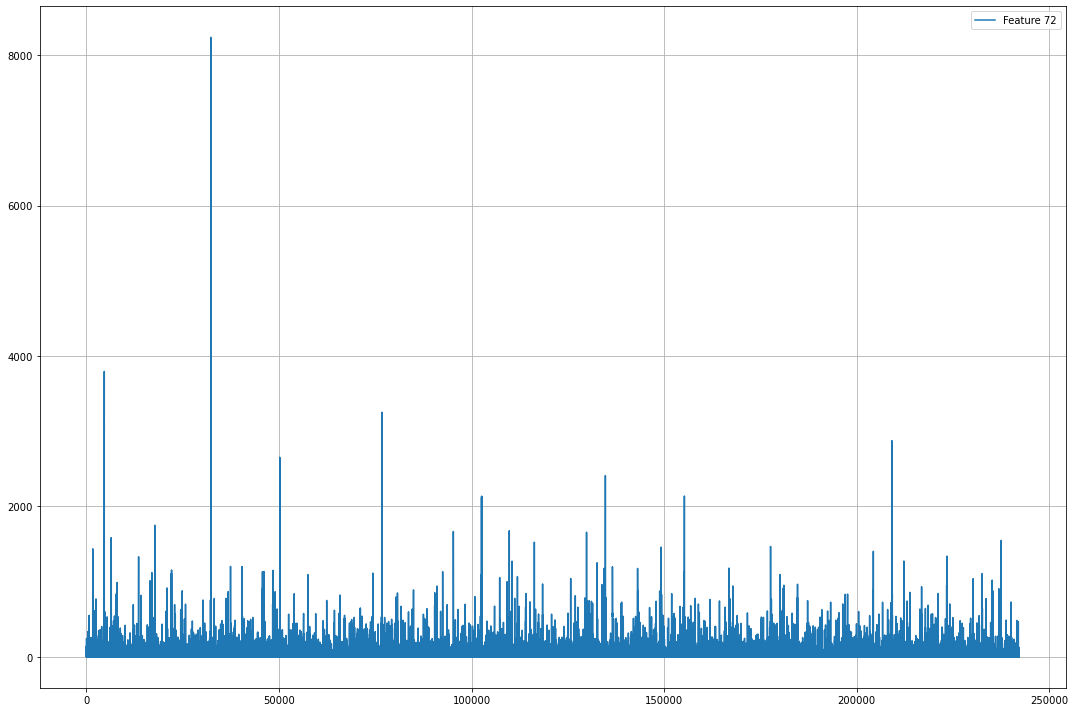

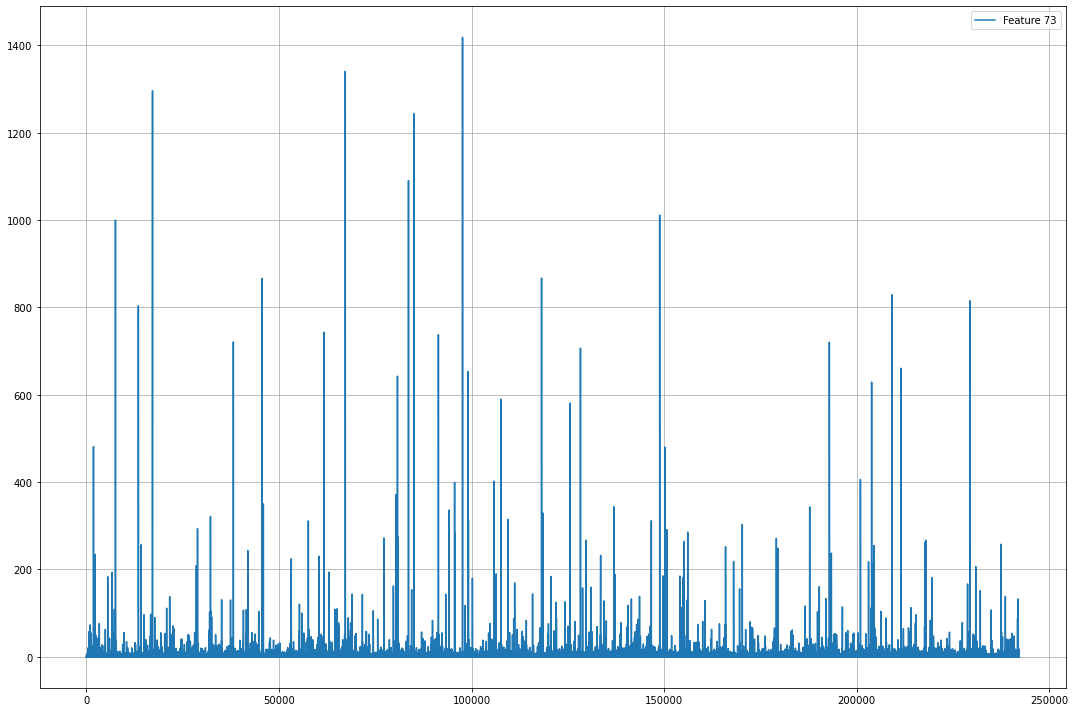

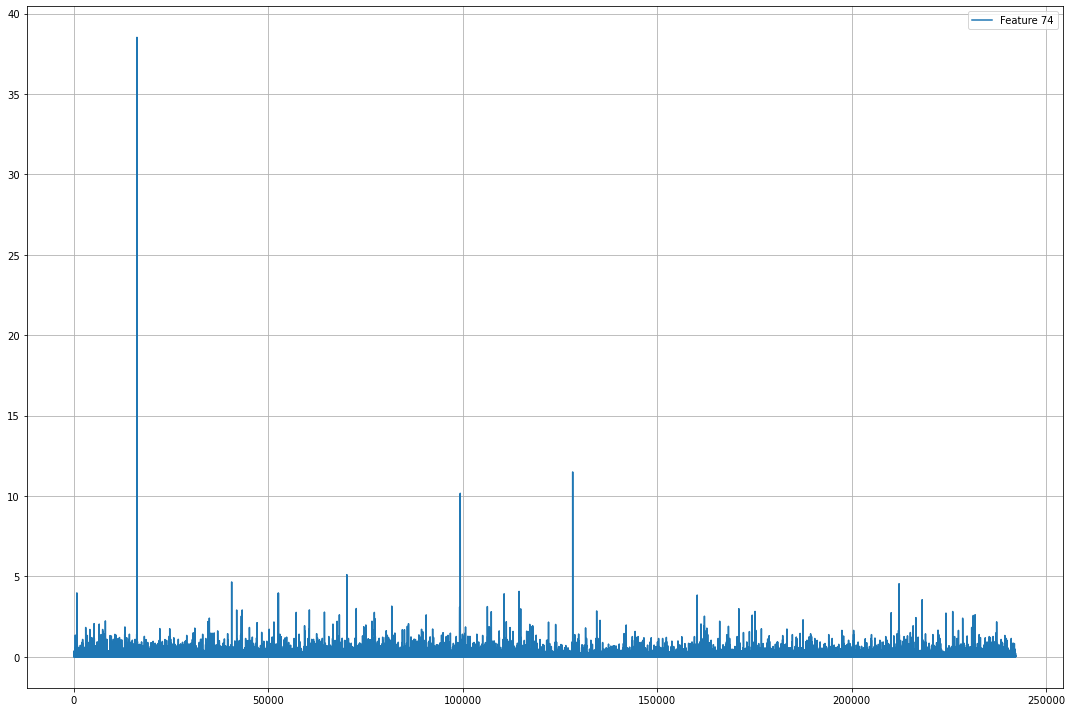

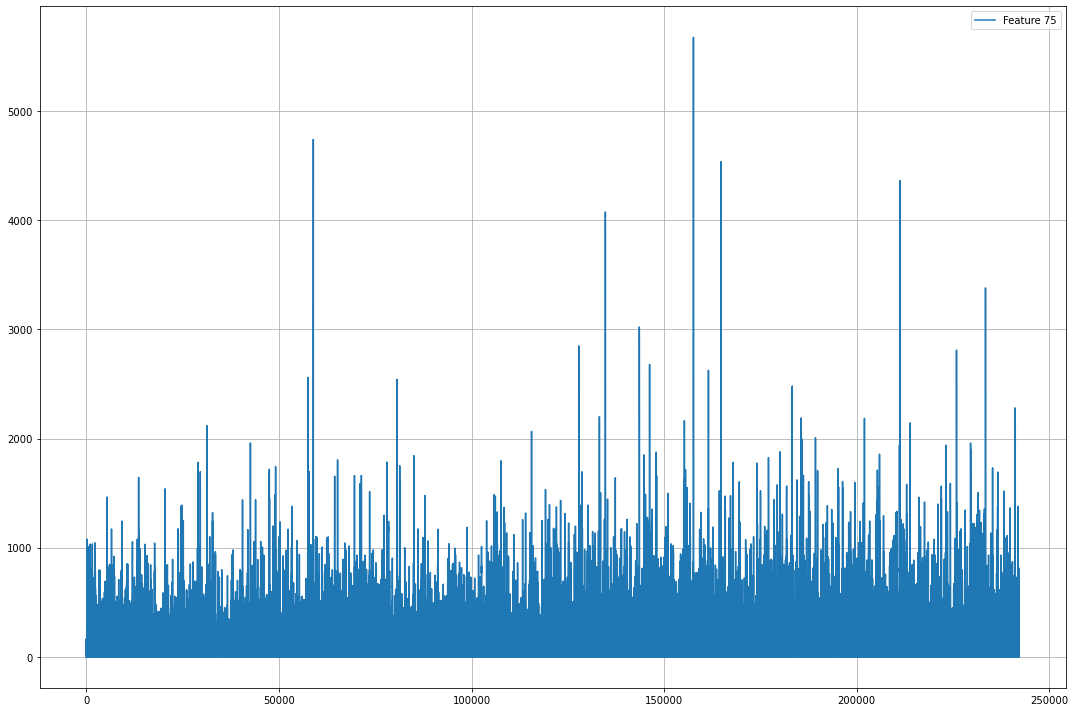

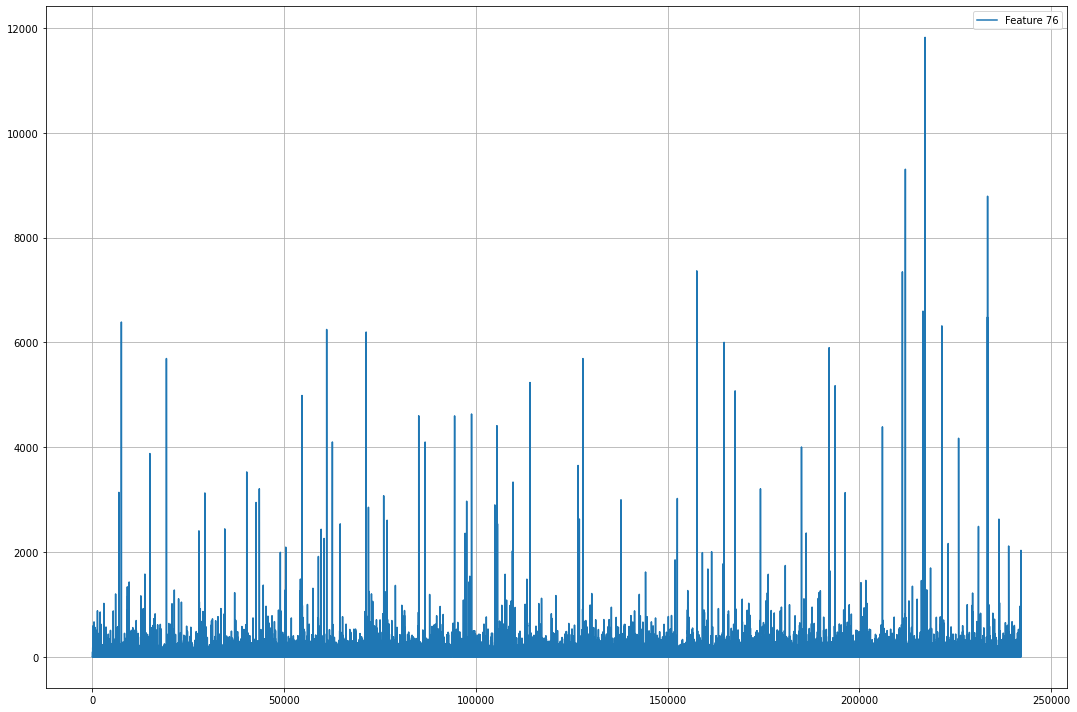

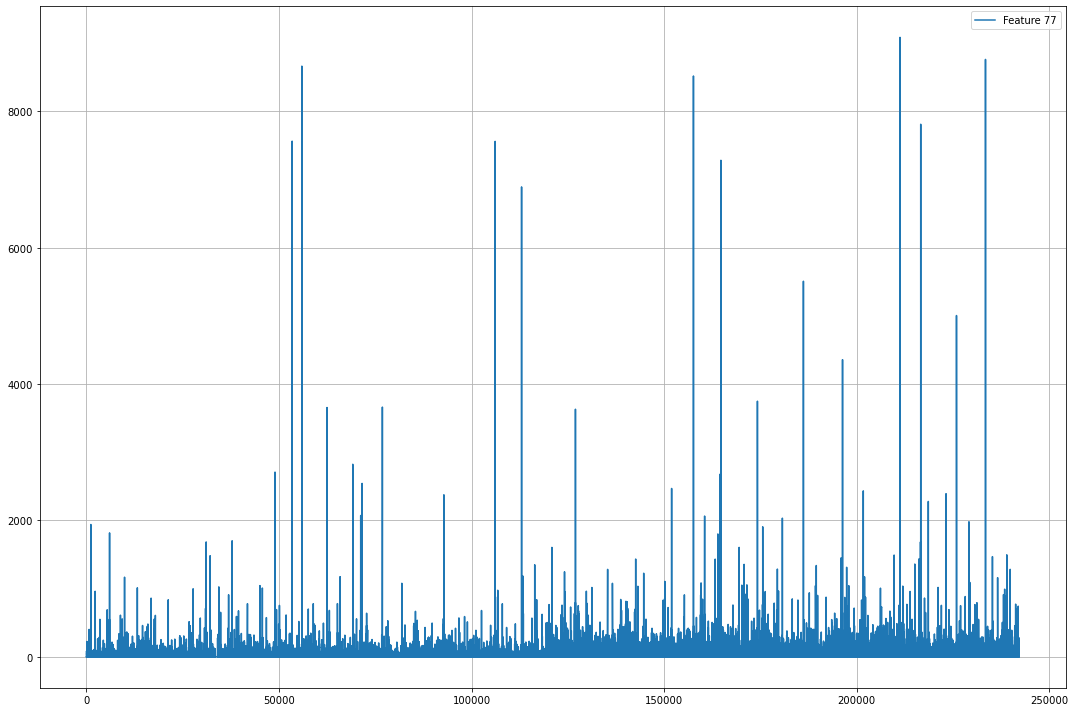

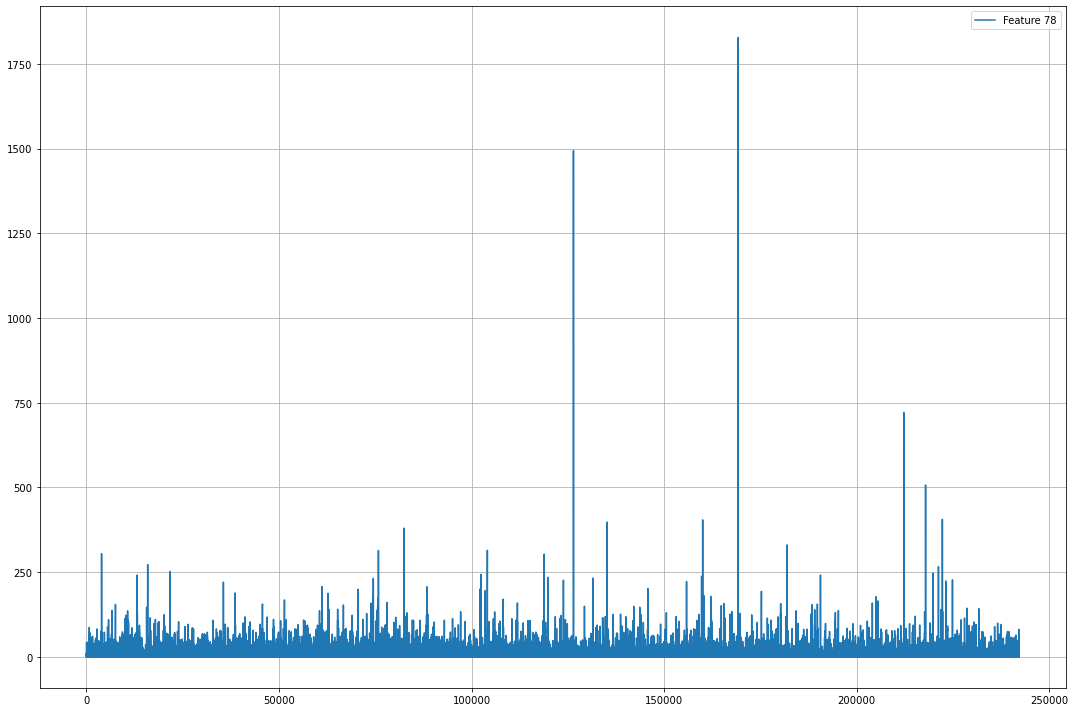

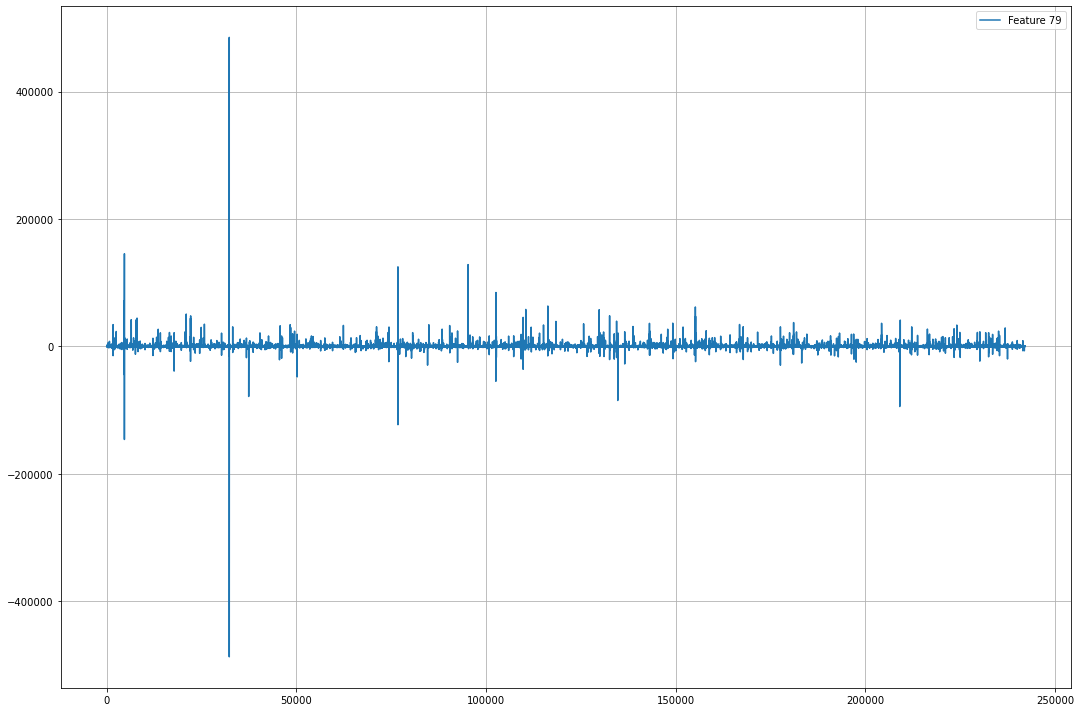

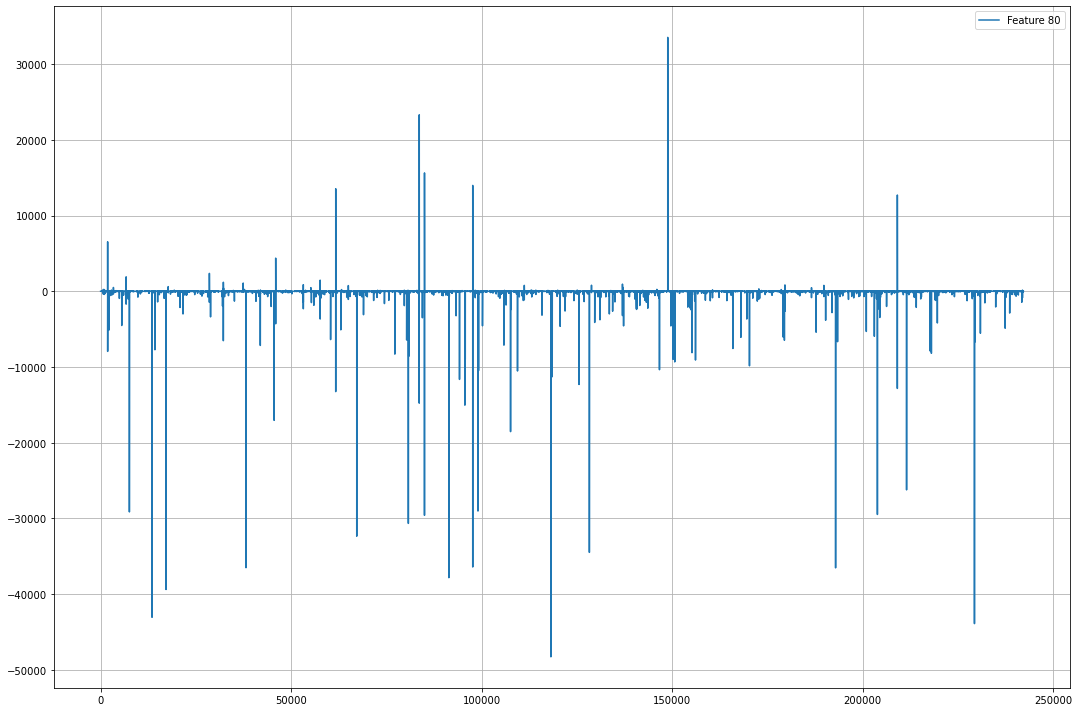

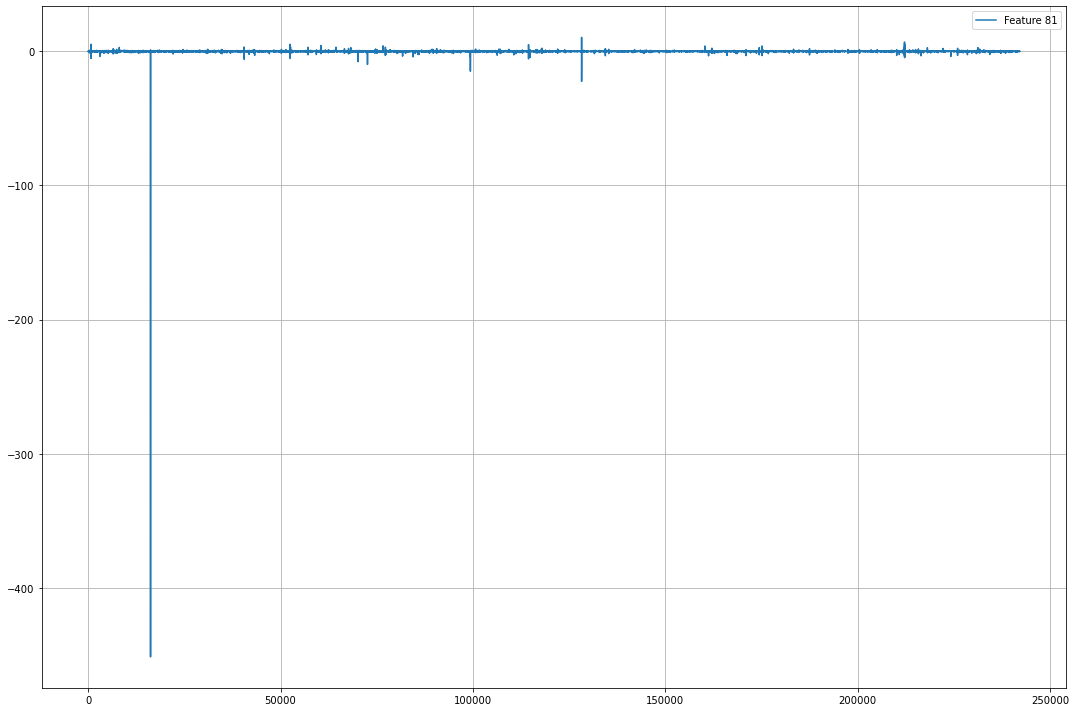

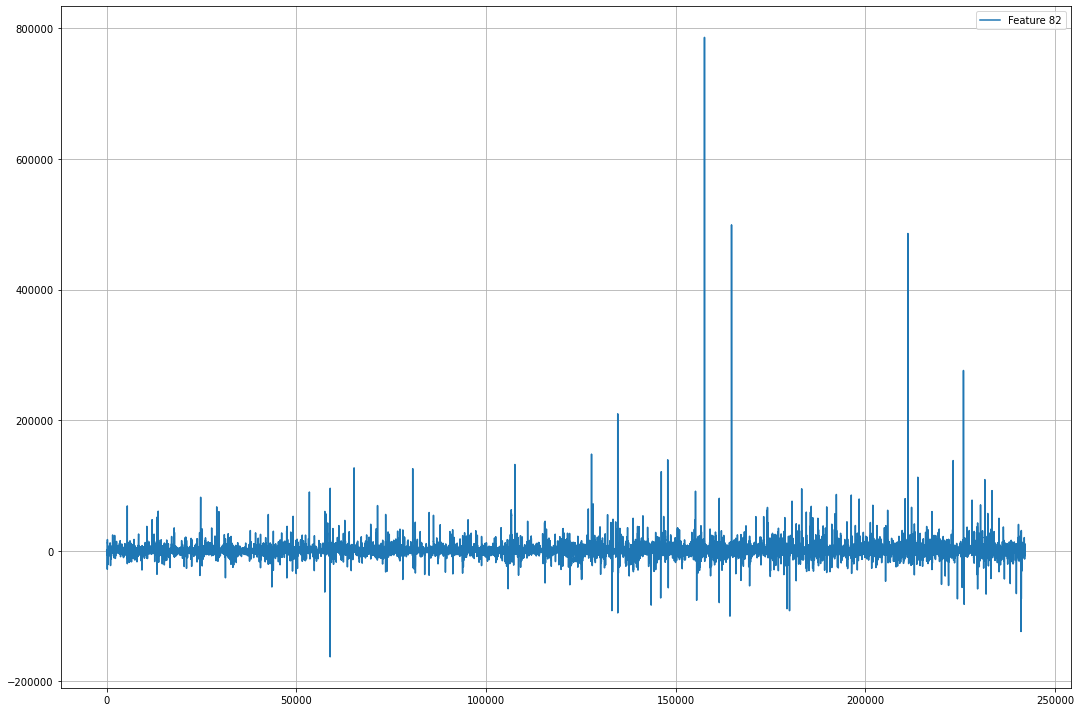

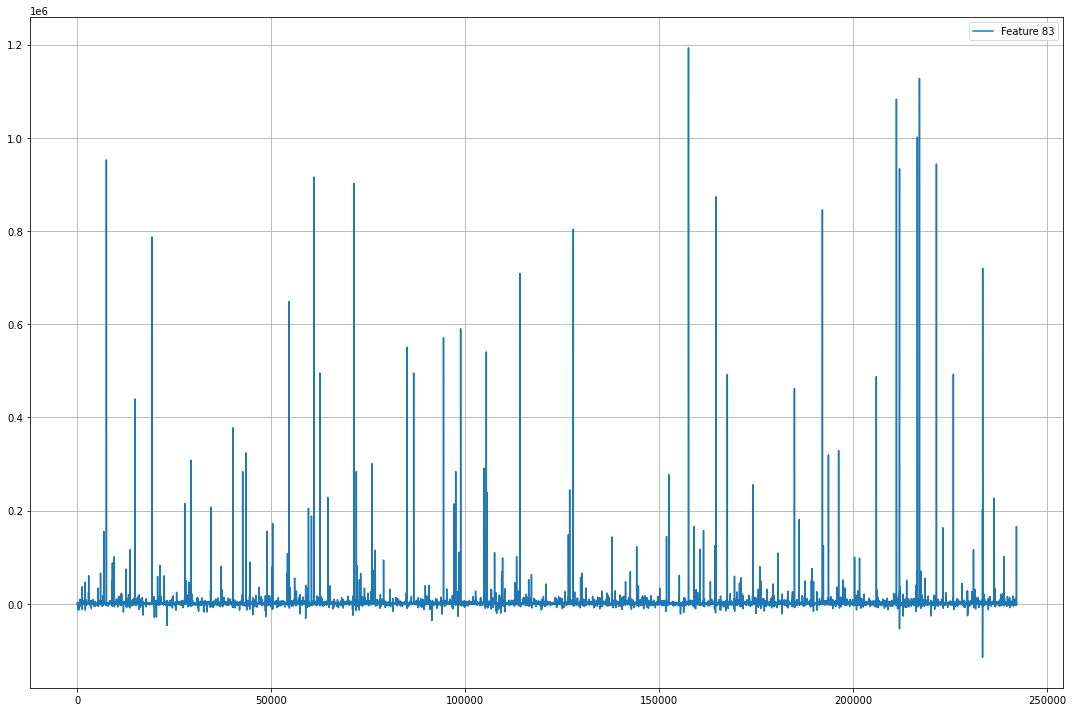

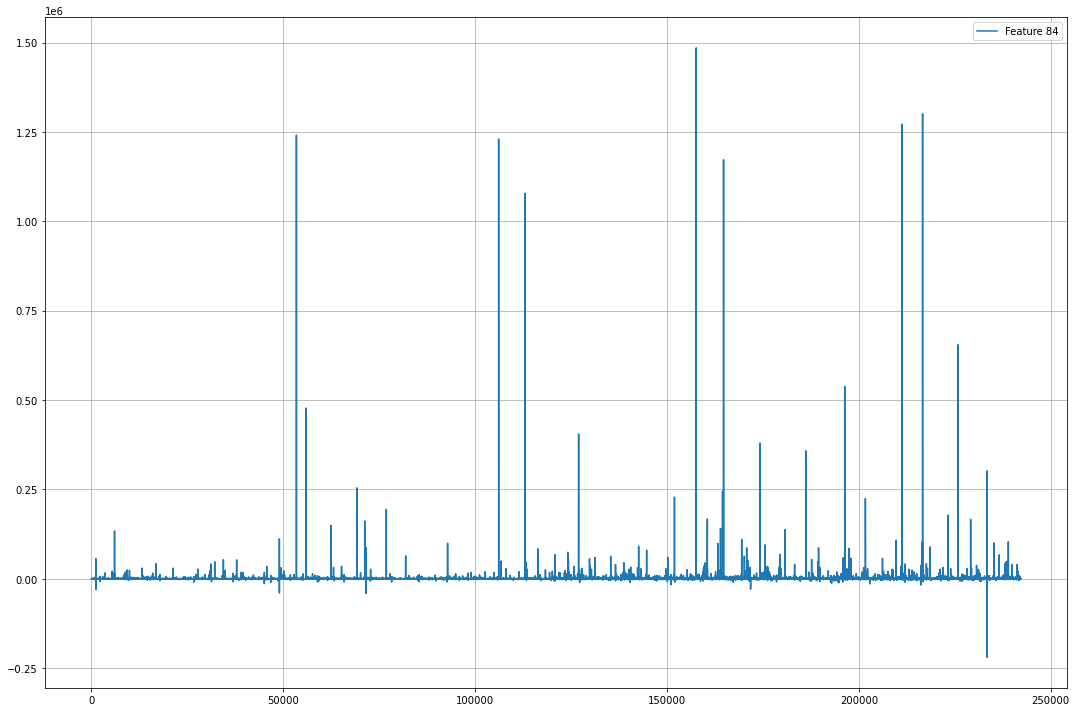

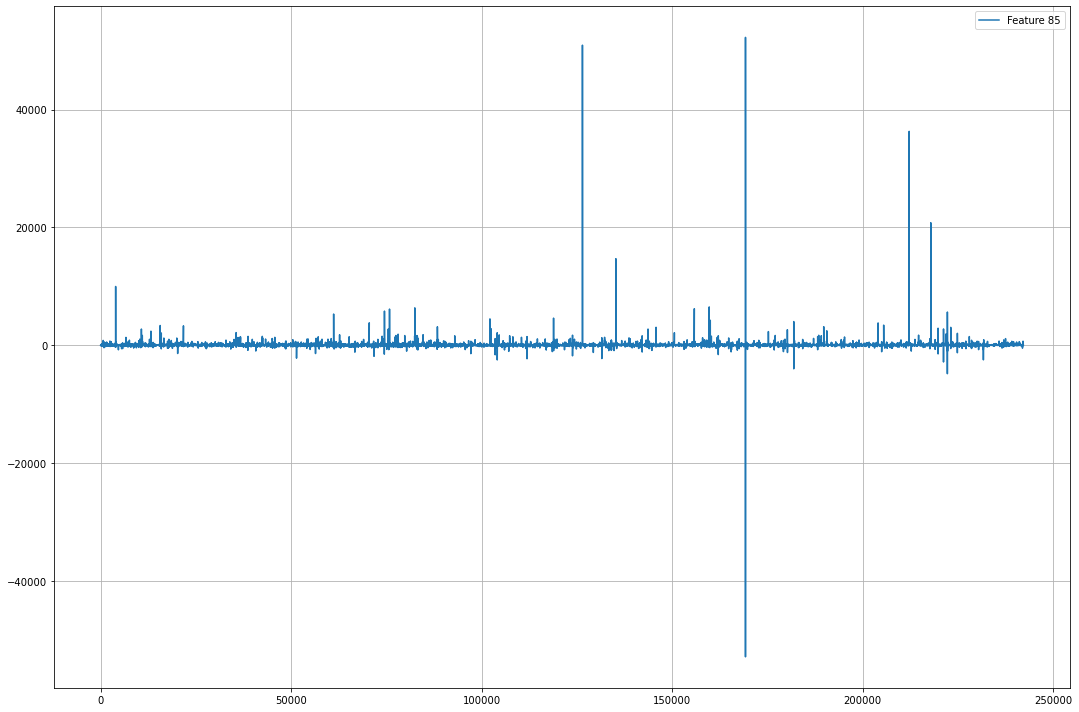

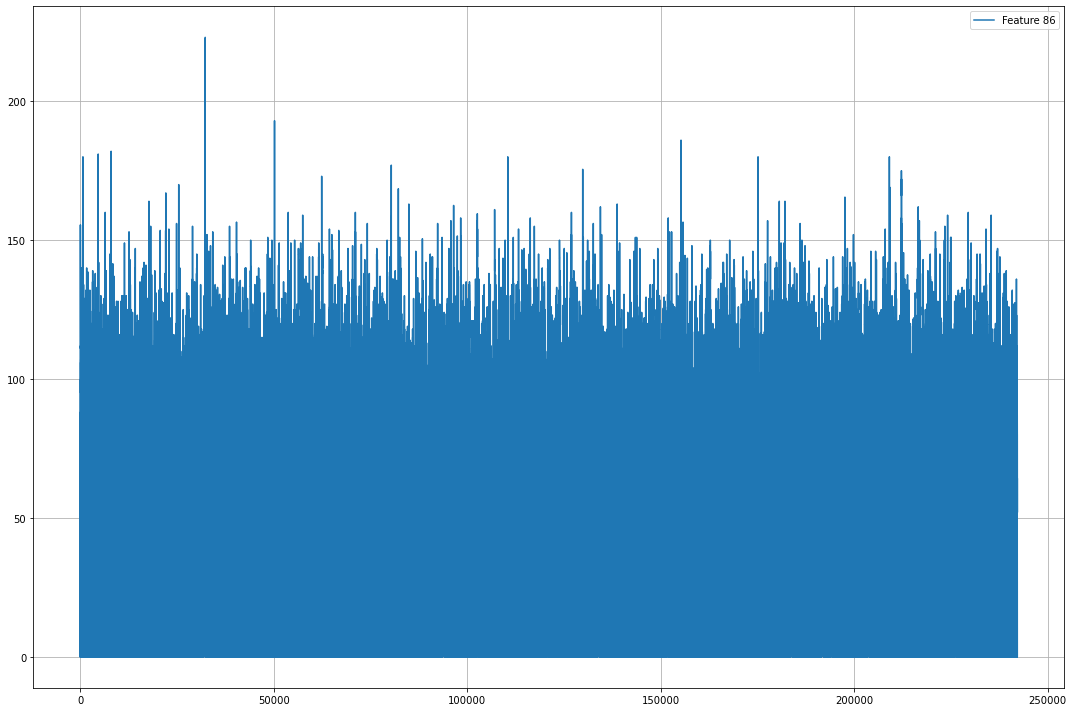

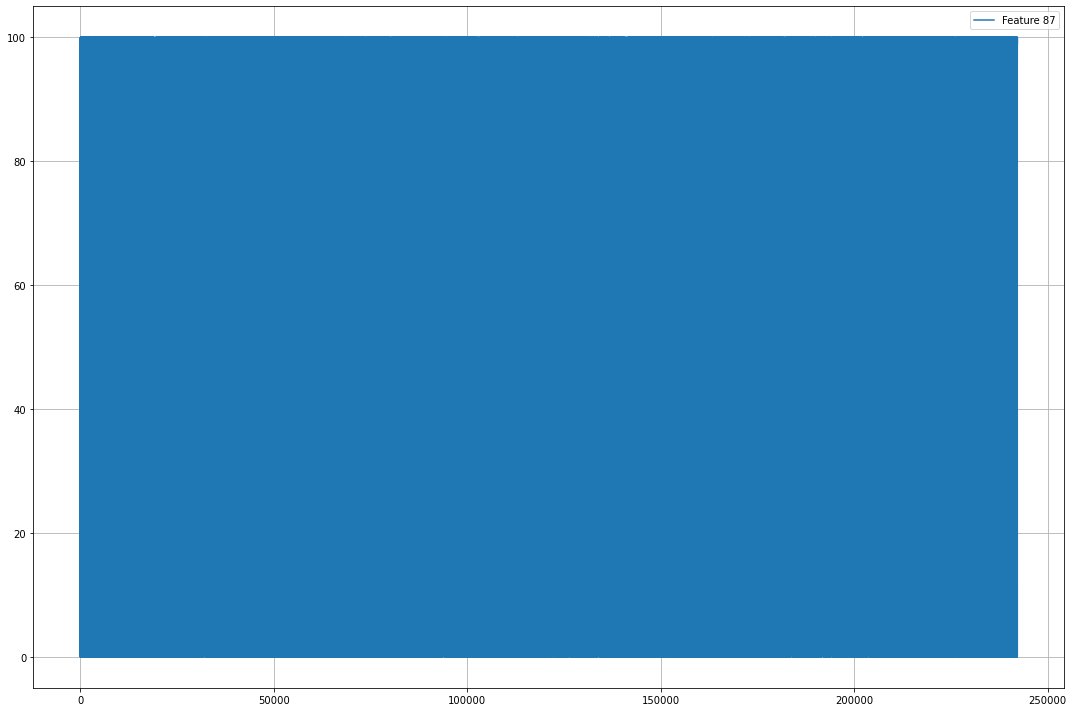

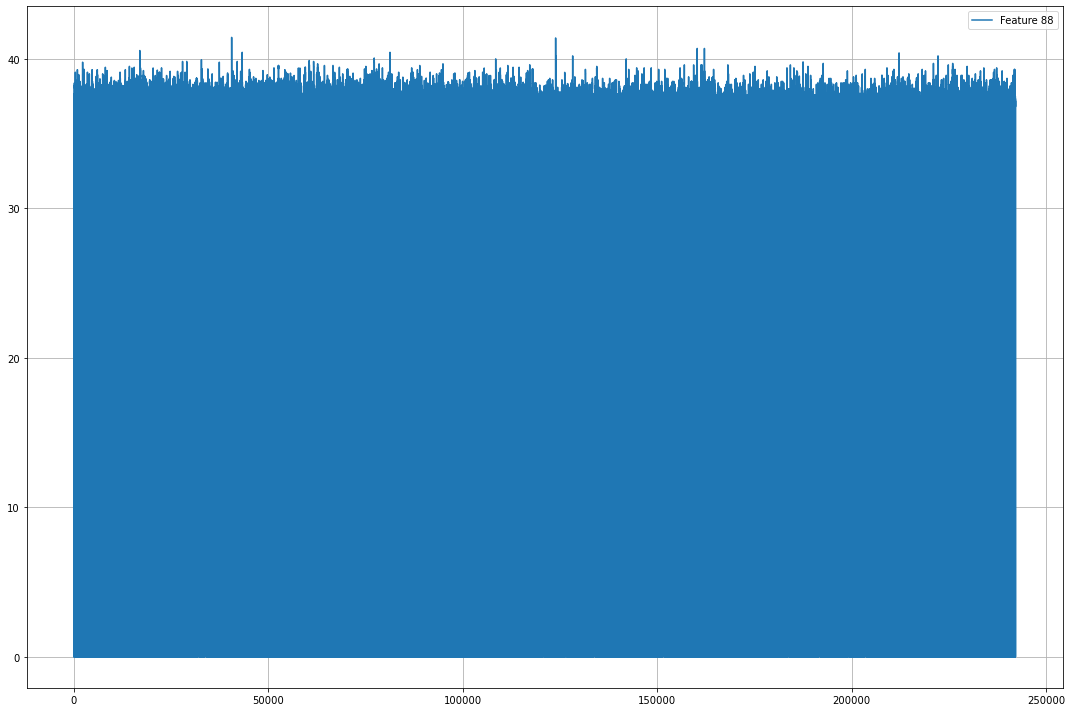

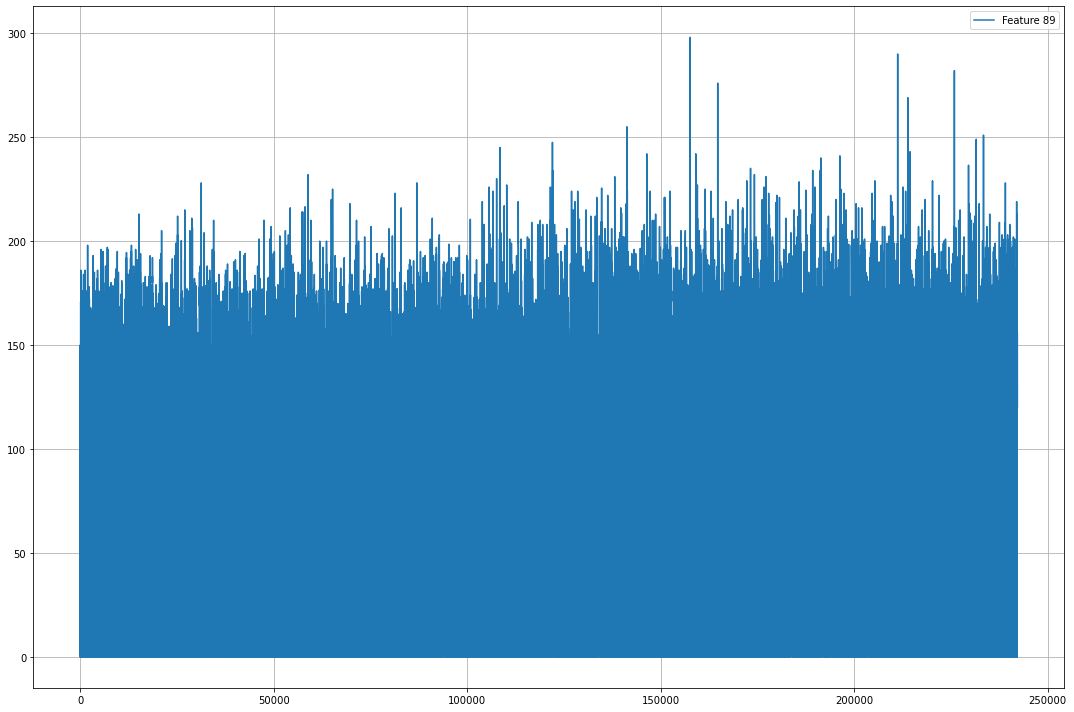

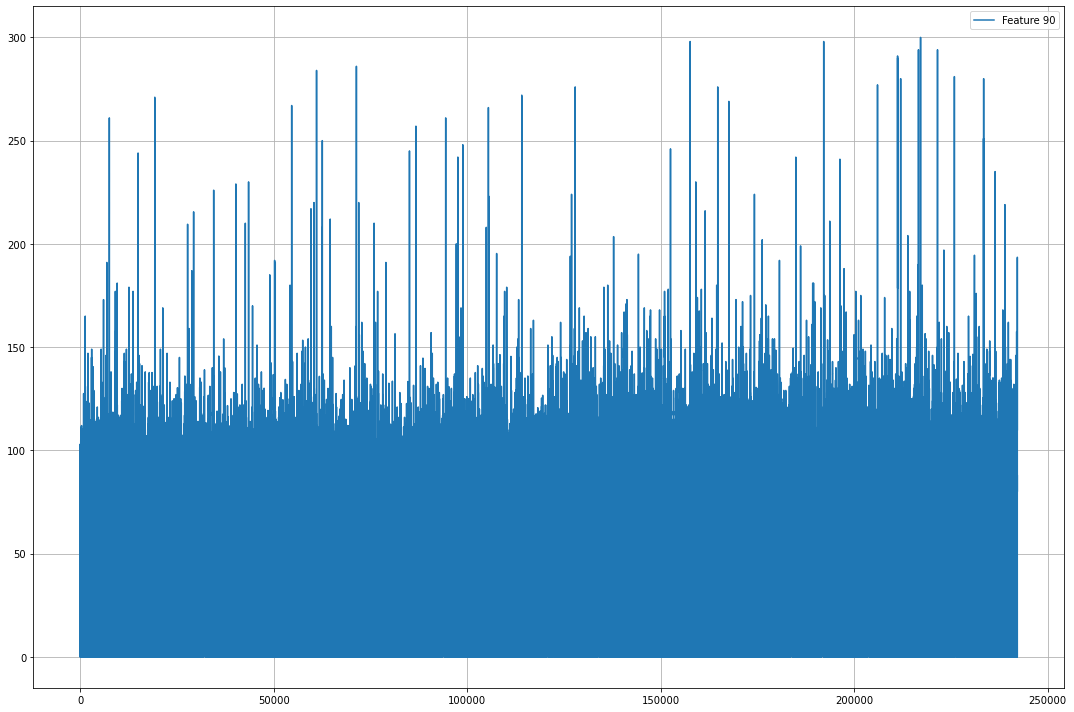

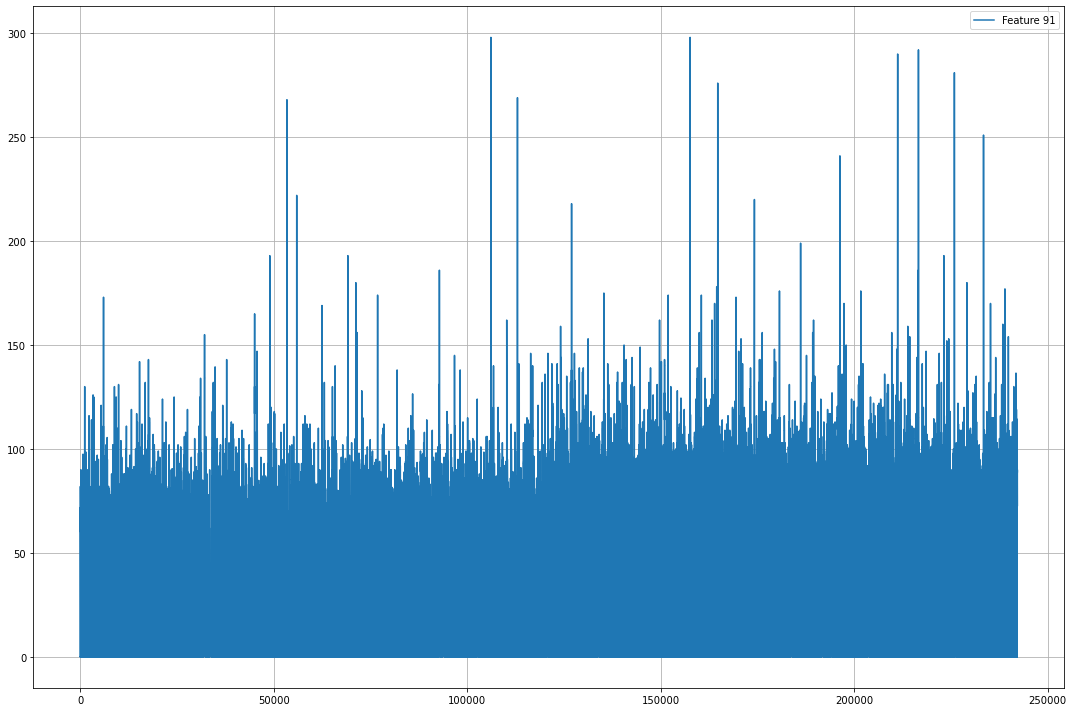

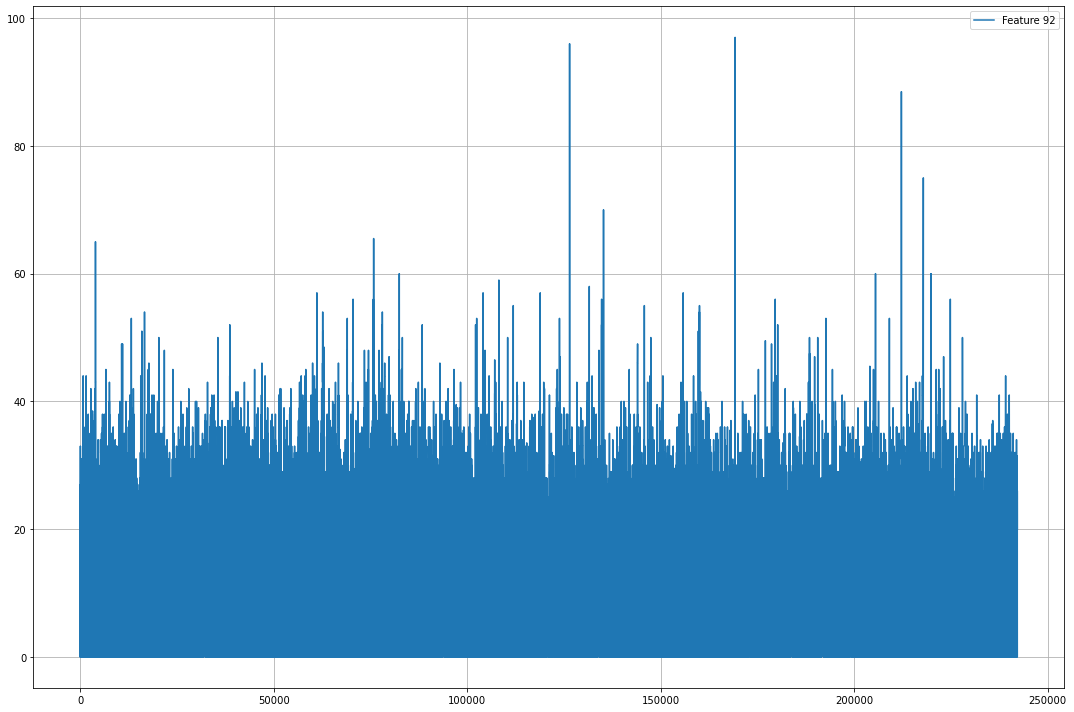

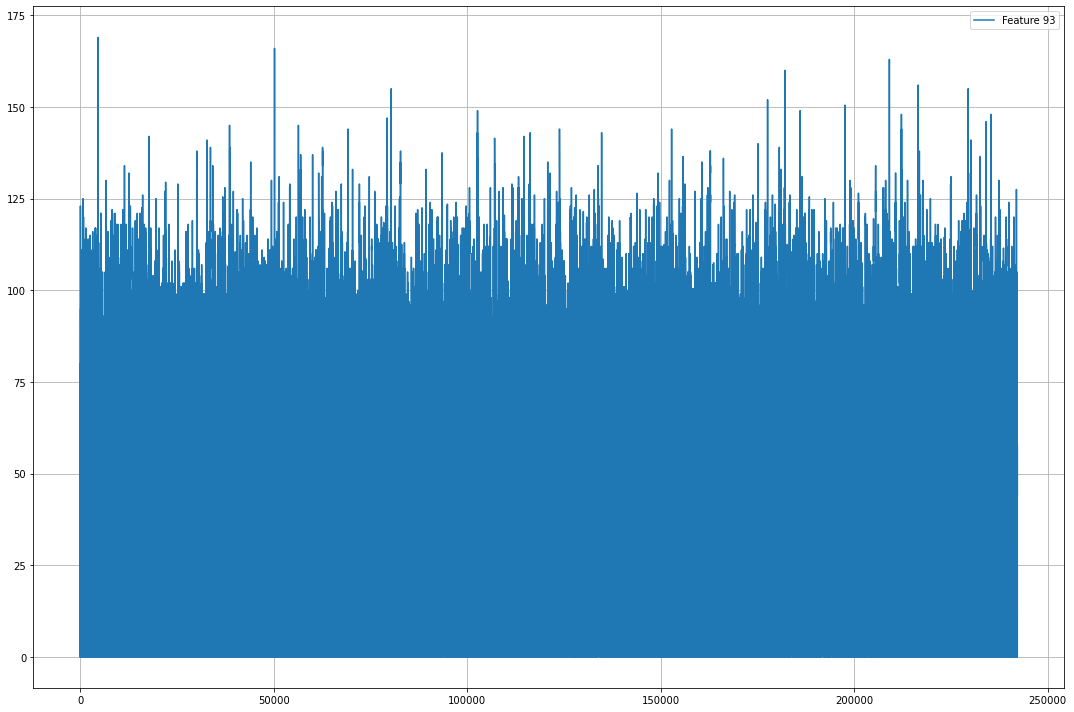

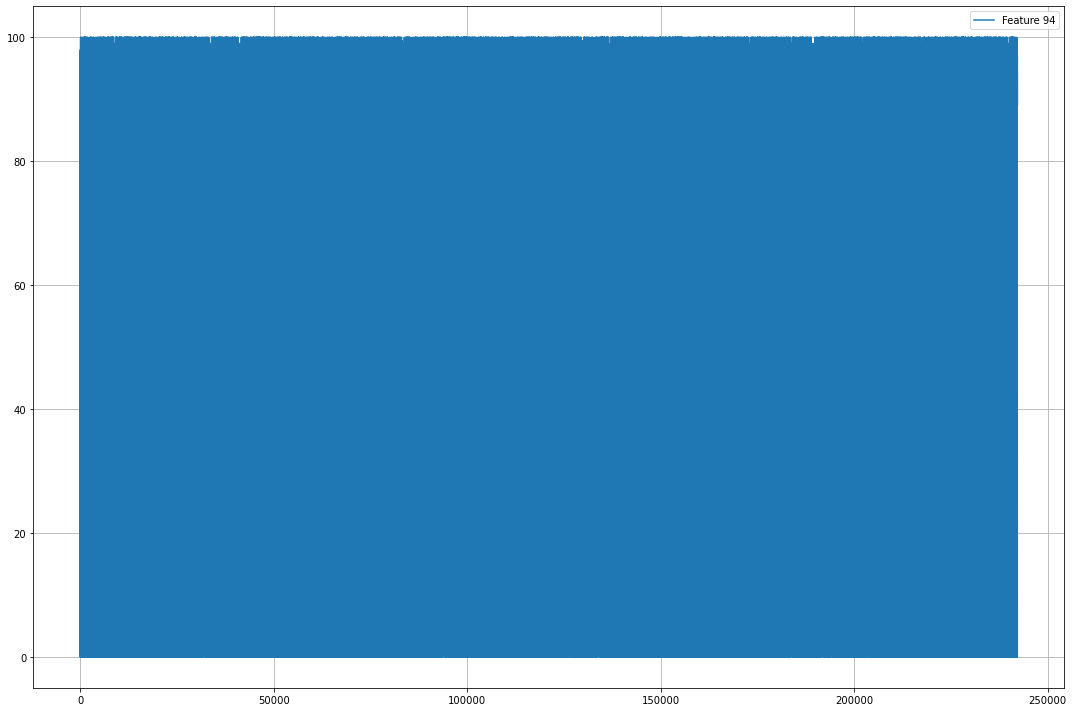

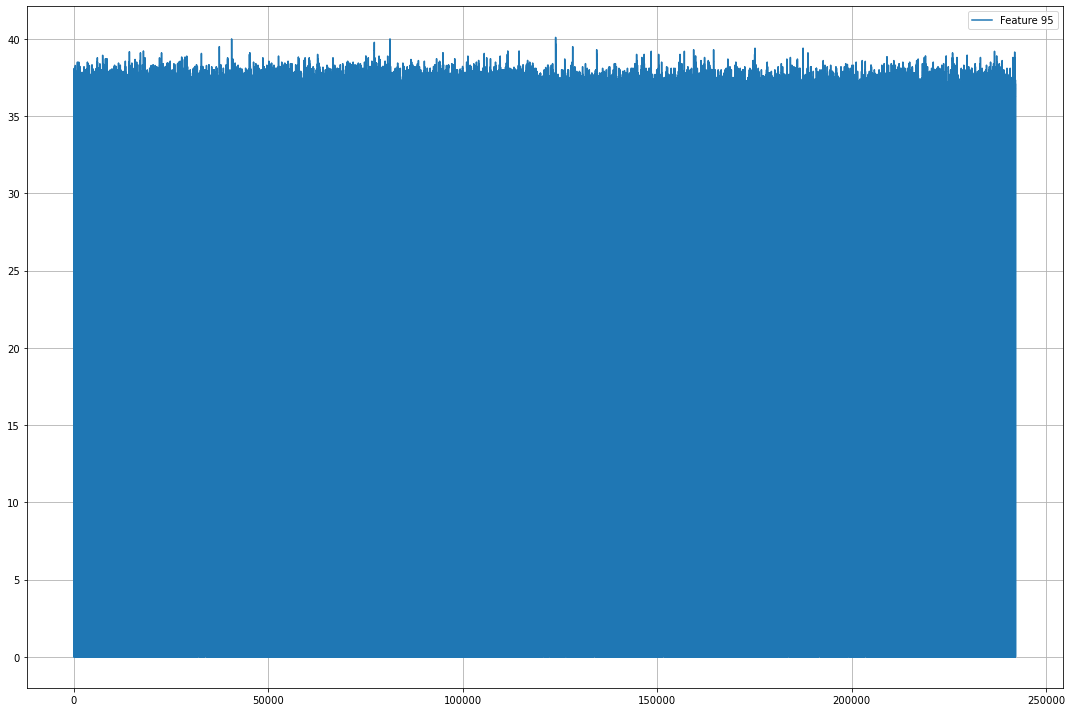

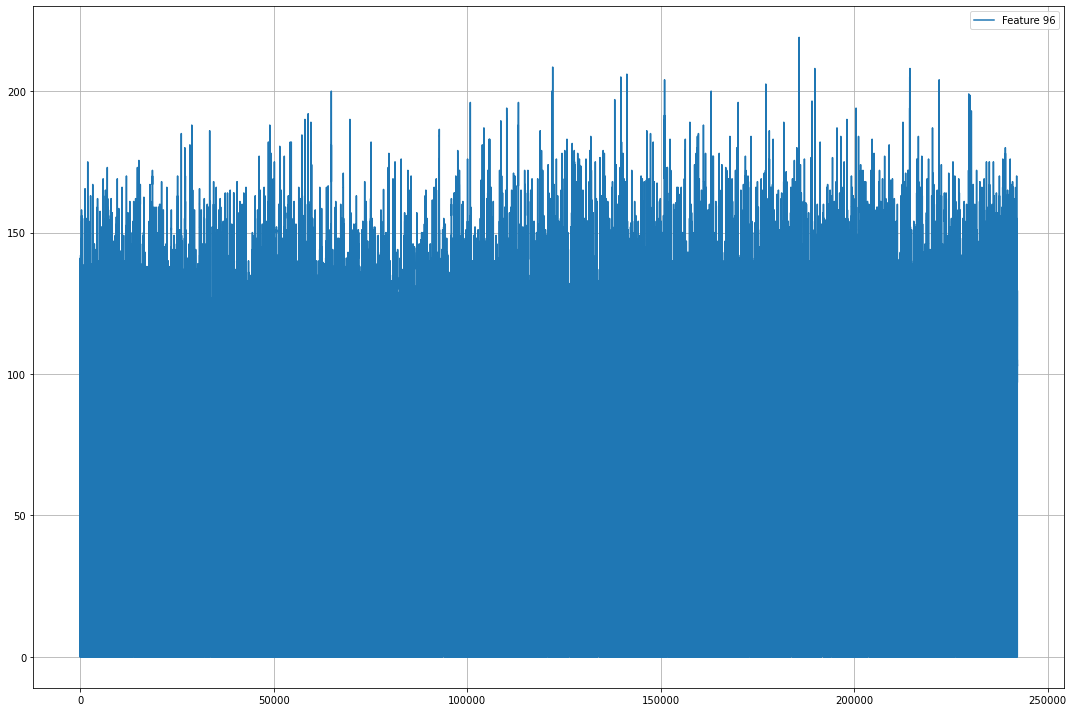

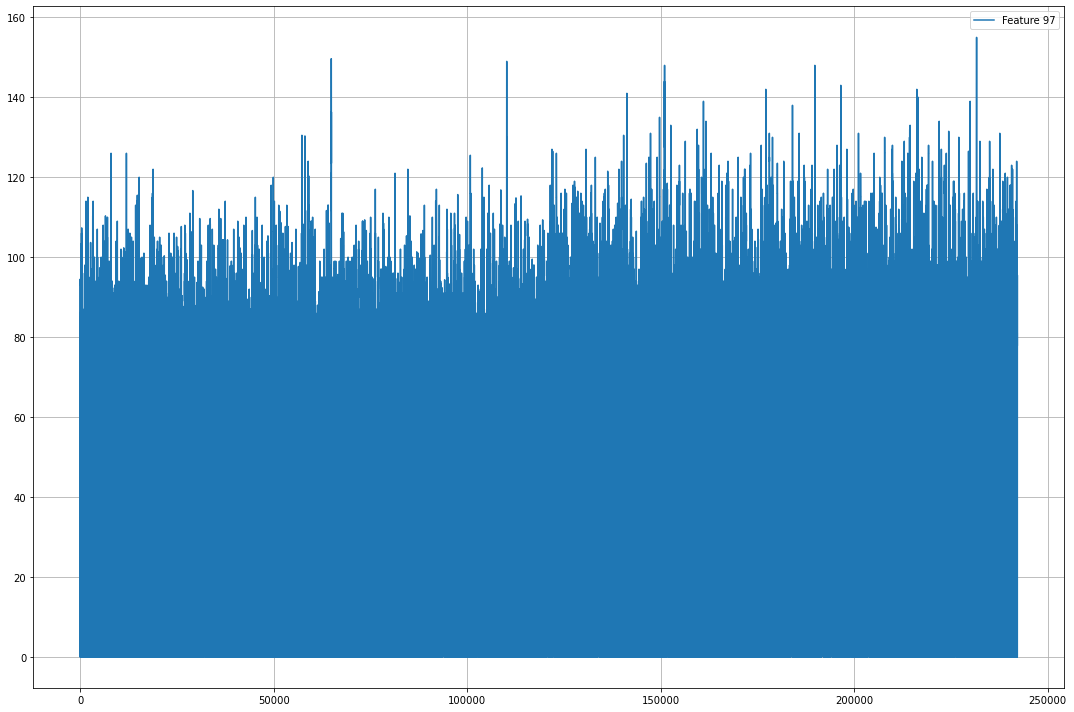

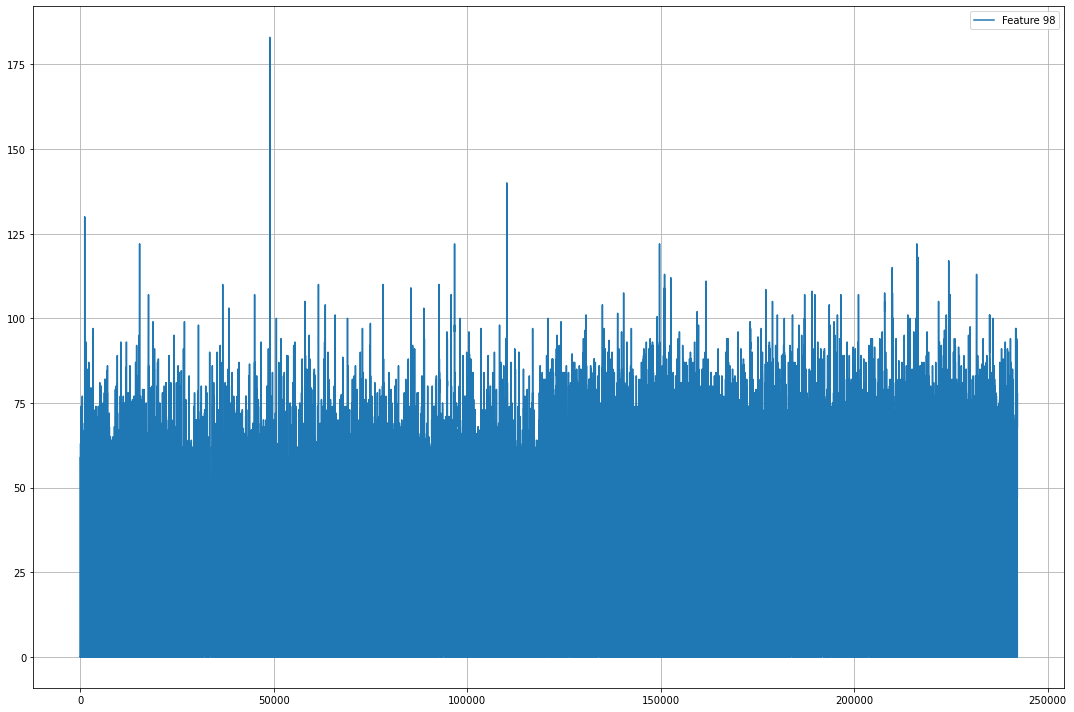

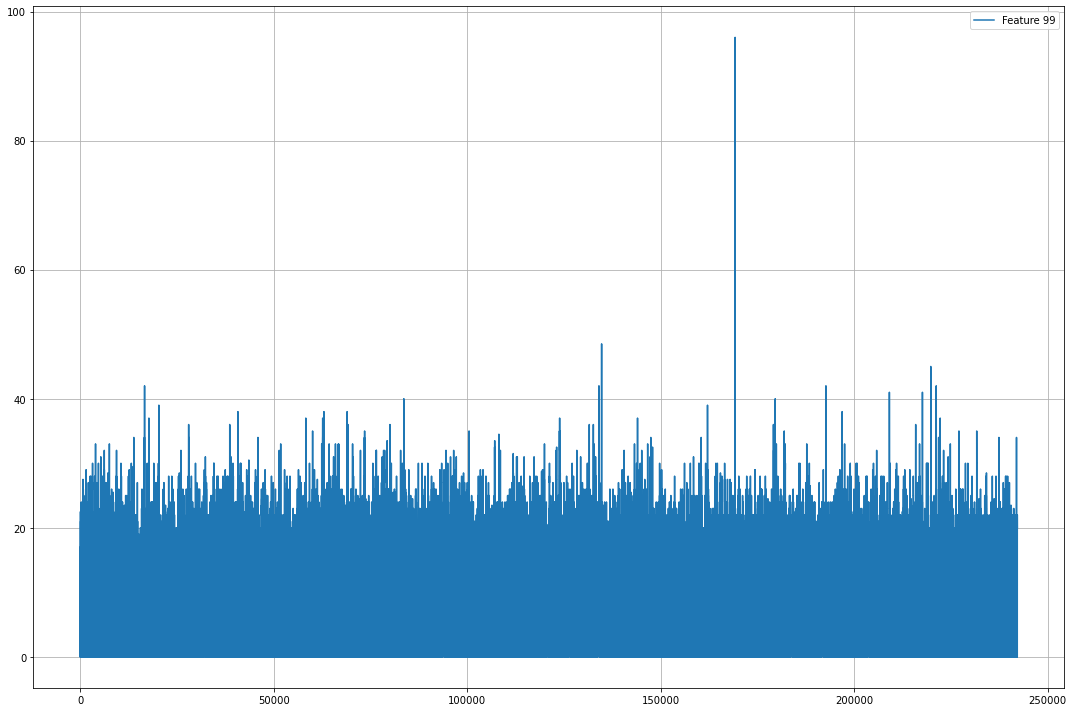

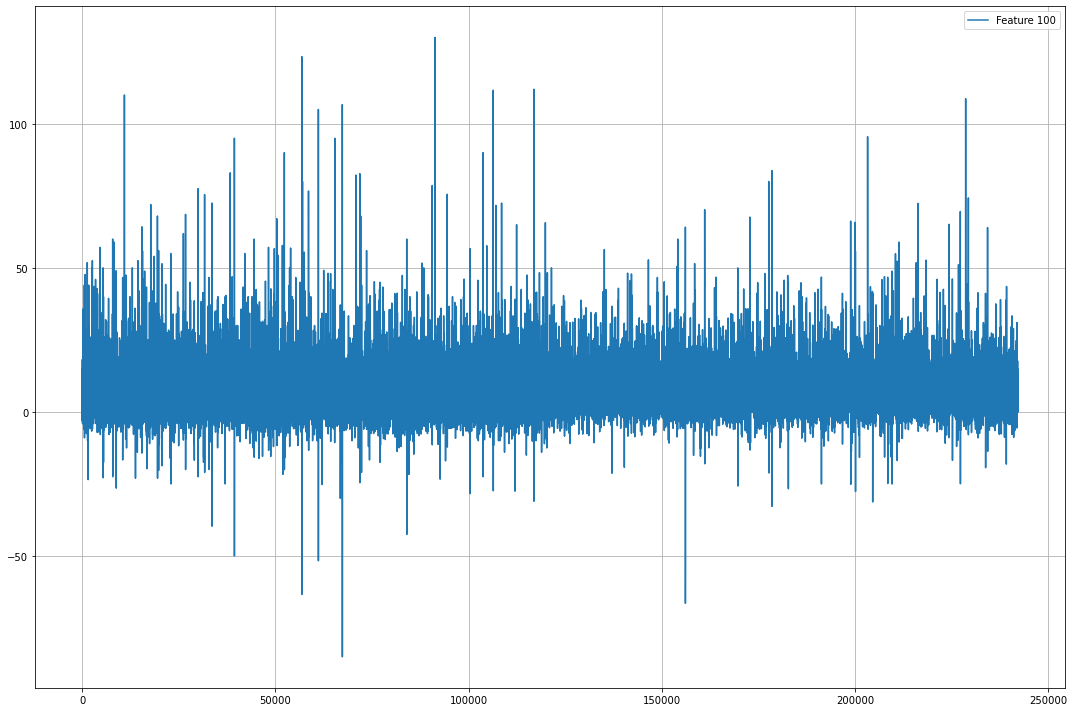

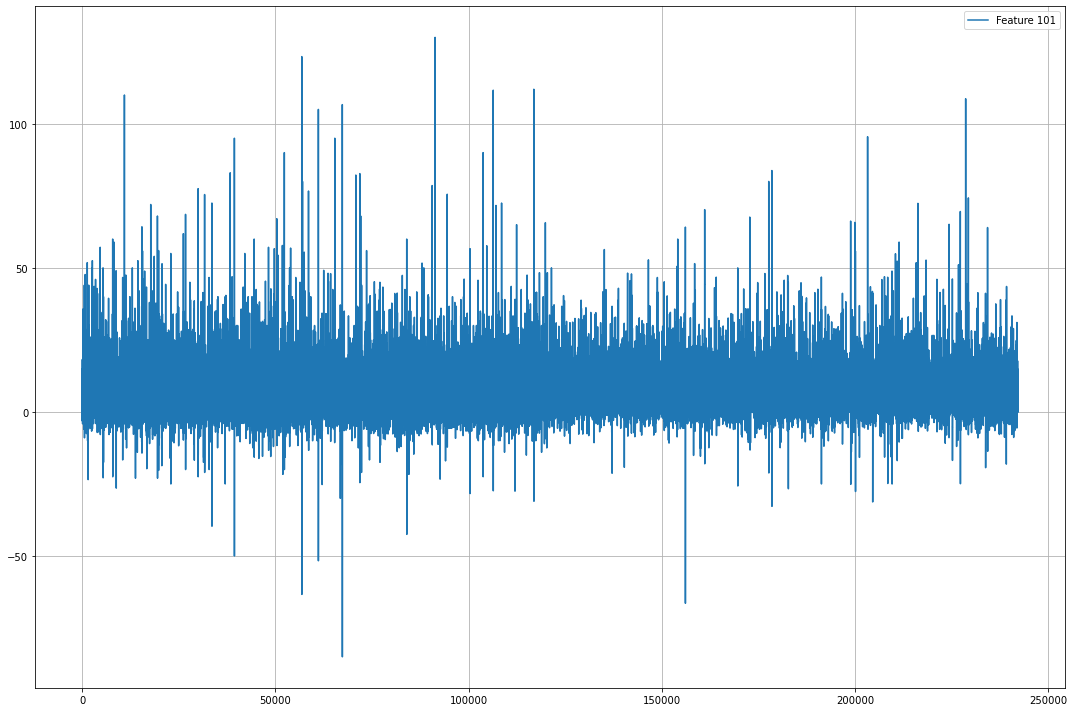

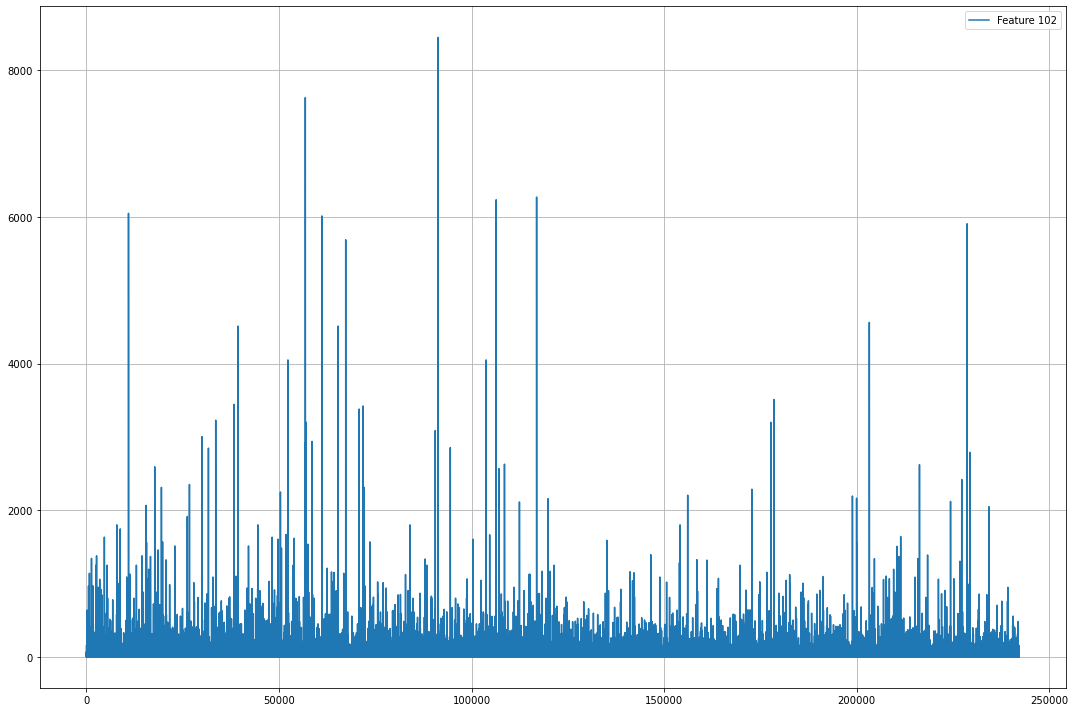

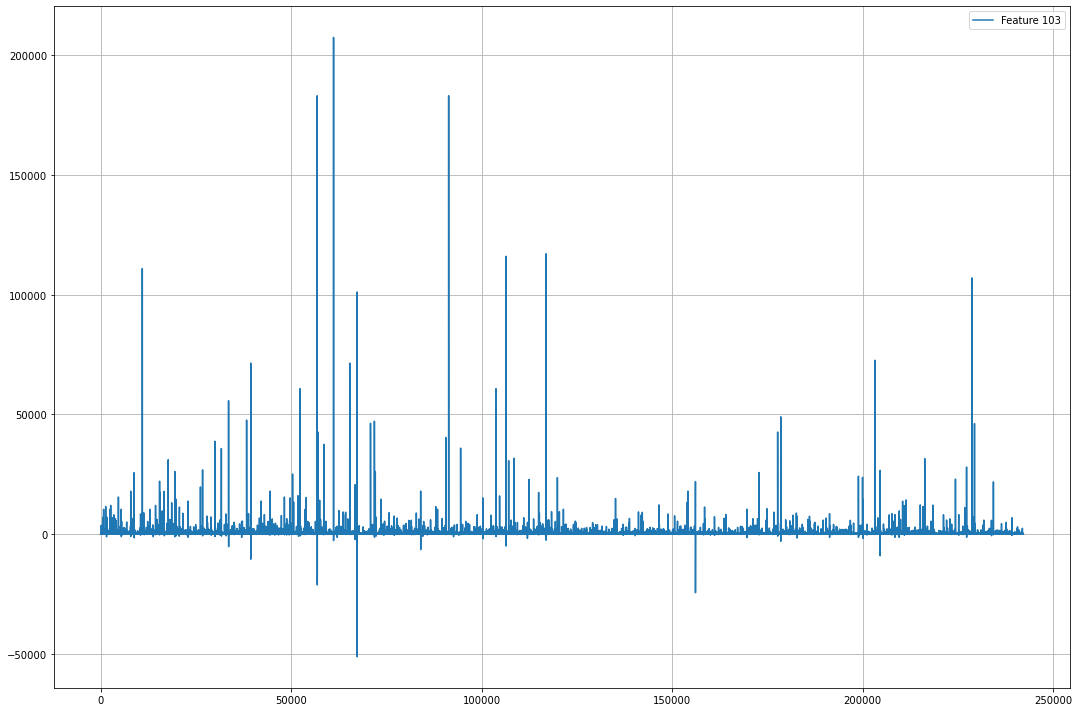

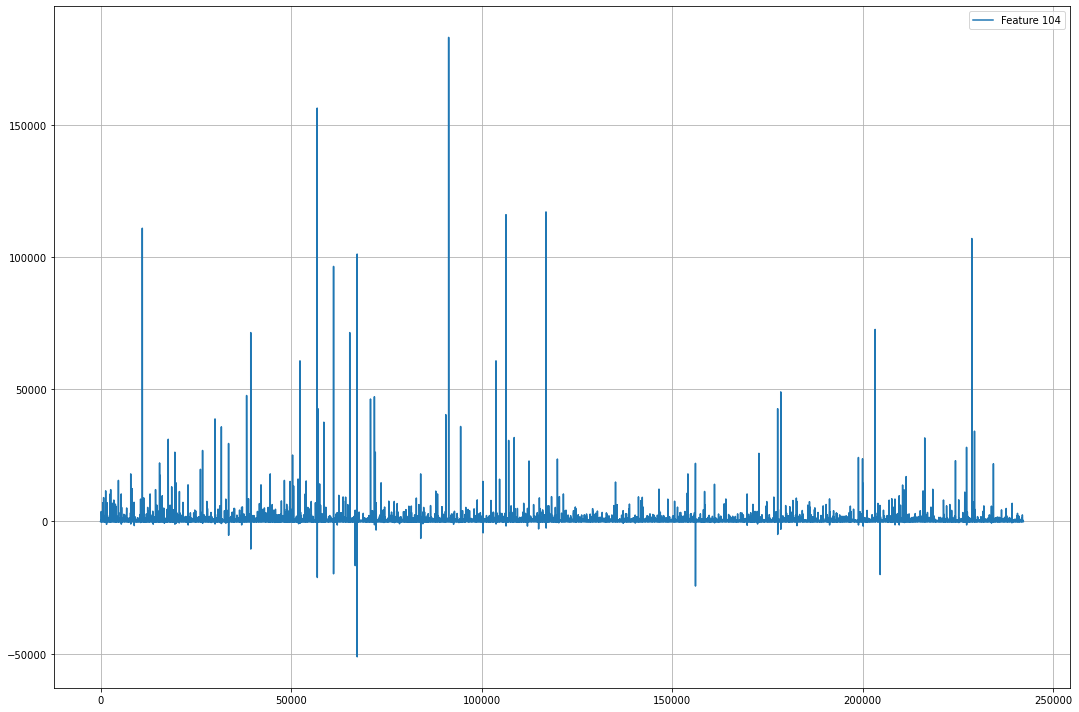

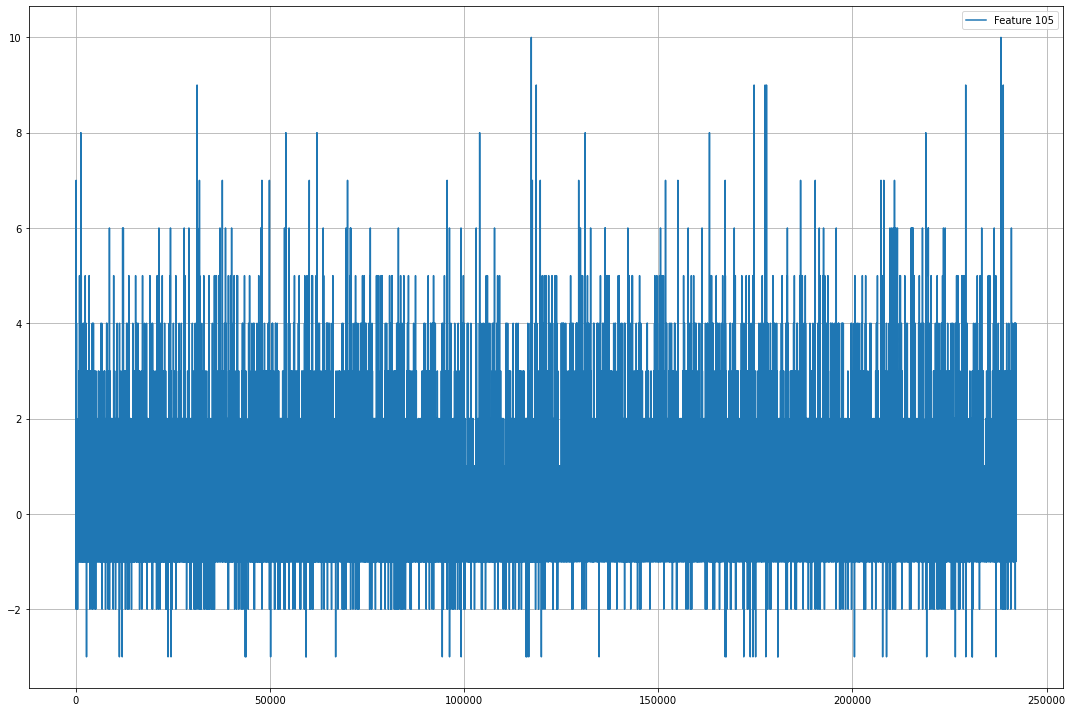

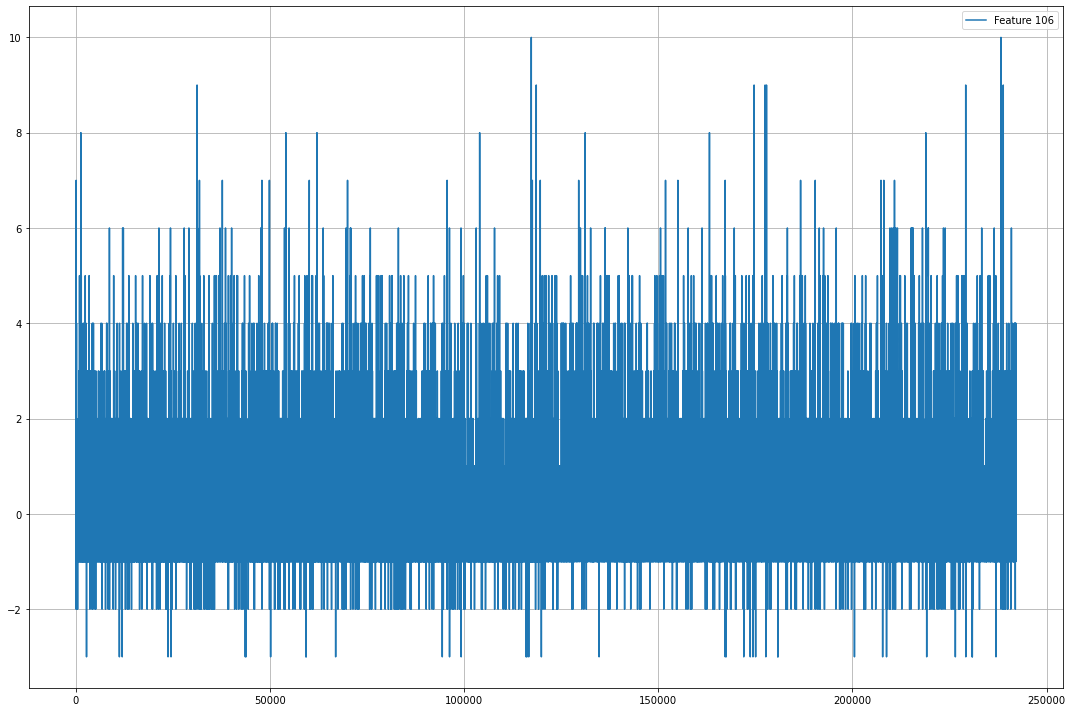

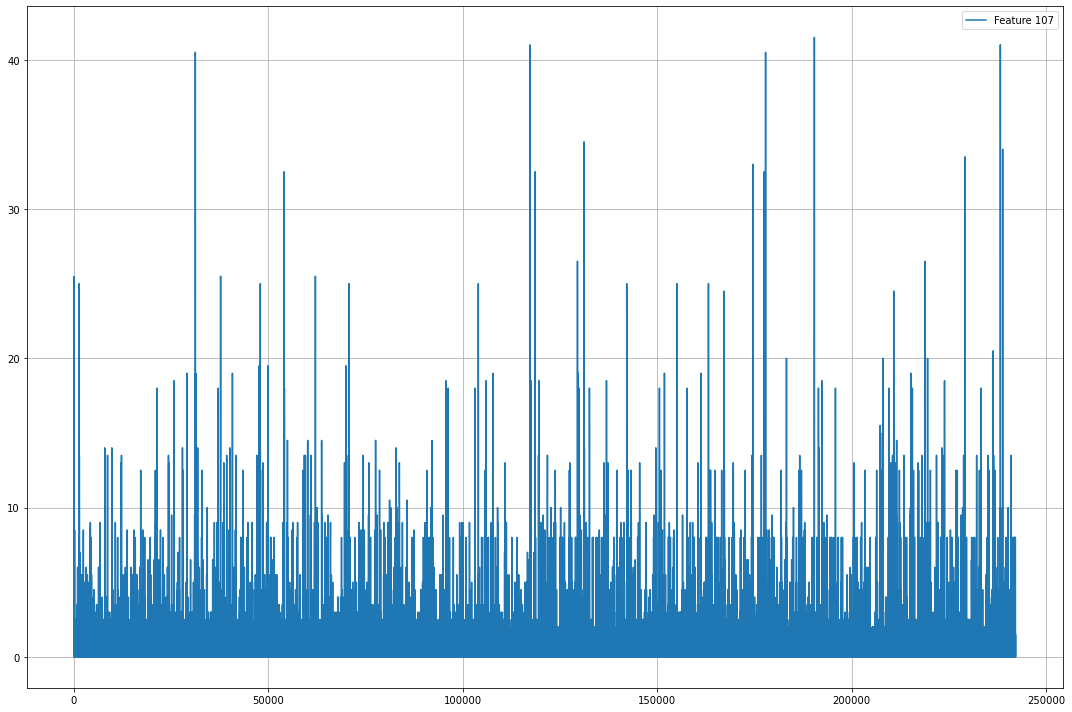

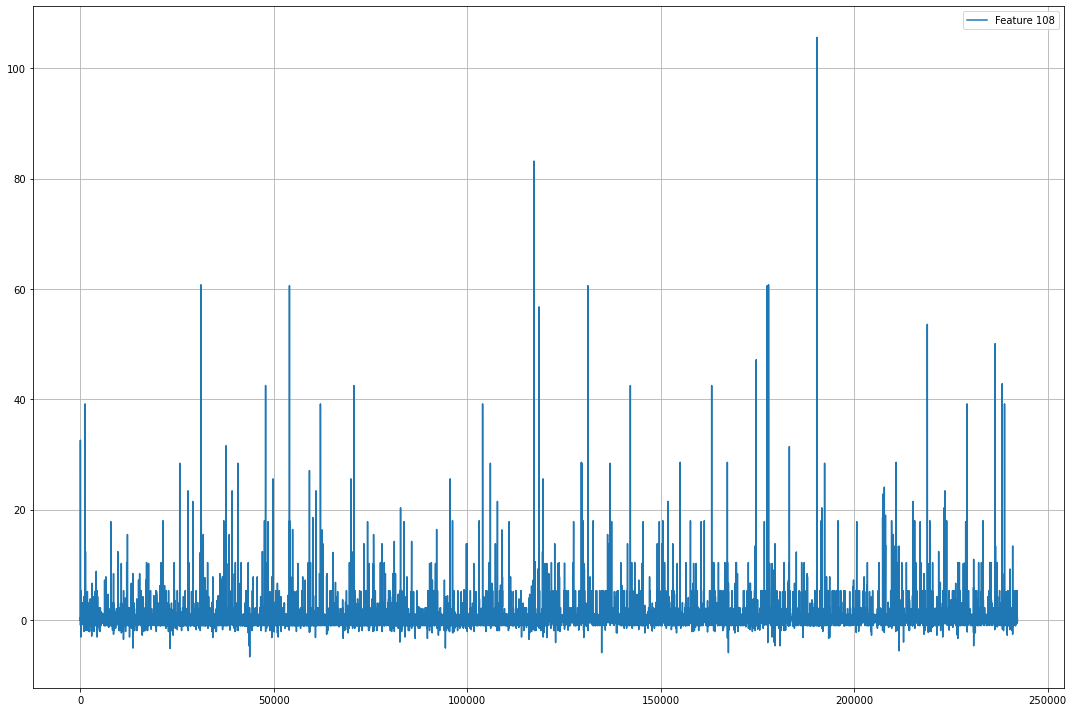

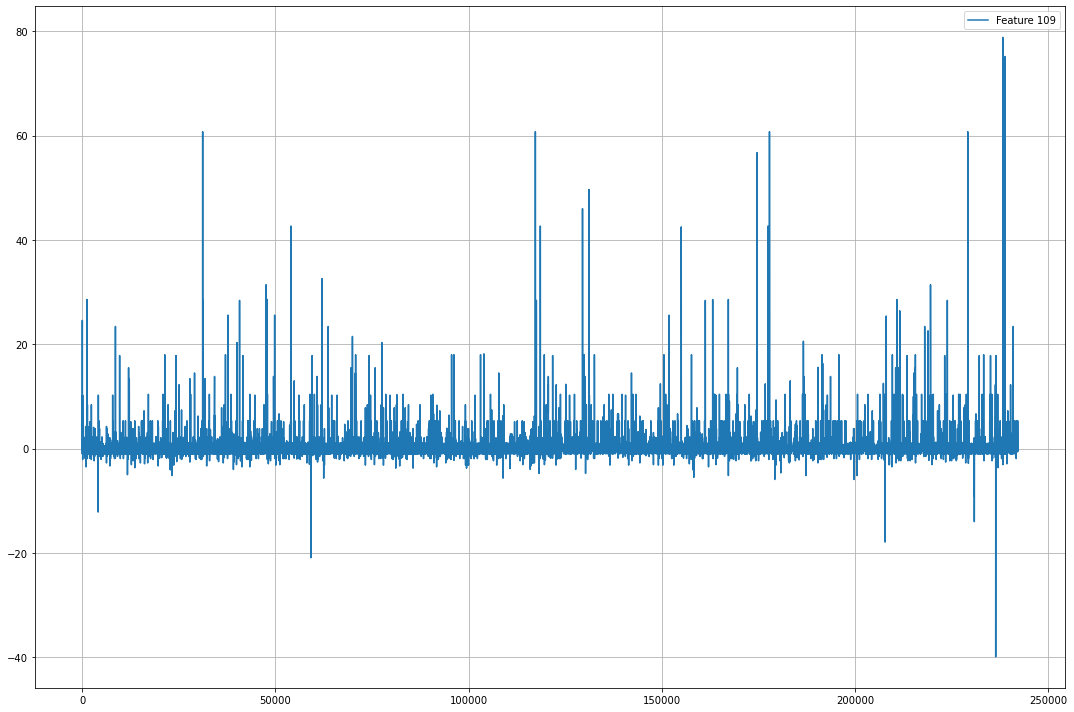

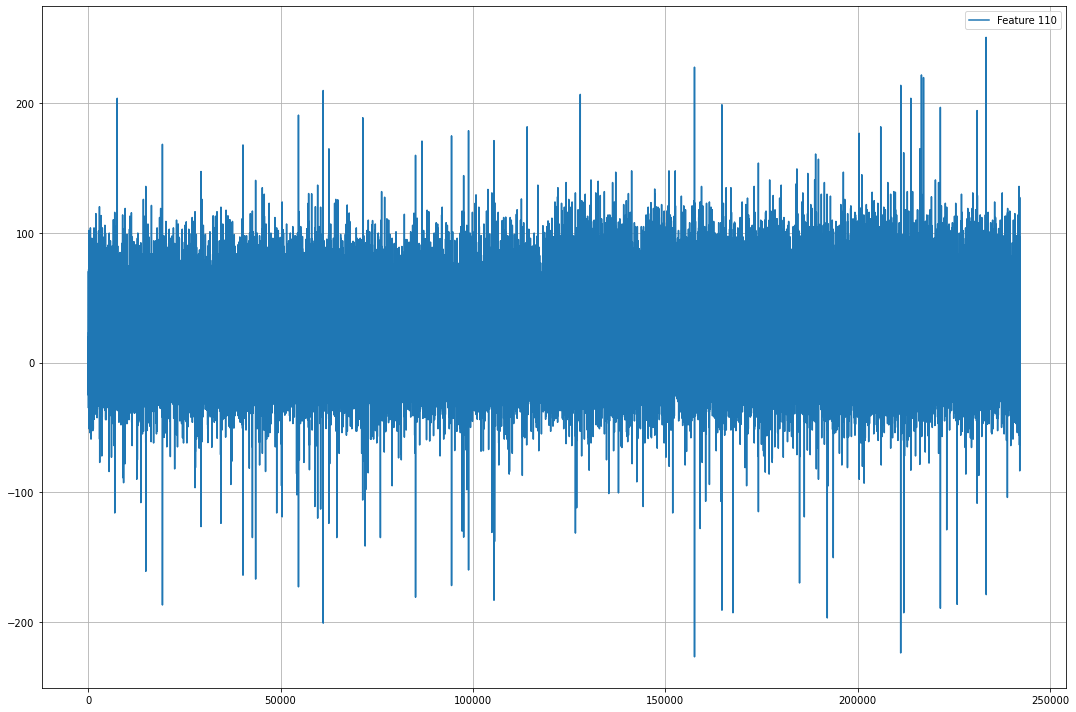

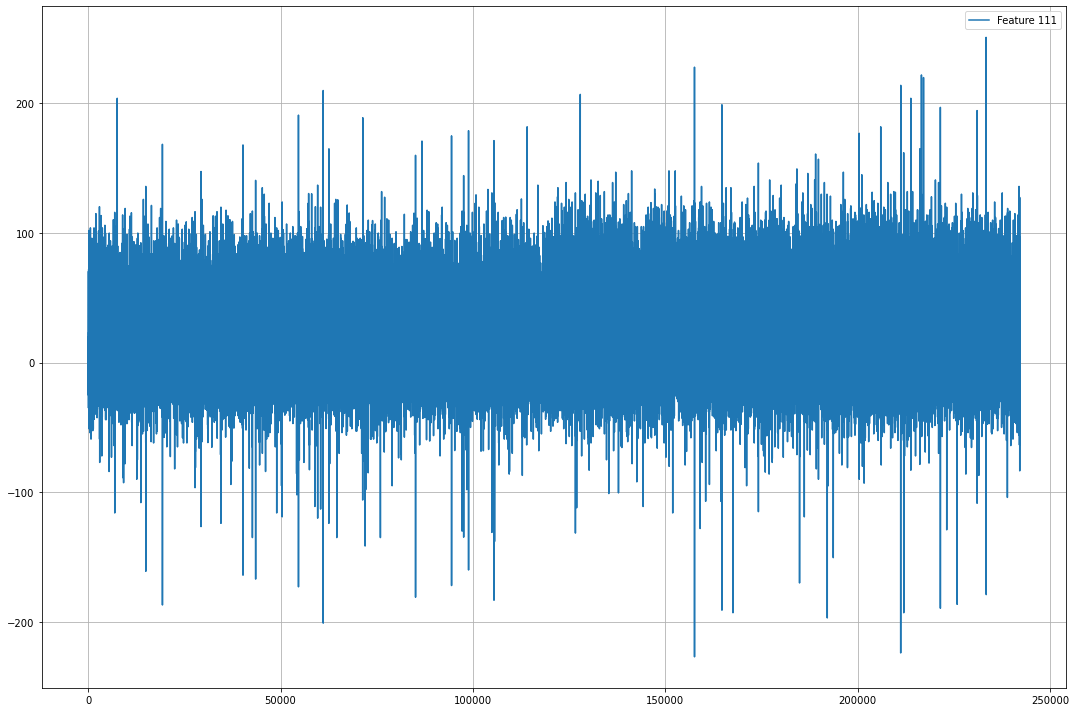

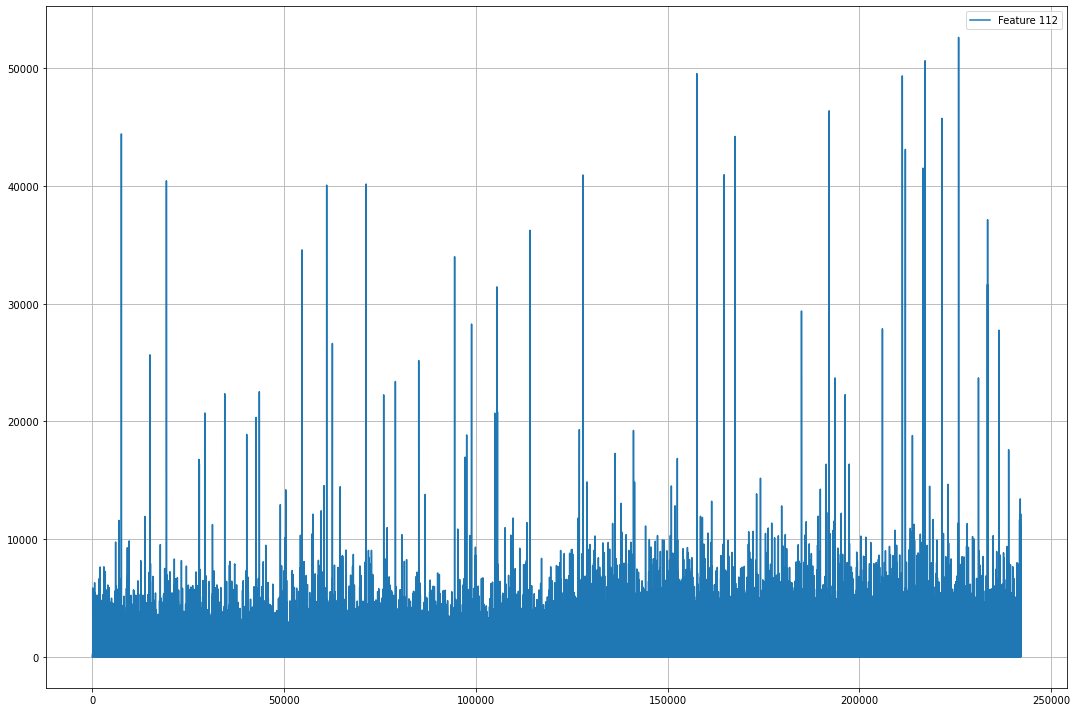

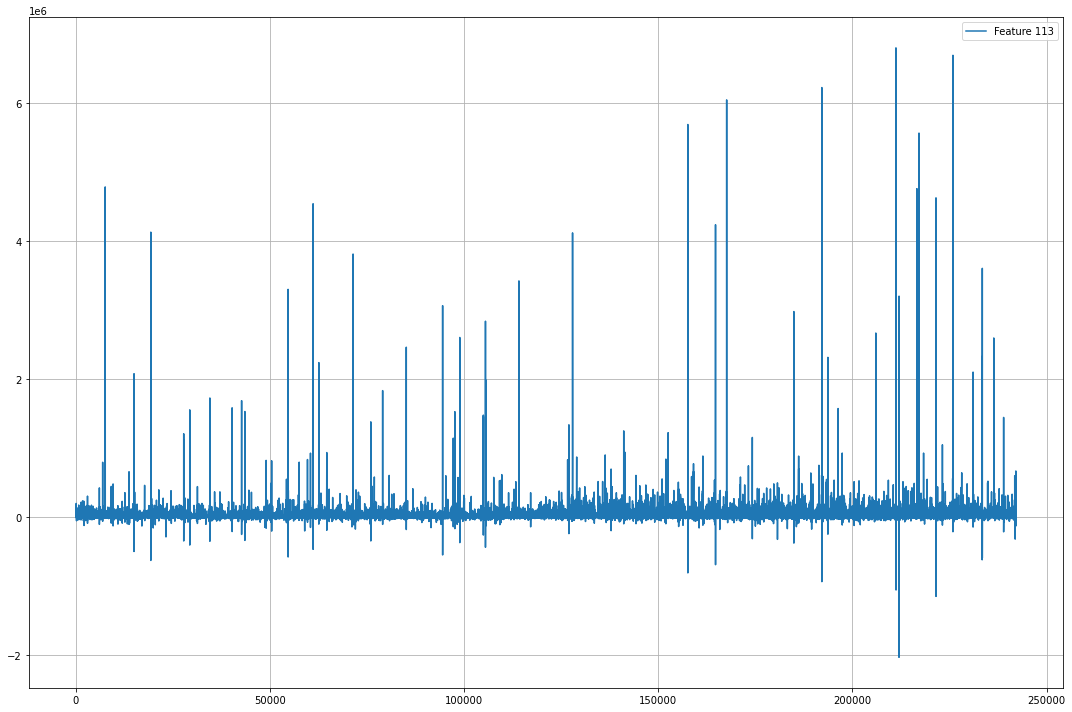

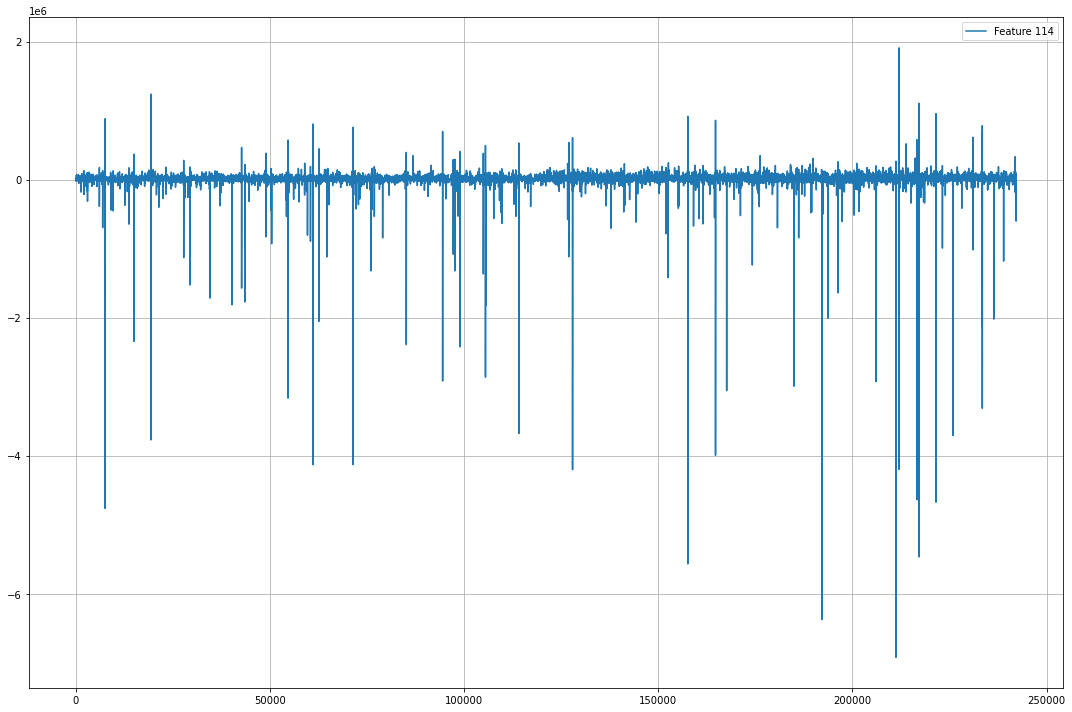

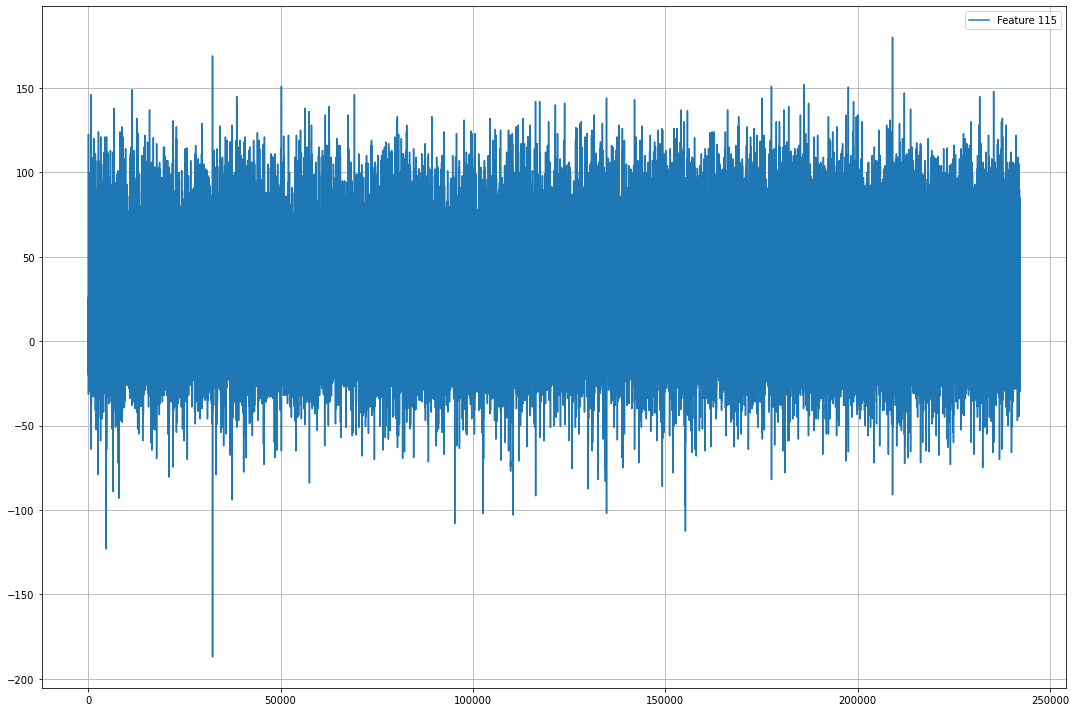

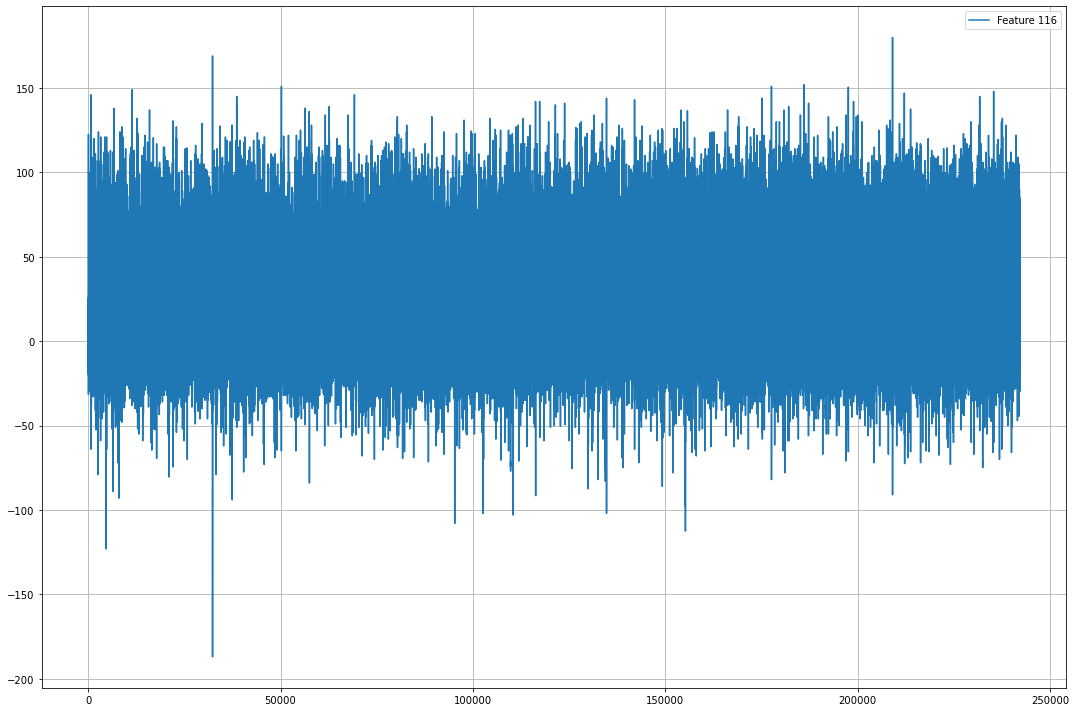

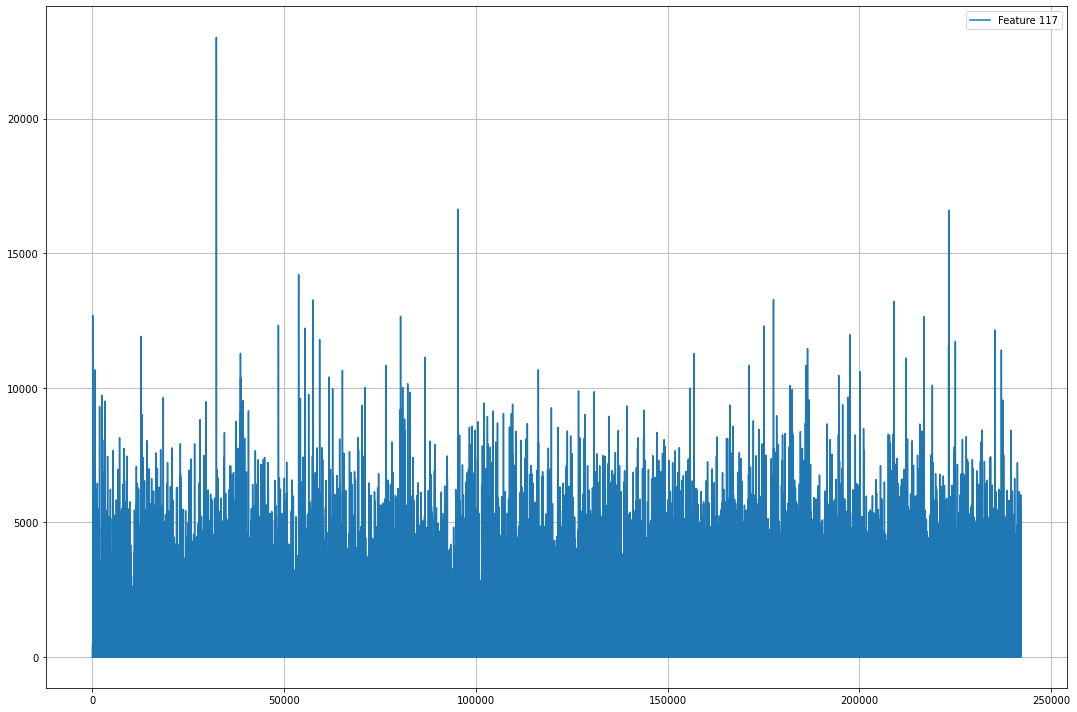

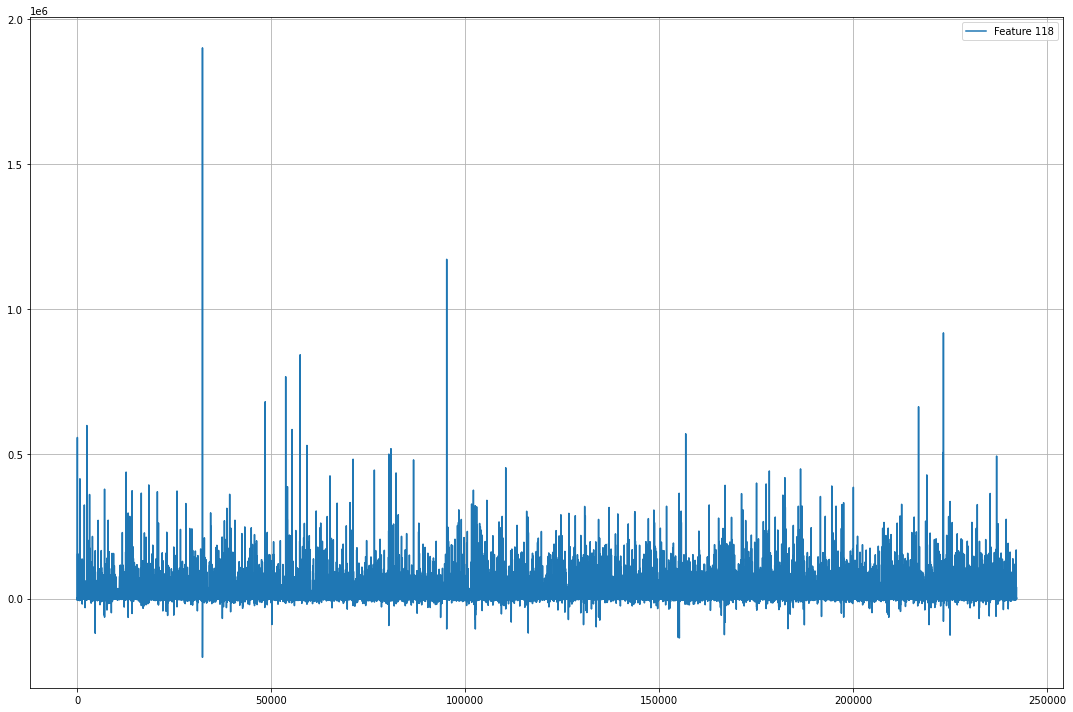

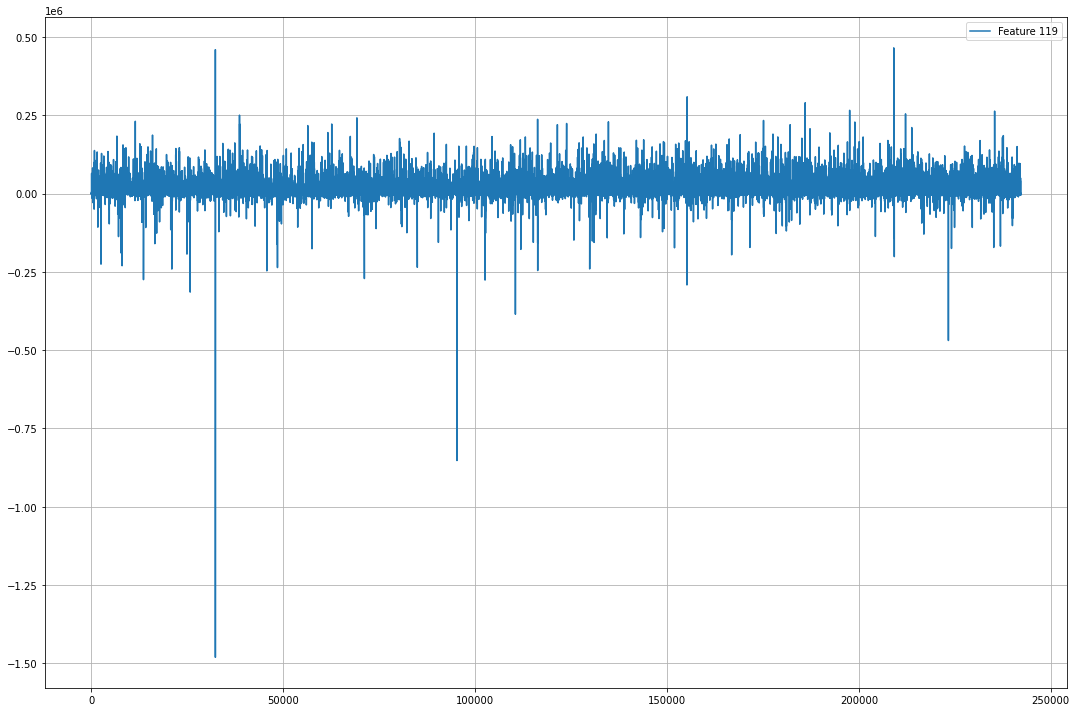

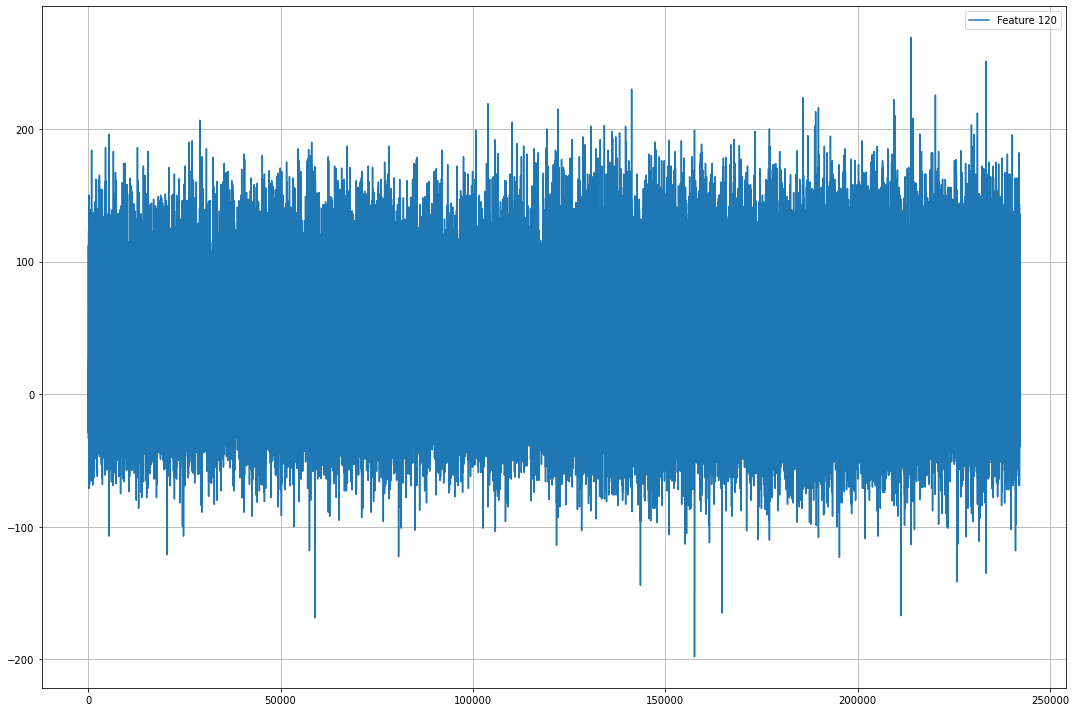

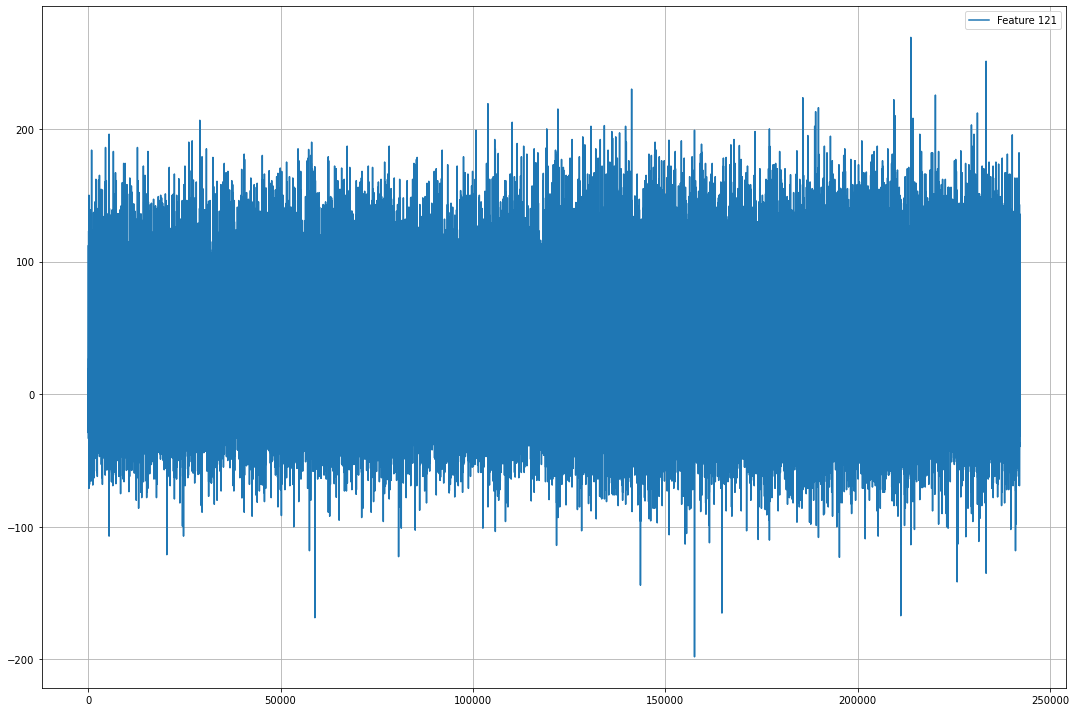

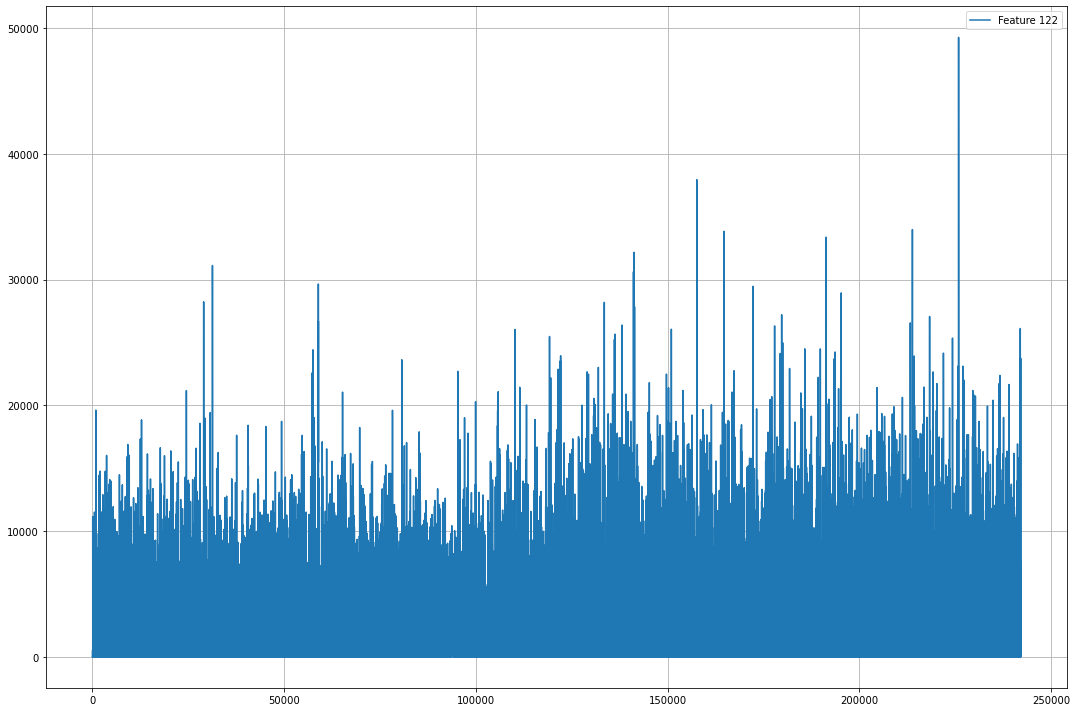

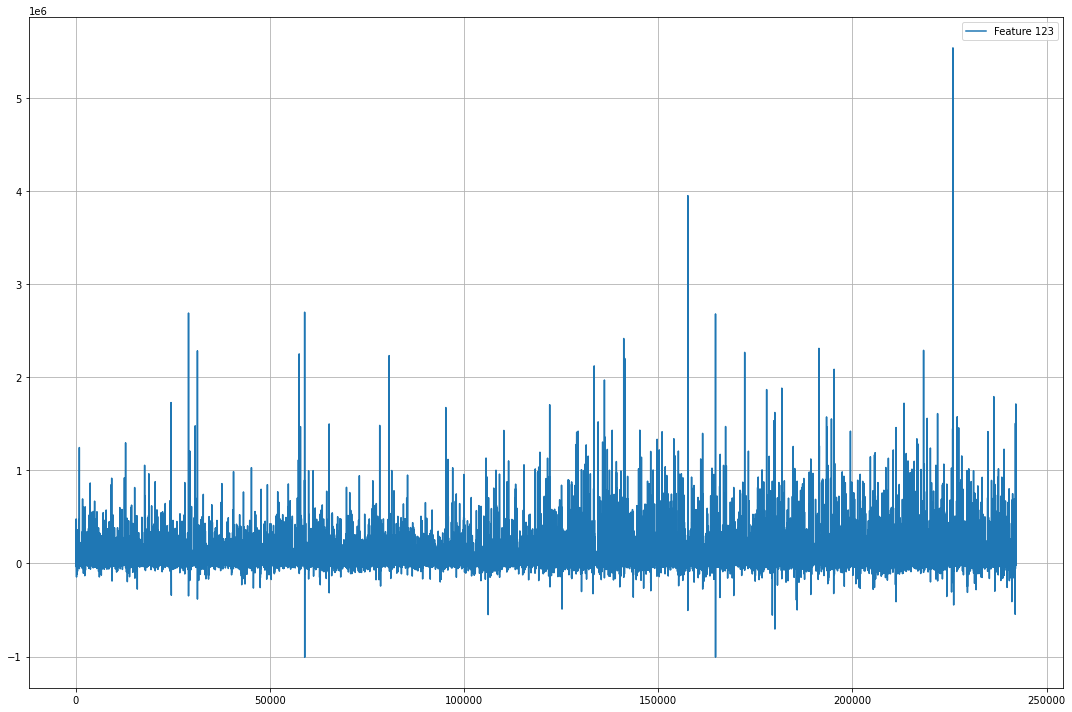

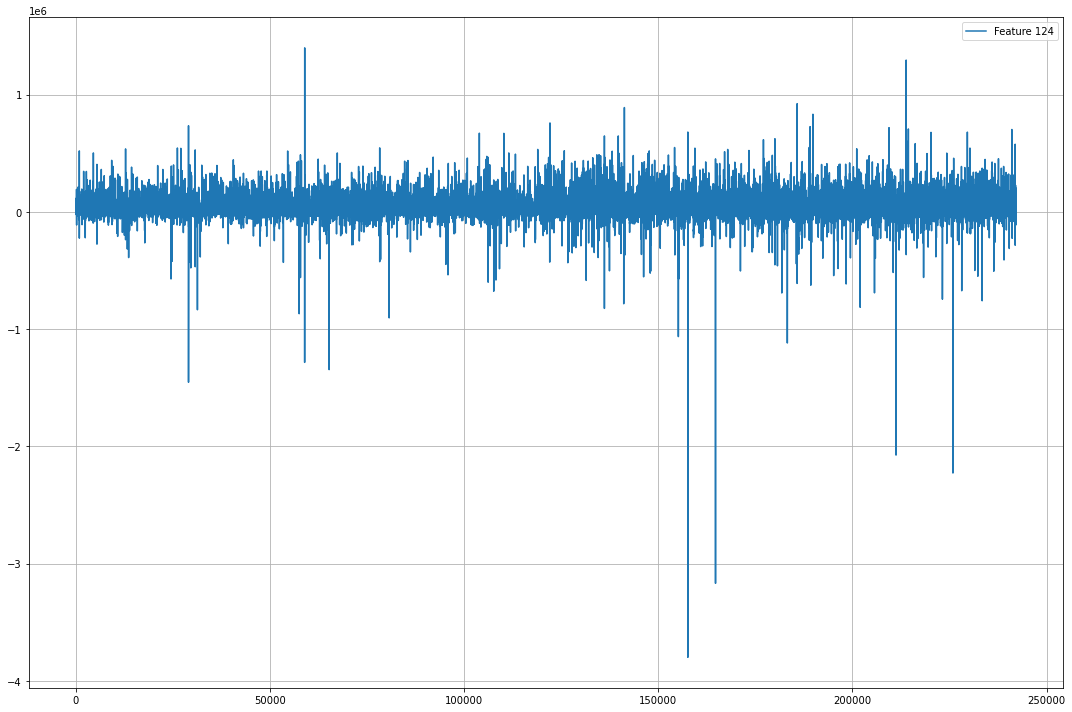

In [105]:
import matplotlib.gridspec as gridspec

for i in range(125):
    fig = plt.figure(figsize=(20,10), tight_layout=True)
    gs = gridspec.GridSpec(1, 2, width_ratios =[3, 1])
    ax1 = plt.subplot(gs[0])
    ax1.grid()
    ax1.plot(data[:, i], label = 'Feature '+str(i))

    plt.legend()
    plt.show()

In [115]:
X = data[120492:].numpy()
y = labels[120492:].numpy()

In [116]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [117]:
lgb_train = lgb.Dataset(X, y)

In [118]:
#y_train = y_train.ravel()
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

gbm = None
params = {
    'task': 'train',
    'application': 'regression',  # objective function
    'boosting_type': 'gbdt',  # Setting Upgrade Types
    'learning_rate': 0.01,  # Learning rate
    'num_leaves': 70,  # Number of leaf nodes
    'tree_learner': 'serial',
    'min_data_in_leaf': 100,
    'metric': ['l1', 'l2', 'rmse', 'mse', 'mae'],  # l1:mae, l2:mse  # Evaluation function
    'max_bin': 255,
    'num_trees': 300,
    'min_split_gain': 0.001,
    'bagging_fraction': 0.8,
    'feature_fraction': 0.9,
    'max_depth': 23,
    'min_child_weight': 10,
}

In [119]:
clf2 = lgb.train(params,
    lgb_train,
    num_boost_round=1000,
    valid_sets=lgb_eval,
    init_model=gbm,  # If gbm is not None, then it is on the basis of the last training.
    # feature_name=x_cols,
    early_stopping_rounds=100,
    verbose_eval=False,
    keep_training_booster=True)  # Incremental training

c:\users\abba\downloads\sepsis_competition_physionet_2019-master-20220207t204138z-001\sepsis_competition_physionet_2019-master\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\users\abba\downloads\sepsis_competition_physionet_2019-master-20220207t204138z-001\sepsis_competition_physionet_2019-master\venv\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\users\abba\downloads\sepsis_competition_physionet_2019-master-20220207t204138z-001\sepsis_competition_physionet_2019-master\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18206
[LightGBM] [Info] Number of data points in the train set: 109502, number of used features: 124
[LightGBM] [Info] Start training from score -0.023441


In [120]:
cv_results = lgb.cv(
        params,
        lgb_train,
        num_boost_round=10,
        nfold=5,
        early_stopping_rounds=10,
        # This is what I added
        stratified=False
        )

c:\users\abba\downloads\sepsis_competition_physionet_2019-master-20220207t204138z-001\sepsis_competition_physionet_2019-master\venv\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\users\abba\downloads\sepsis_competition_physionet_2019-master-20220207t204138z-001\sepsis_competition_physionet_2019-master\venv\lib\site-packages\lightgbm\engine.py:577: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049990 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18206
[LightGBM] [Info] Number of data points in the train set: 87600, number of used features: 124
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021015 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18206
[LightGBM] [Info] Number of data points in the train set: 87600, number of used features: 124
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18206
[LightGBM] [Info] Number of data points in the train set: 87600, number of used feat

In [121]:
cv_results

{'l1-mean': [0.05184703415856233,
  0.051766953046645095,
  0.05168414301417179,
  0.051600927216872074,
  0.0515205398800487,
  0.051441804446944406,
  0.051363254819522655,
  0.05129786973075039,
  0.05121694077281408,
  0.05114010669711472,
  0.051064639859743764,
  0.05098779154362507,
  0.050910767018854206,
  0.05083707944798066,
  0.050761163457516176,
  0.05068370011345459,
  0.05060919034768467,
  0.05054940599730674,
  0.0504879524578835,
  0.050412340983601256,
  0.05034082553748488,
  0.05027473933630002,
  0.05020295591067958,
  0.05013233041852232,
  0.050056598547498346,
  0.04998331941736452,
  0.04991035642889076,
  0.04984161704779401,
  0.04977087348883925,
  0.04970103686893339,
  0.049629801116956584,
  0.049574307855976336,
  0.04950226510644158,
  0.04943331278587802,
  0.049361655245194244,
  0.04928959077447601,
  0.04922165069544151,
  0.049150483591821365,
  0.0490847456703332,
  0.04901660725274522,
  0.04895364257884137,
  0.04888822202114889,
  0.048823462

In [140]:
from src.model.optimizer import CVThresholdOptimizer
from sklearn.model_selection import cross_val_predict, KFold
import numpy as np
# Choose cross val method
cv = list(KFold(5).split(X))
predictions = cross_val_predict(clf2, X, y, cv=cv, n_jobs=-1)
# Evaluation
print('Thresholding...')
score = CVThresholdOptimizer(y, predictions, scores= scores[120492:]).optimize(cv, parallel=True)

print('Average: {:.3f}'.format(np.mean(score)))

TypeError: Cannot clone object '<lightgbm.basic.Booster object at 0x00000277F23FDF28>' (type <class 'lightgbm.basic.Booster'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' methods.

In [138]:
clf2.feature_importance(importance_type="gain")

array([5.06073184e+02, 1.49353070e+02, 2.50051523e+03, 2.22205316e+02,
       3.05518240e+02, 1.67519457e+02, 6.85001949e+02, 7.72319582e+02,
       1.25479897e+03, 1.00100112e+02, 9.54143659e+02, 1.63841358e+03,
       1.82243556e+03, 9.39311685e+02, 1.43292527e+03, 1.79672972e+03,
       2.45227159e+03, 1.04252281e+03, 2.35764988e+02, 1.79376354e+03,
       1.52893546e+02, 1.15268528e+03, 1.19834882e+03, 1.20662662e+03,
       1.77802139e+03, 1.58802601e+03, 1.22068119e+03, 6.79527873e+02,
       1.43081020e+03, 1.16871145e+03, 1.24534284e+03, 3.40201555e+03,
       1.10879764e+03, 1.75942966e+03, 3.69676835e+03, 9.53972682e+01,
       1.38760548e+02, 1.54814589e+02, 4.13379658e+03, 9.03078697e+03,
       0.00000000e+00, 3.88257476e+02, 2.70836773e+02, 2.53891543e+02,
       9.76456404e-01, 1.94357801e+02, 1.75376060e+03, 3.38803797e+03,
       6.92716494e+02, 6.46597943e+01, 1.95972904e+01, 1.91335487e+00,
       5.34130819e+01, 5.83253739e+01, 0.00000000e+00, 2.69707334e+00,
      

In [133]:
score_train = dict([(s[1], s[2]) for s in clf2.eval_train()])
print('The score of the current model in the training set is: mae=%.4f, mse=%.4f, rmse=%.4f'
              % (score_train['l1'], score_train['l2'], score_train['rmse']))

from sklearn.metrics import r2_score


test_preds = clf2.predict(X_test)
train_preds = clf2.predict(X_train)

print("\nTest  R2 Score : %.2f"%r2_score(y_test, test_preds))
print("Train R2 Score : %.2f"%r2_score(y_train, train_preds))

The score of the current model in the training set is: mae=0.0369, mse=0.0216, rmse=0.1471

Test  R2 Score : 0.37
Train R2 Score : 0.43


In [38]:
data1 = data[:120492] # Hospital A
data2 = X # Hospital B

In [41]:
data2=torch.mean(data2, 1) # Calculate the mean of each torch row of Hospital B

In [49]:
from scipy.stats import ks_2samp

#perform Kolmogorov-Smirnov test
ks_2samp(data2[:50000], data2[50000:])

Ks_2sampResult(statistic=0.00642422402542131, pvalue=0.17870044301594948)

In [43]:
data1=torch.mean(data1, 1) # Calculate the mean of each torch row of Hospital A

In [45]:
ks_2samp(data1, data2)

Ks_2sampResult(statistic=0.9711184145005477, pvalue=0.0)

In [ ]:
psi_t = calculate_psi(df_salary_high[feature], df_salary_low[feature])